# A new attempt at cleaning weird values while preserving all bins
The notebook shows initial distributions of two variables that play a role during cleaning

For all input variables histograms after the first cleaning step, with and without a specified range of (-1000,1000)

All input variables after step 2 of the new cleaning method without specifying a range

The original "missing bin" problem that occured for Jet N Selected Tracks when applying the old second cleaning step

ToDo: Track Sum Jet Delta R (there are values > 0.3) & decide whether deleting whole jets in the first cleaning step is appropriate, or whether we should just set weird / large values to -999

In [1]:
import uproot4 as uproot
import numpy as np
import awkward1 as ak

import matplotlib.pyplot as plt
import mplhep as hep

import torch
import torch.nn as nn

import gc

In [2]:
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [9]:
path = "/home/um106329/aisafety/information_datasets/nano_mc2017_1-1048.root"

In [10]:
rootfile = uproot.open(path)

(Loading the same file with two methods is of course not efficient, I will try to stick to one method in the future. It's just that the original cleaning was done using awkward arrays (as in the examples I saw), but recently I learned how to use pandas (e.g. for the correlations where inserting columns and retrieving information is convenient with dataframes).

### Inspecting the raw file without any cleaning

In [34]:
tree = uproot.open(path, library='pd')['Events']
#tree.keys()

In [5]:
ar = tree.arrays("Jet_DeepCSV_jetNSelectedTracks", library='pd')
ar.unstack()
ar

Jet_DeepCSV_jetNSelectedTracks
entry subentry                                
0     0                                     14
      1                                      9
      2                                      4
      3                                      7
1     0                                     14
...                                        ...
7738  4                                      0
      5                                      1
      6                                      0
      7                                      0
      8                                      3

[60267 rows x 1 columns]

In [6]:
ar.describe()

,Jet_DeepCSV_jetNSelectedTracks
count,60267.000000
mean,4.284716
std,4.114016
min,0.000000
25%,0.000000
50%,3.000000
75%,7.000000
max,26.000000


Text(0.5, 1.0, 'Jet N Selected Tracks')

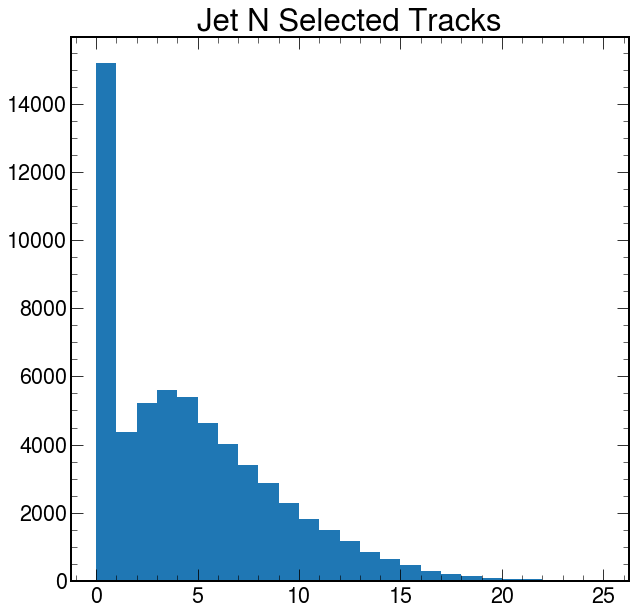

In [7]:
plt.hist(ar, bins=np.arange(26))
plt.title('Jet N Selected Tracks')

I'm only showing the 2D Flight Distance Value because I initially used it to completely delete all those jets where this variable is -999.
This might not be necessary anymore as we will actually define default values as -999 ourselves and can further clean the dataset by just specifying if enough tracks were available to compute the track variables. In this case, out of the roughly 60000 jets there were about 50000 that did not pass this condition and got deleted completely. (I suppose something similar holds true for the datasets I used for training and evaluation.)

This would mean that with a complete new set of files, a lot more jets would still be there after the cleaning. Now I really have the impression that retraining etc. with the new set of files could be helpful because we found a way to deal with weird values without having to delete all the corresponding jets.

In [35]:
arr = tree.arrays("Jet_DeepCSV_flightDistance2dVal", library='pd')
arr.unstack()
arr

Jet_DeepCSV_flightDistance2dVal
entry subentry                                 
0     0                                1.925781
      1                             -999.000000
      2                                0.131958
      3                                0.060944
1     0                             -999.000000
...                                         ...
7738  4                             -999.000000
      5                             -999.000000
      6                             -999.000000
      7                             -999.000000
      8                             -999.000000

[60267 rows x 1 columns]

In [36]:
arr.describe()

,Jet_DeepCSV_flightDistance2dVal
count,60267.000000
mean,-787.336243
std,408.315308
min,-999.000000
25%,-999.000000
50%,-999.000000
75%,-999.000000
max,2.498047


Text(0.5, 1.0, 'Flight Distance 2D Val')

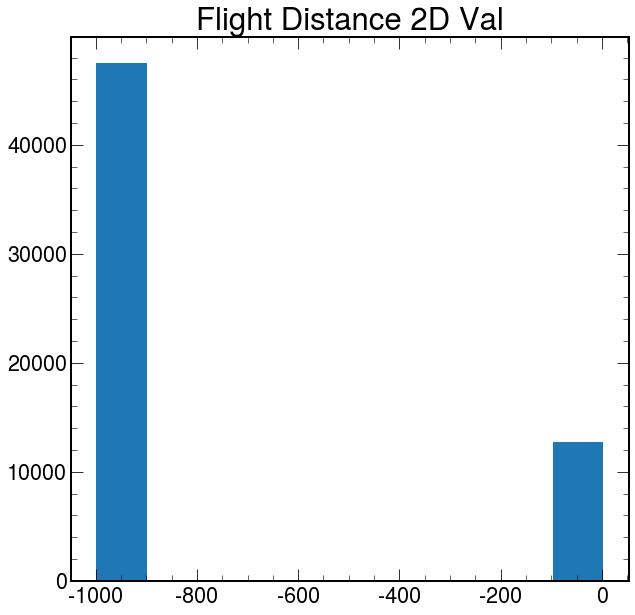

In [38]:
plt.hist(arr)
plt.title('Flight Distance 2D Val')

### Cleaning Part 1, the old way using arrays
For most of these things, I would be able now to rewrite it with pandas to be able to access colunms based on the name (hopefully reducing mistakes)

In [8]:
def cleandataset(f):
# the feature-names are the attributes or columns of interest, in this case: information about Jets
    feature_names = [k for k in f['Events'].keys() if  (('Jet_eta' == k) or ('Jet_pt' == k) or ('Jet_DeepCSV' in k))]
    # tagger output to compare with later and variables used to get the truth output
    feature_names.extend(('Jet_btagDeepB_b','Jet_btagDeepB_bb', 'Jet_btagDeepC','Jet_btagDeepL'))
    feature_names.extend(('Jet_nBHadrons', 'Jet_hadronFlavour'))
    
    
    # go through a specified number of events, and get the information (awkward-arrays) for the keys specified above
    for data in f['Events'].iterate(feature_names, step_size=f['Events'].num_entries, library='ak'):
        break
        
    
    # creating an array to store all the columns with their entries per jet, flatten per-event -> per-jet
    datacolumns = np.zeros((len(feature_names)+1, len(ak.flatten(data['Jet_pt'], axis=1))))
   

    for featureindex in range(len(feature_names)):
        a = ak.flatten(data[feature_names[featureindex]], axis=1) # flatten along first inside to get jets
        
        datacolumns[featureindex] = ak.to_numpy(a)


    nbhad = ak.to_numpy(ak.flatten(data['Jet_nBHadrons'], axis=1))
    hadflav = ak.to_numpy(ak.flatten(data['Jet_hadronFlavour'], axis=1))

    target_class = np.full_like(hadflav, 3)                                                      # udsg
    target_class = np.where(hadflav == 4, 2, target_class)                                       # c
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad > 1), 1, target_class)            # bb
    target_class = np.where(np.bitwise_and(hadflav == 5, nbhad <= 1), 0, target_class)           # b, lepb

   

    datacolumns[len(feature_names)] = ak.to_numpy(target_class) 

    datavectors = datacolumns.transpose()

    datavecak = ak.from_numpy(datavectors)
        
    datavecak = datavecak[datavecak[:, 3] != -999]         # this is the variable "Flight Distance 2D Val"
                                                           # it does have a lot of -999 values, and all jets that have this feature are deleted in this step
                                                           # it could be too strict of a condition, as it drastically reduces the number of jets
                                                           # maybe for a new cleaning version, this can be skipped completely as we will be working with defaults anyway
    
    datavecak = datavecak[datavecak[:, 67] >= 0.]
    datavecak = datavecak[datavecak[:, 67] <= 1.]
    datavecak = datavecak[datavecak[:, 68] >= 0.]
    datavecak = datavecak[datavecak[:, 68] <= 1.]
    datavecak = datavecak[datavecak[:, 69] >= 0.]
    datavecak = datavecak[datavecak[:, 69] <= 1.]
    datavecak = datavecak[datavecak[:, 70] >= 0.]
    datavecak = datavecak[datavecak[:, 70] <= 1.]

    for j in range(len(datavecak[0])):
        datavecak = datavecak[datavecak[:, j] != np.nan]
        datavecak = datavecak[datavecak[:, j] > -np.inf]
        datavecak = datavecak[datavecak[:, j] < np.inf]

    # check jetNSelectedTracks, jetNSecondaryVertices > 0
    datavecak = datavecak[(datavecak[:, 63] > 0) | (datavecak[:, 64] > 0)]  # keep those where at least any of the two variables is > 0, they don't need to be > 0 simultaneously
    print(len(datavecak),"entries after removing jetNSelectedTracks and jetNSecondaryVertices = 0 at the same time")

    alldata = ak.to_numpy(datavecak)
    
    datacls = [i for i in range(0,67)]
    datacls.append(73)
    dataset = alldata[:, datacls]
    
    DeepCSV_dataset = alldata[:, 67:71]
    
    return dataset, DeepCSV_dataset

In [11]:
dataset_step1, DeepCSV_dataset_step1 = cleandataset(rootfile)

12204 entries after removing jetNSelectedTracks and jetNSecondaryVertices = 0 at the same time


In [13]:
display_names = ['Jet $\eta$',
                'Jet $p_T$',
                'Flight Distance 2D Sig','Flight Distance 2D Val','Flight Distance 3D Sig', 'Flight Distance 3D Val',
                'Track Decay Len Val [0]','Track Decay Len Val [1]','Track Decay Len Val [2]','Track Decay Len Val [3]','Track Decay Len Val [4]','Track Decay Len Val [5]',
                'Track $\Delta R$ [0]','Track $\Delta R$ [1]','Track $\Delta R$ [2]','Track $\Delta R$ [3]','Track $\Delta R$ [4]','Track $\Delta R$ [5]',
                'Track $\eta_{rel}$ [0]','Track $\eta_{rel}$ [1]','Track $\eta_{rel}$ [2]','Track $\eta_{rel}$ [3]',
                'Track Jet Dist Val [0]','Track Jet Dist Val [1]','Track Jet Dist Val [2]','Track Jet Dist Val [3]','Track Jet Dist Val [4]','Track Jet Dist Val [5]',
                'Track Jet $p_T$',
                'Track $p_T$ Ratio [0]','Track $p_T$ Ratio [1]','Track $p_T$ Ratio [2]','Track $p_T$ Ratio [3]','Track $p_T$ Ratio [4]','Track $p_T$ Ratio [5]',
                'Track $p_{T,rel}$ [0]','Track $p_{T,rel}$ [1]','Track $p_{T,rel}$ [2]','Track $p_{T,rel}$ [3]','Track $p_{T,rel}$ [4]','Track $p_{T,rel}$ [5]',
                'Track SIP 2D Sig Above Charm',
                'Track SIP 2D Sig [0]','Track SIP 2D Sig [1]','Track SIP 2D Sig [2]','Track SIP 2D Sig [3]','Track SIP 2D Sig [4]','Track SIP 2D Sig [5]',
                'Track SIP 2D Val Above Charm',
                'Track SIP 3D Sig Above Charm',
                'Track SIP 3D Sig [0]','Track SIP 3D Sig [1]','Track SIP 3D Sig [2]','Track SIP 3D Sig [3]','Track SIP 3D Sig [4]','Track SIP 3D Sig [5]',
                'Track SIP 3D Val Above Charm',
                'Track Sum Jet $\Delta R$','Track Sum Jet $E_T$ Ratio',
                'Vertex Category','Vertex Energy Ratio','Vertex Jet $\Delta R$','Vertex Mass',
                'Jet N Secondary Vertices','Jet N Selected Tracks','Jet N Tracks $\eta_{rel}$','Vertex N Tracks']

## Not specifying any range
Plots show everything from max to min

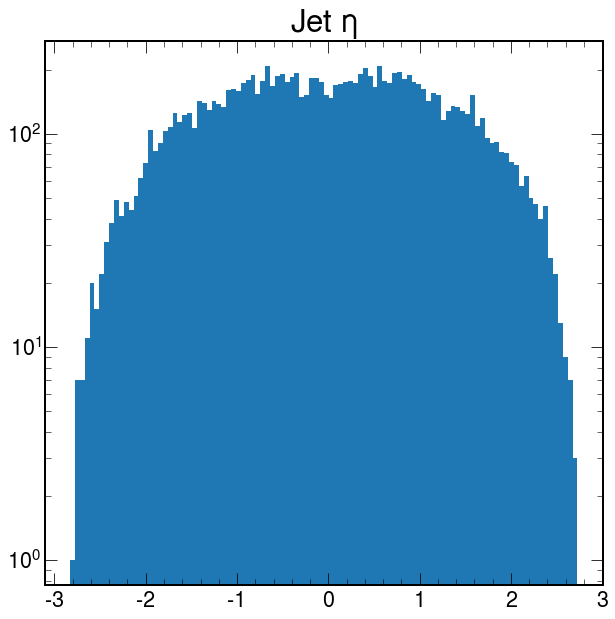

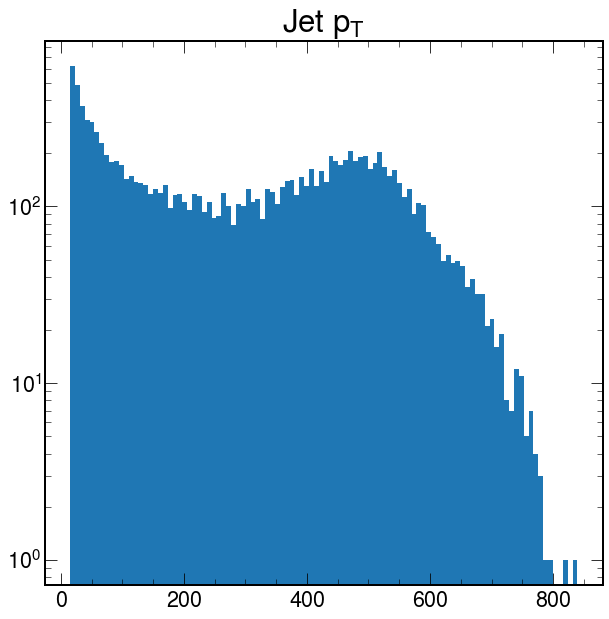

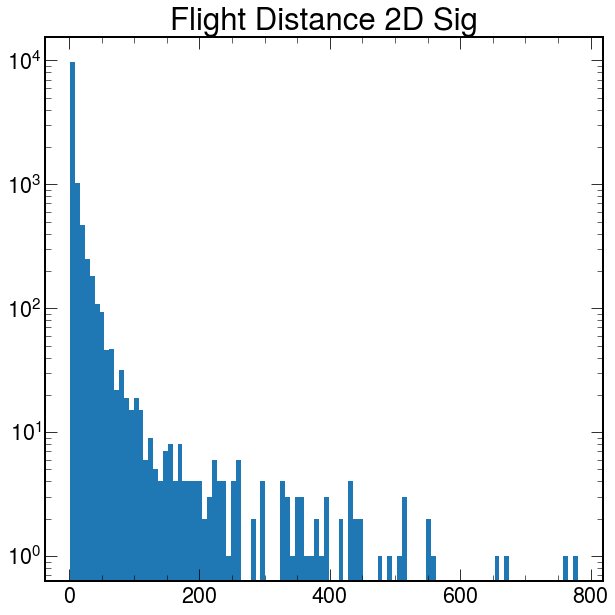

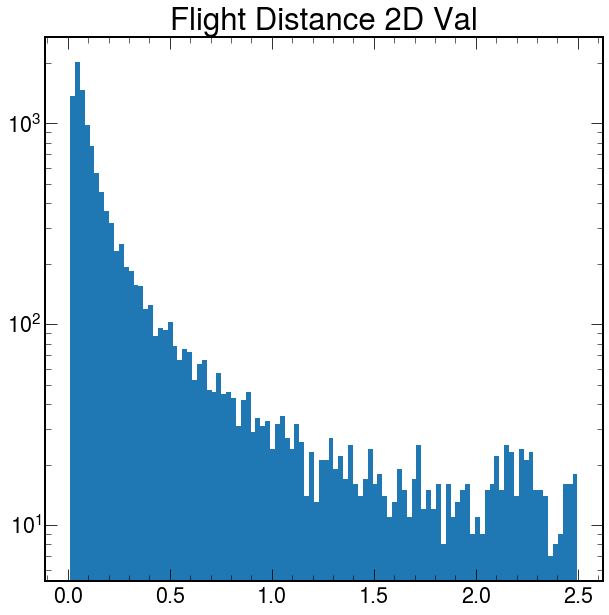

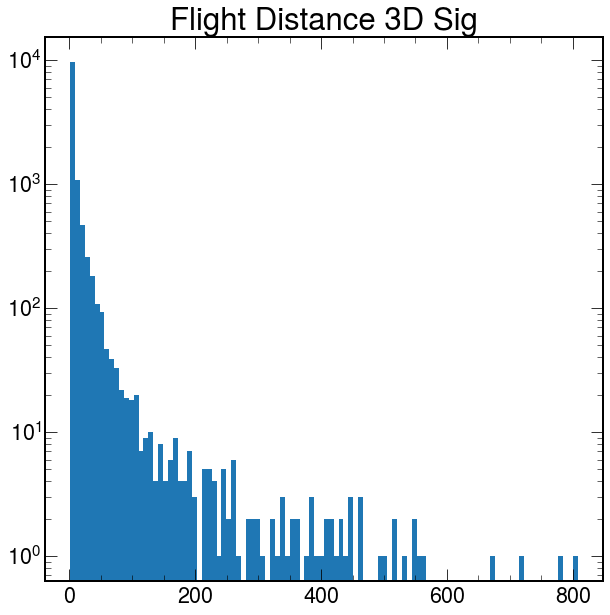

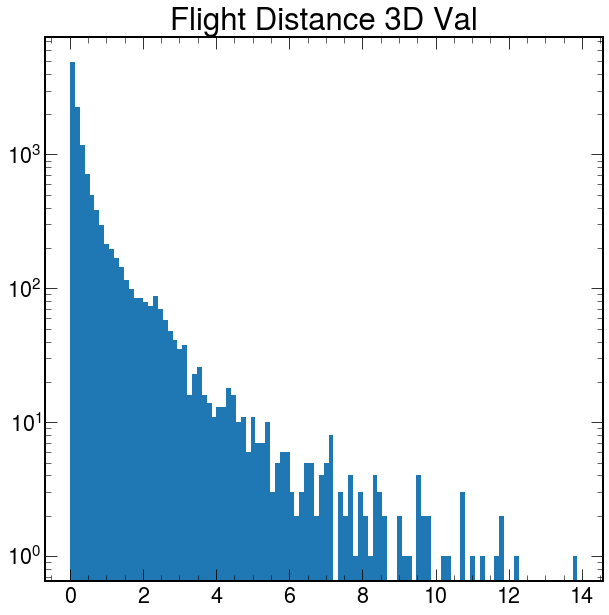

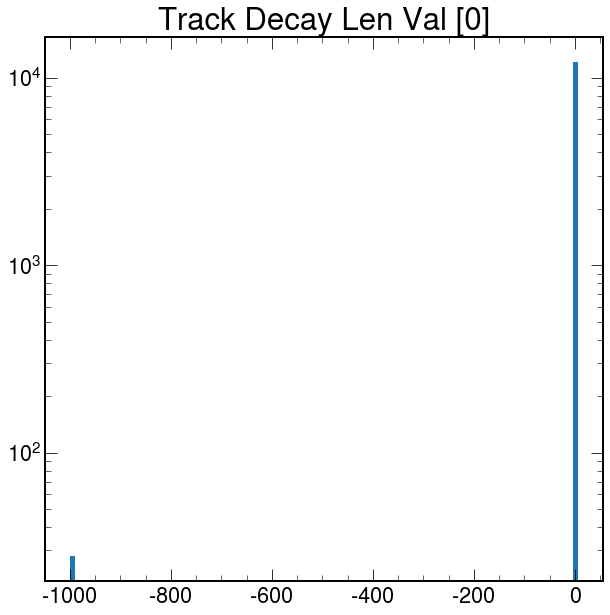

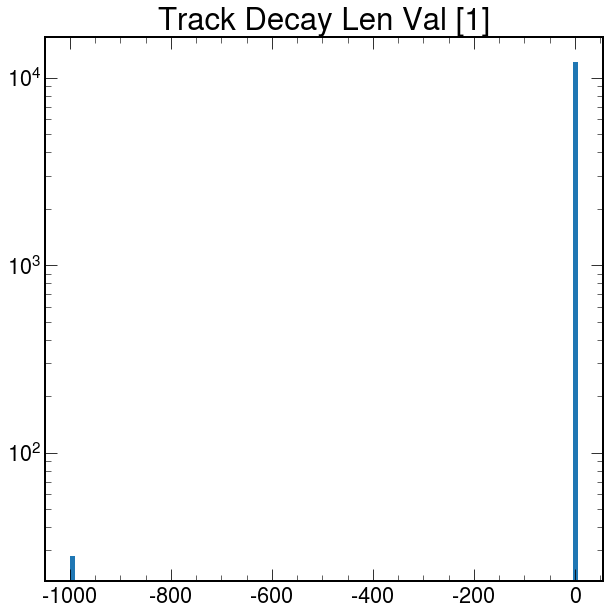

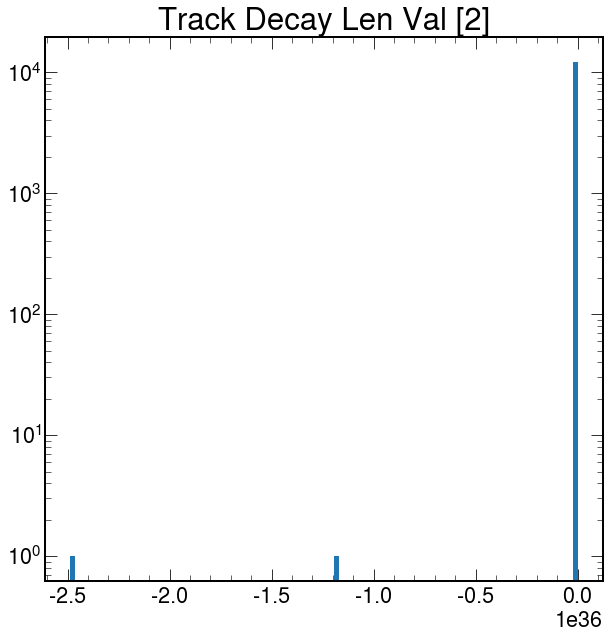

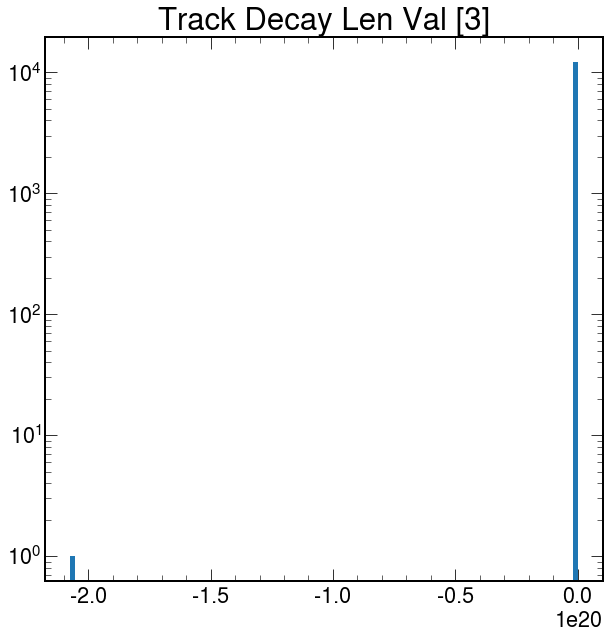

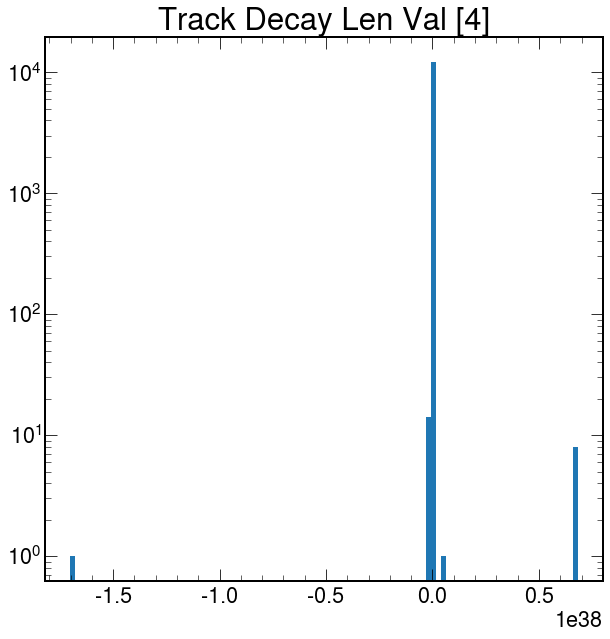

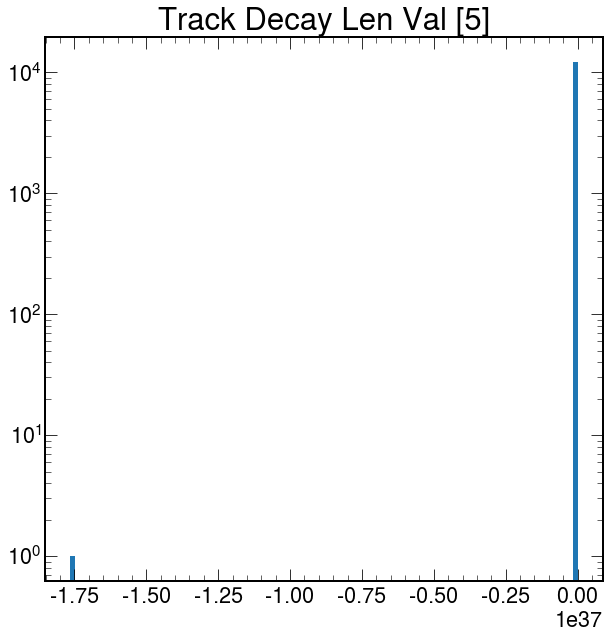

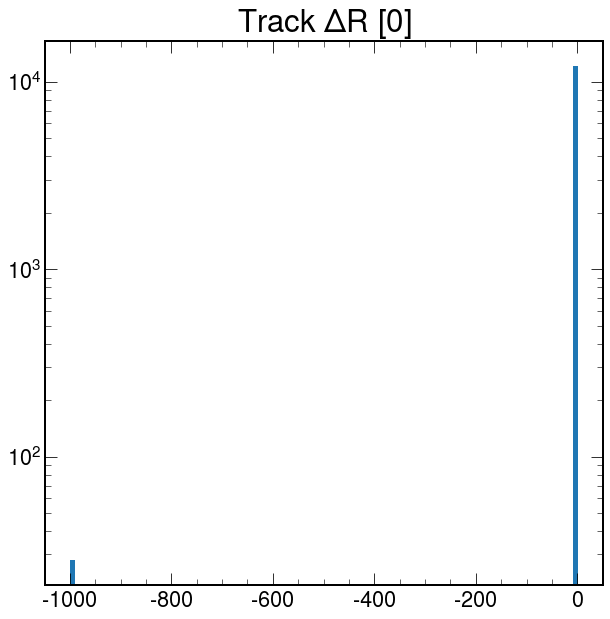

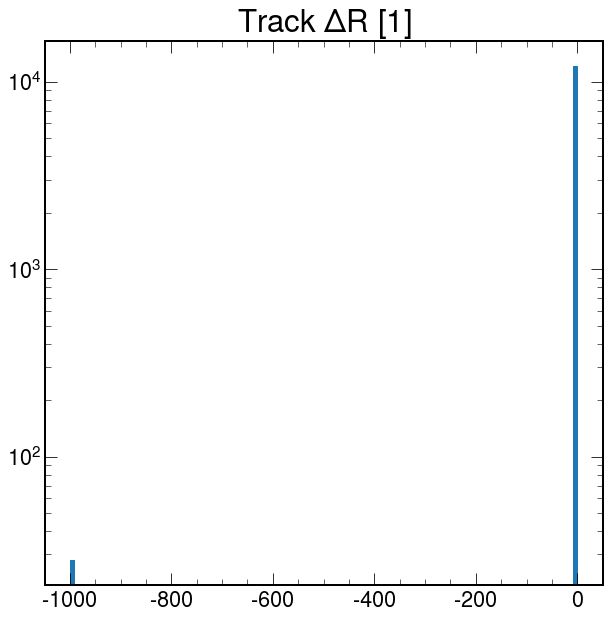

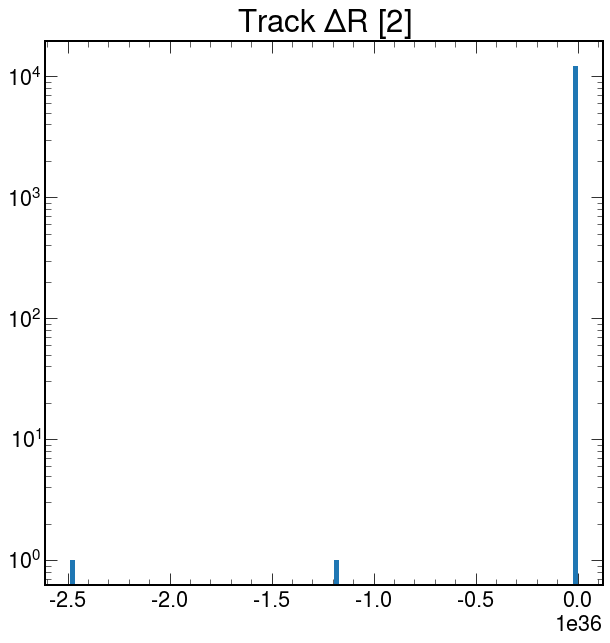

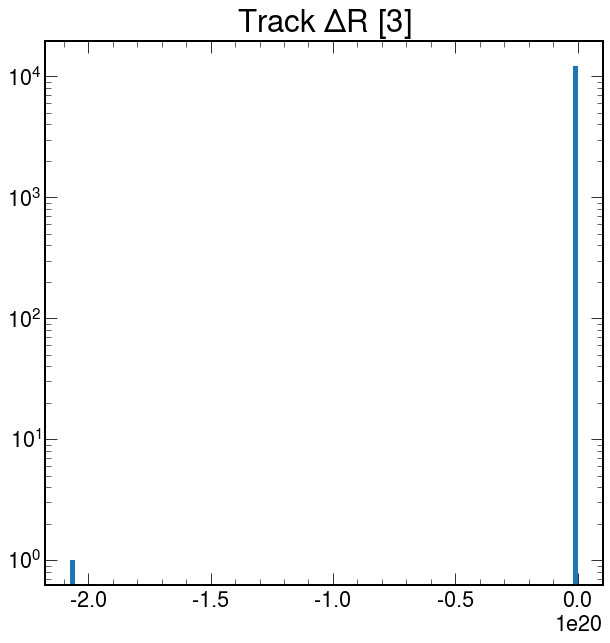

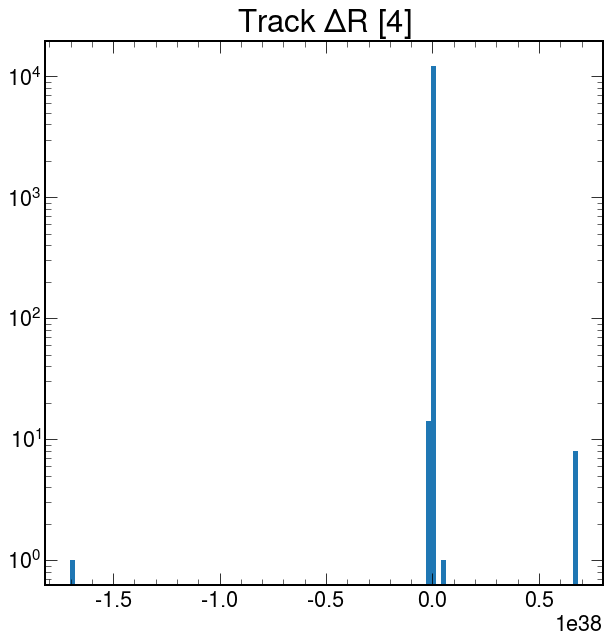

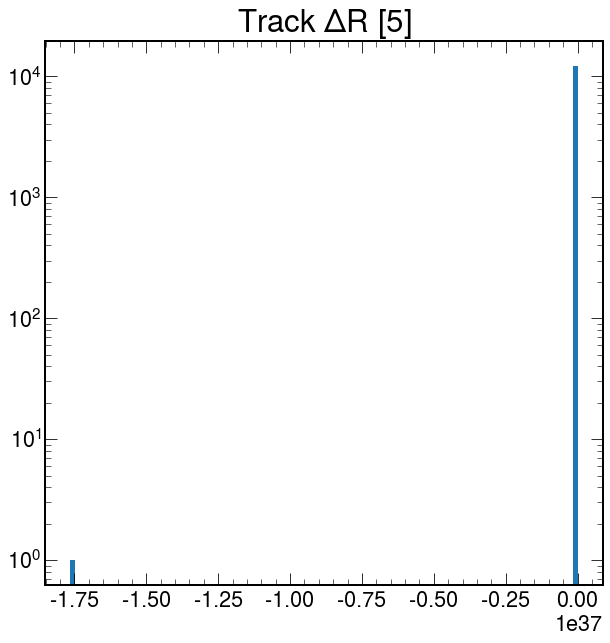

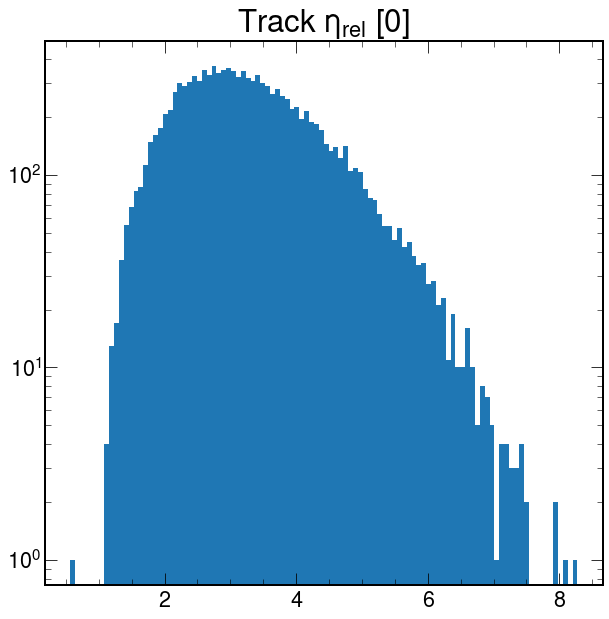

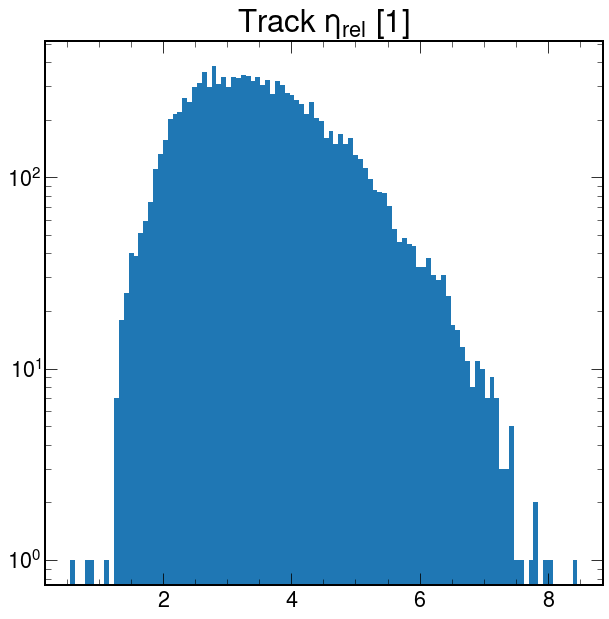

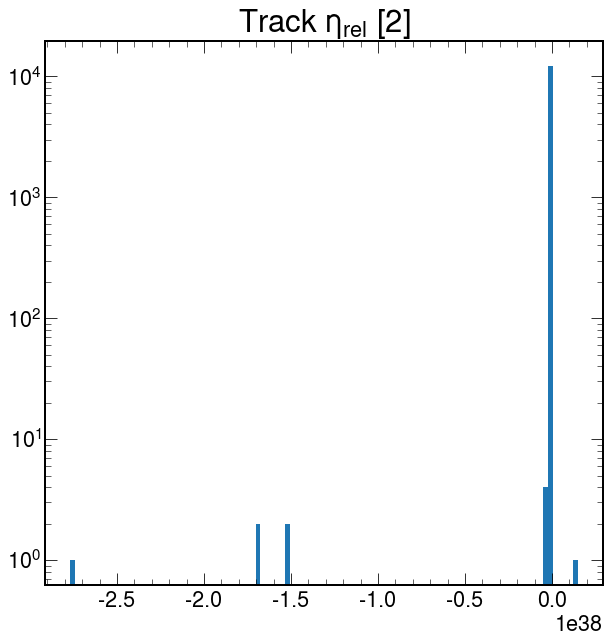

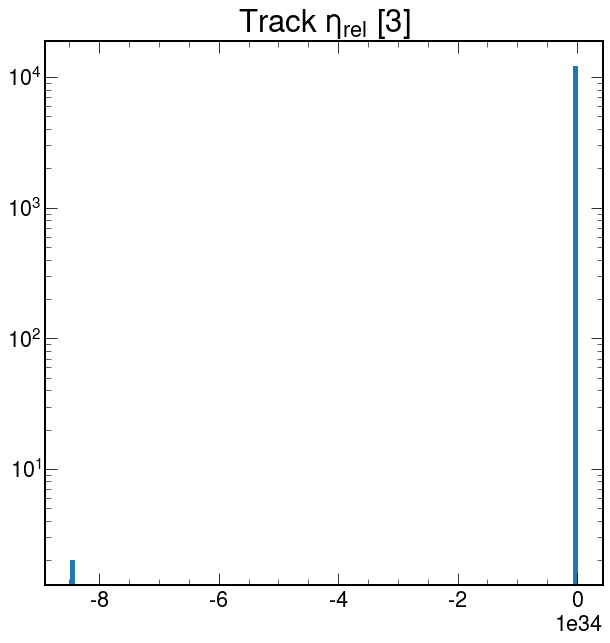

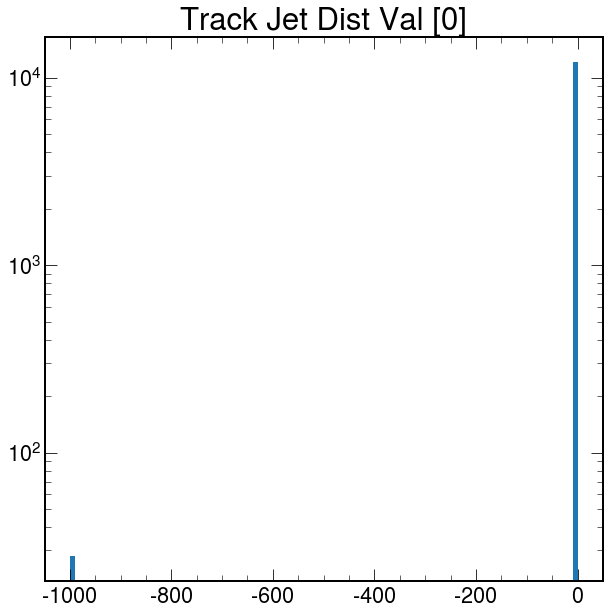

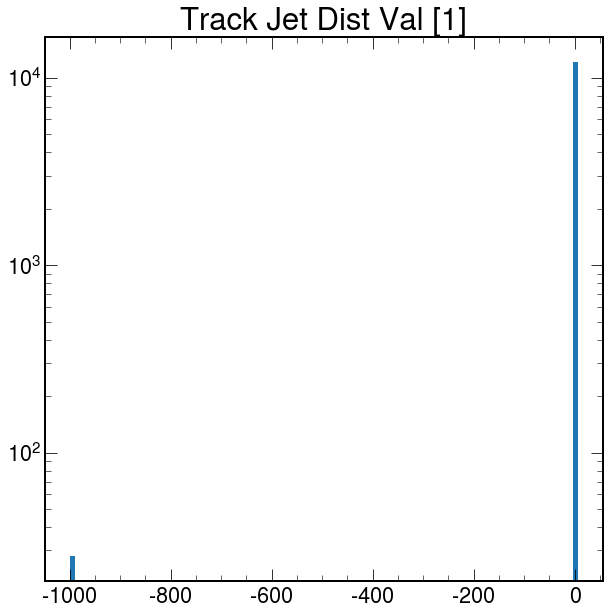

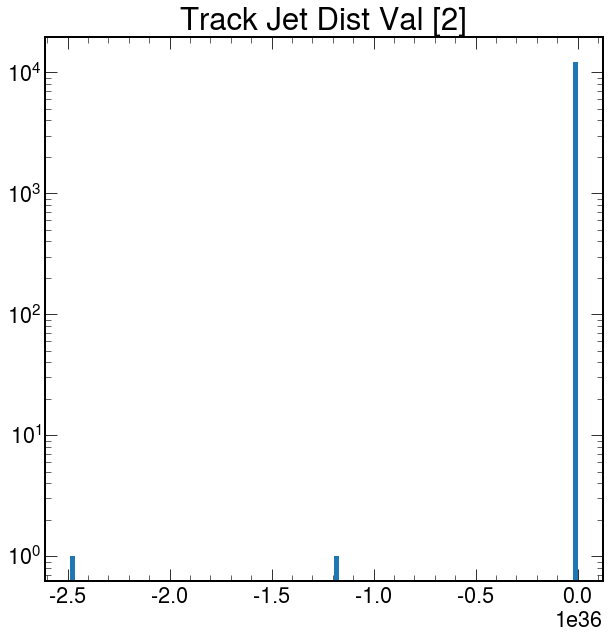

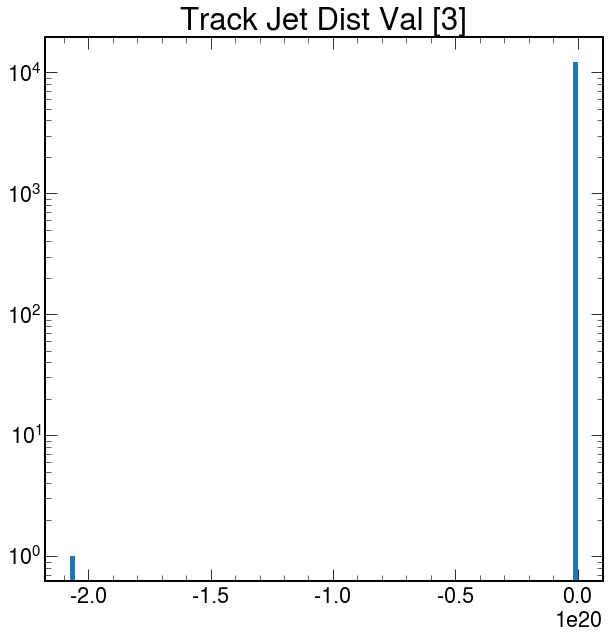

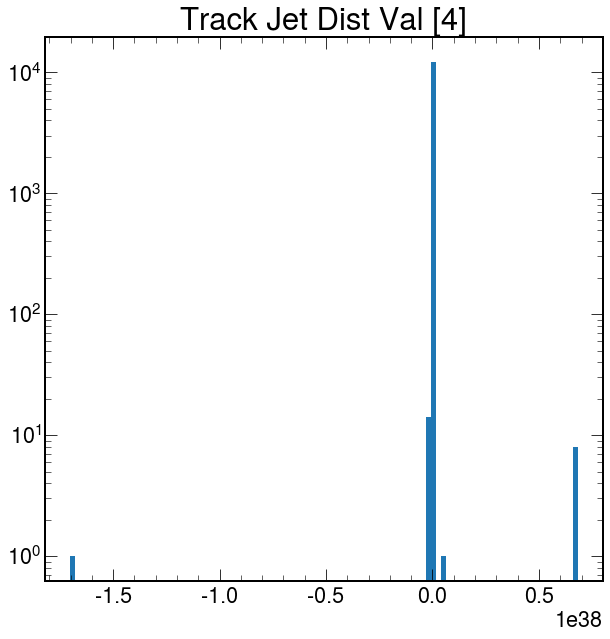

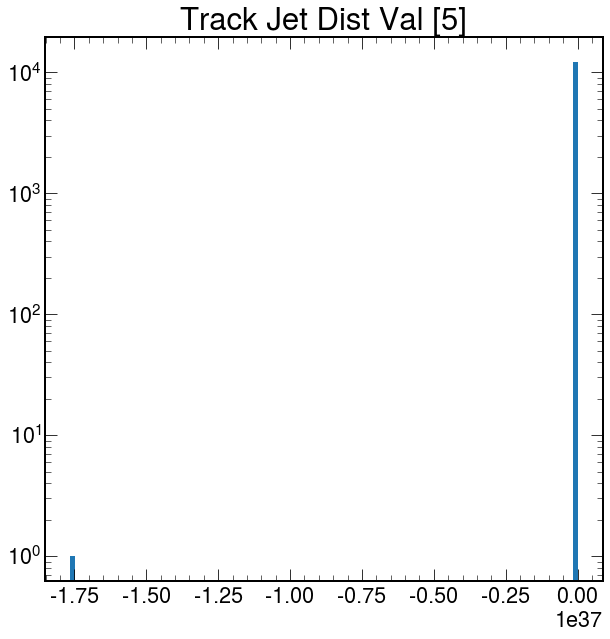

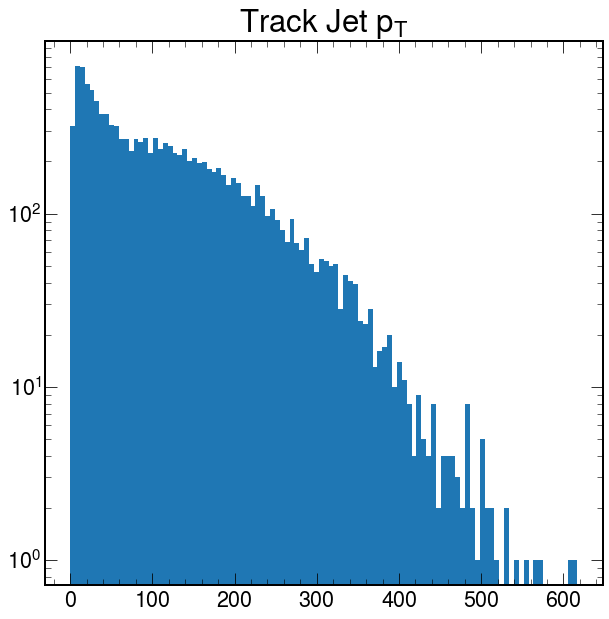

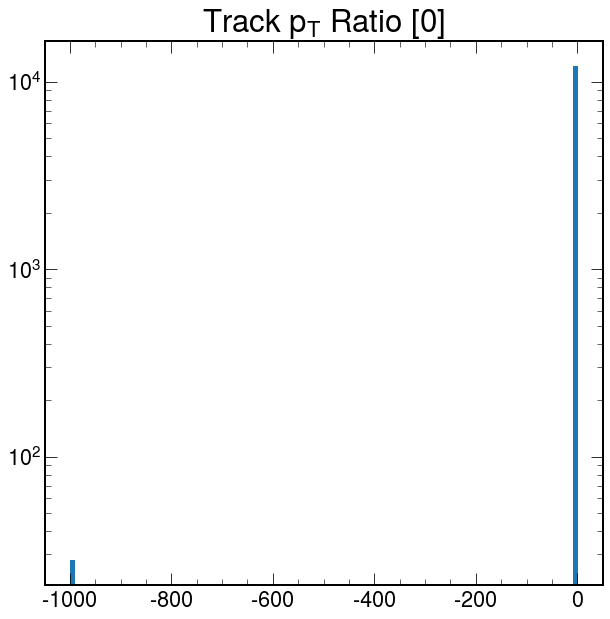

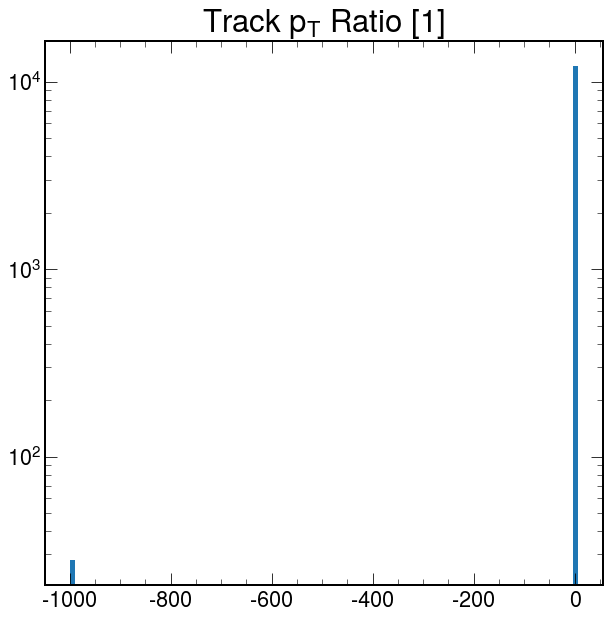

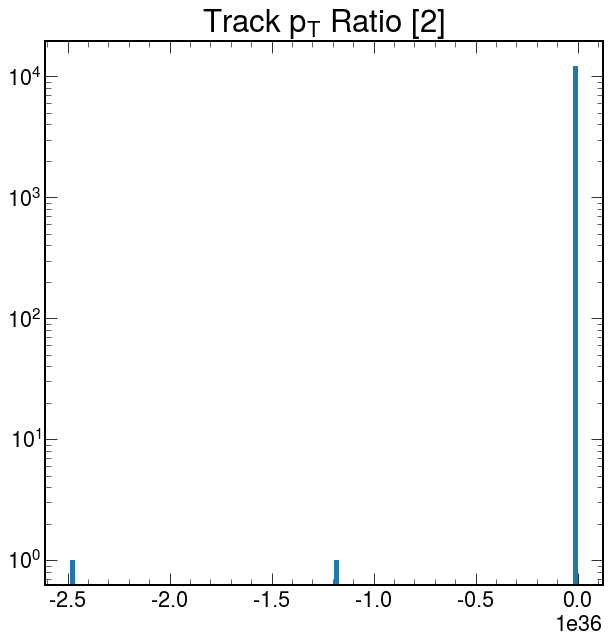

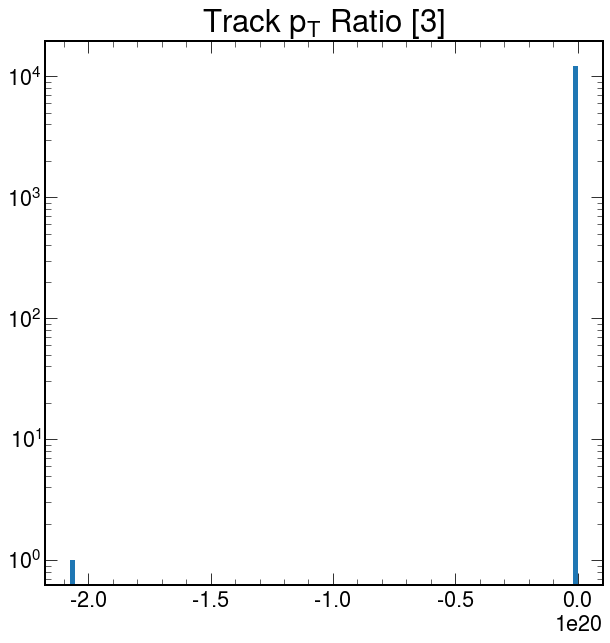

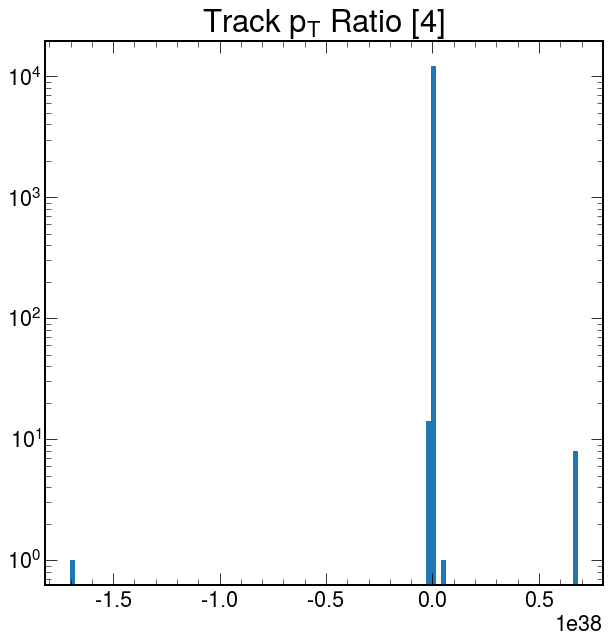

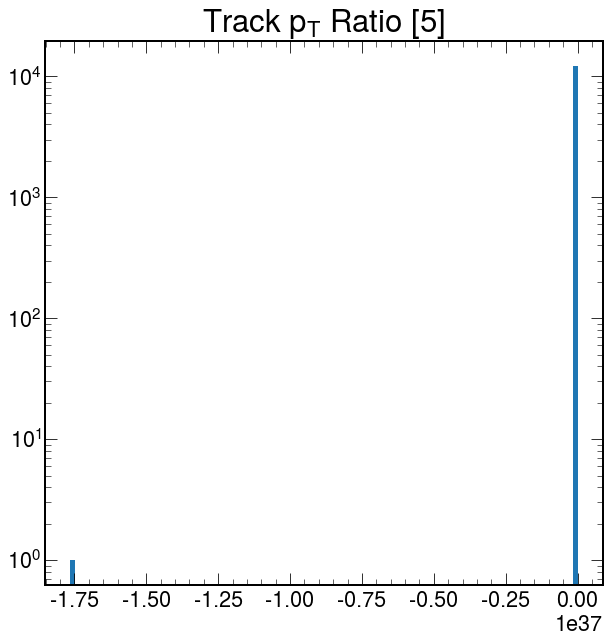

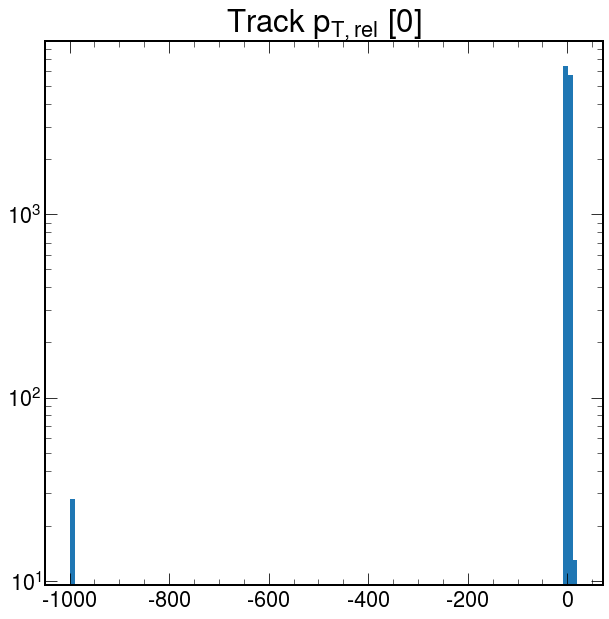

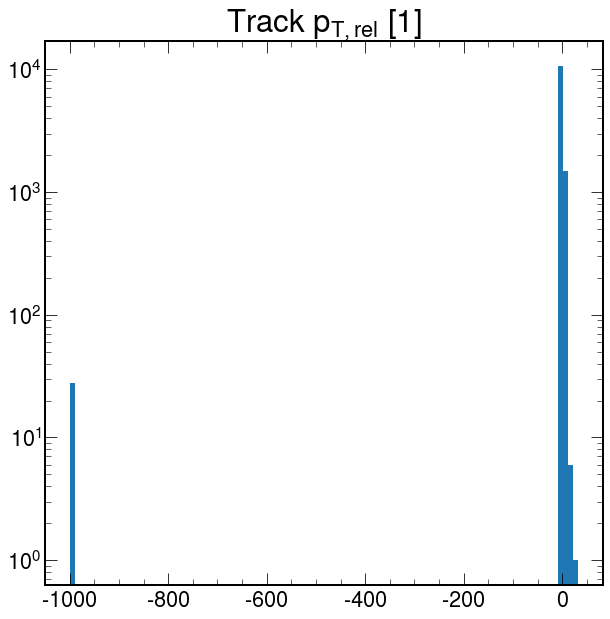

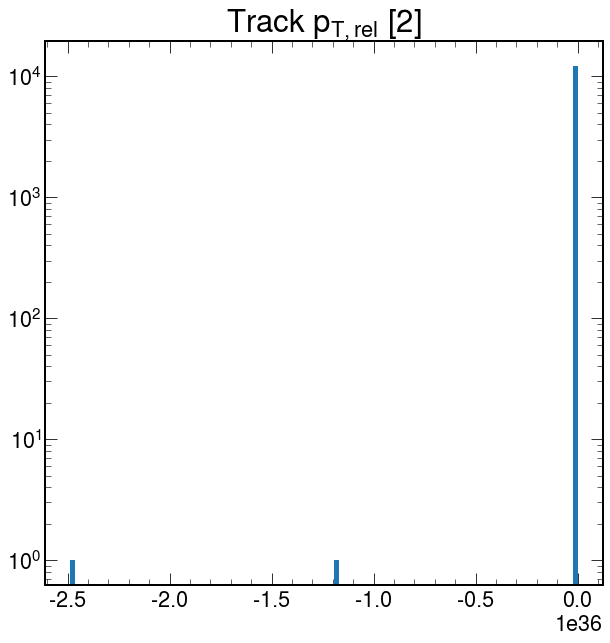

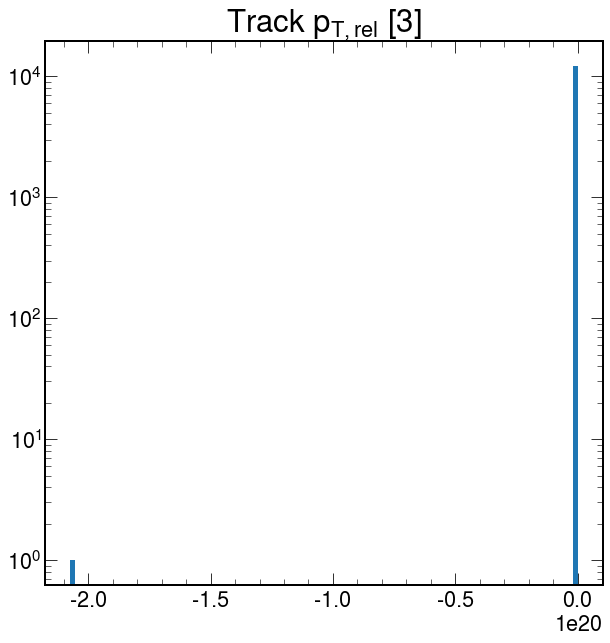

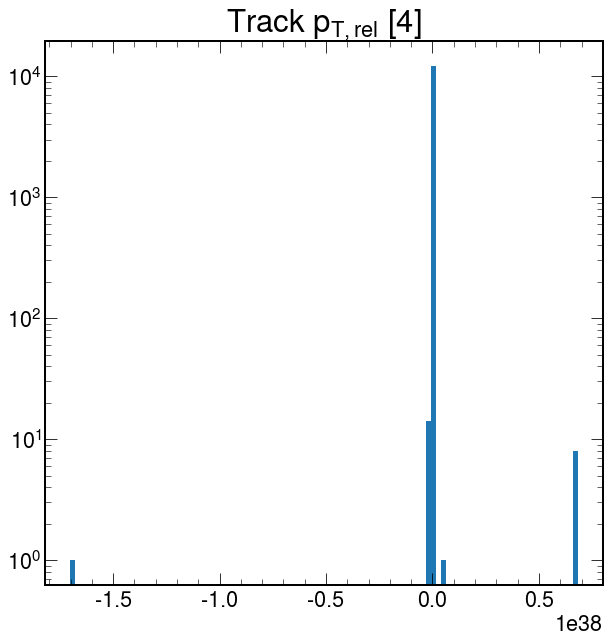

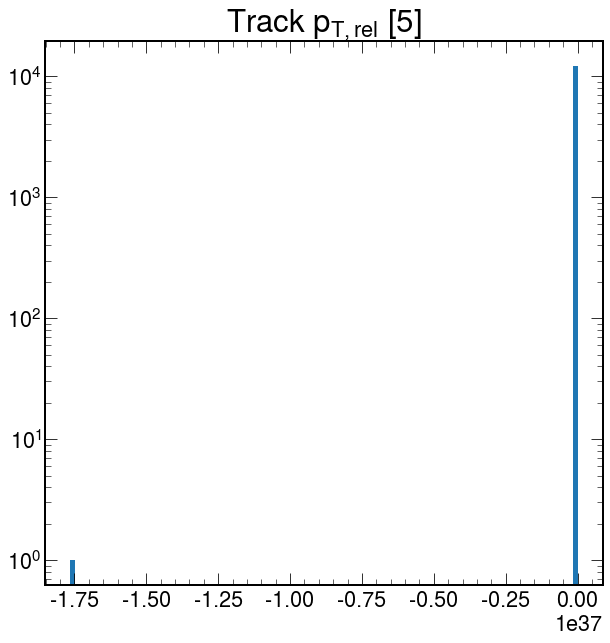

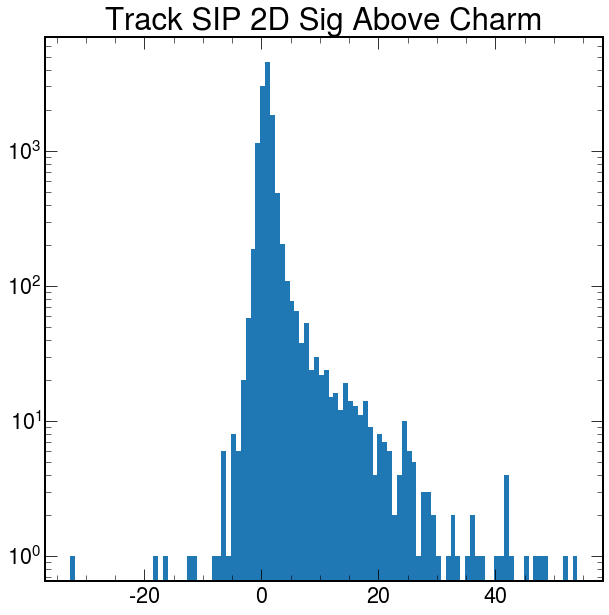

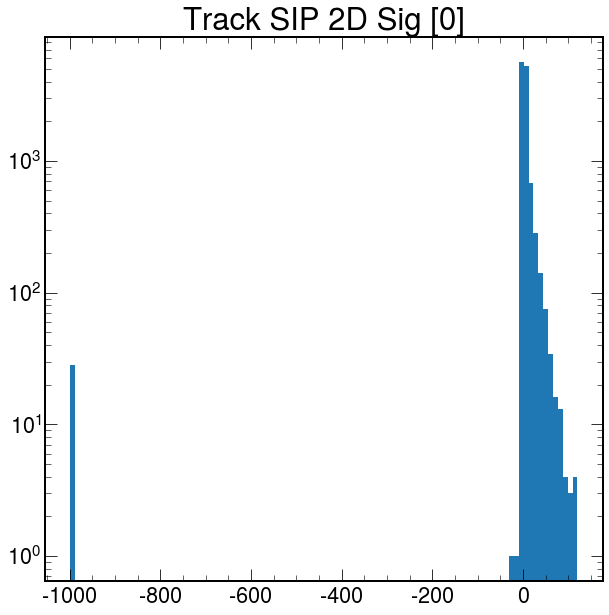

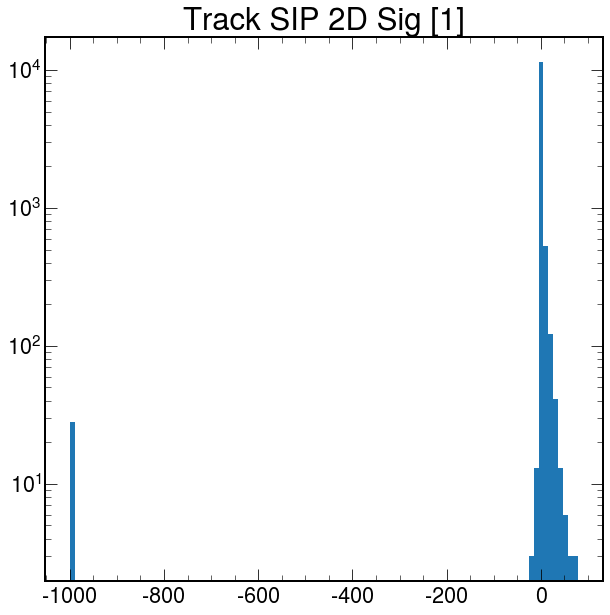

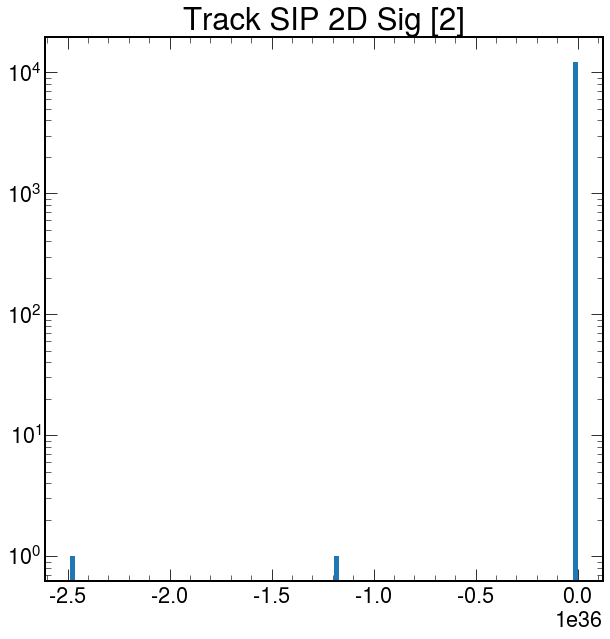

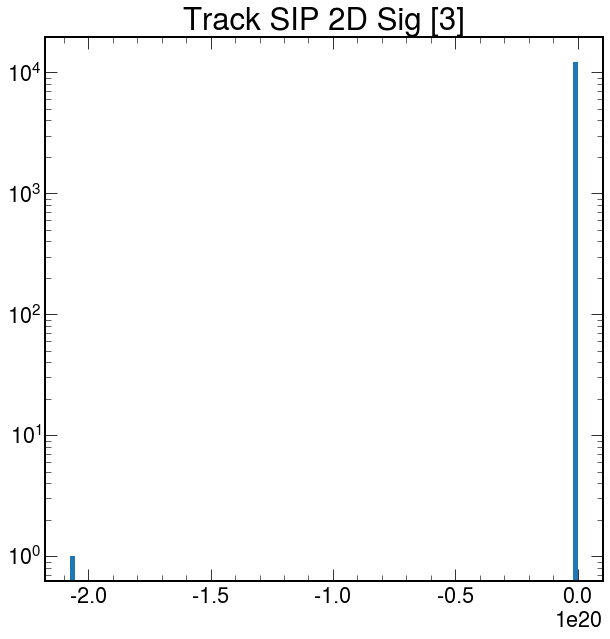

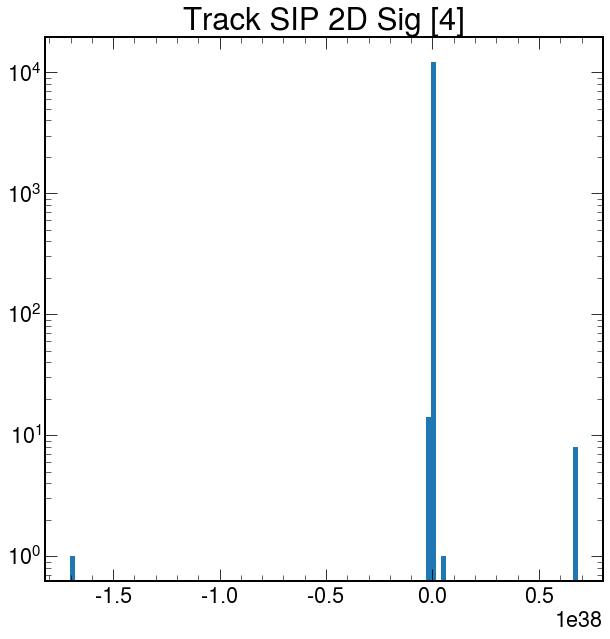

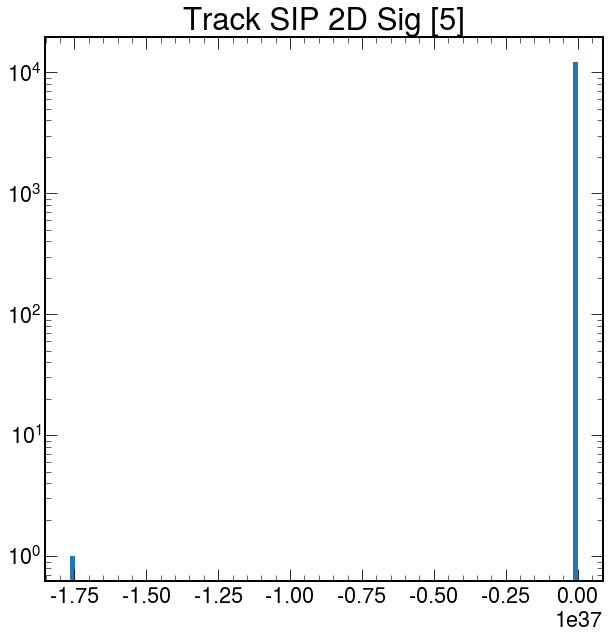

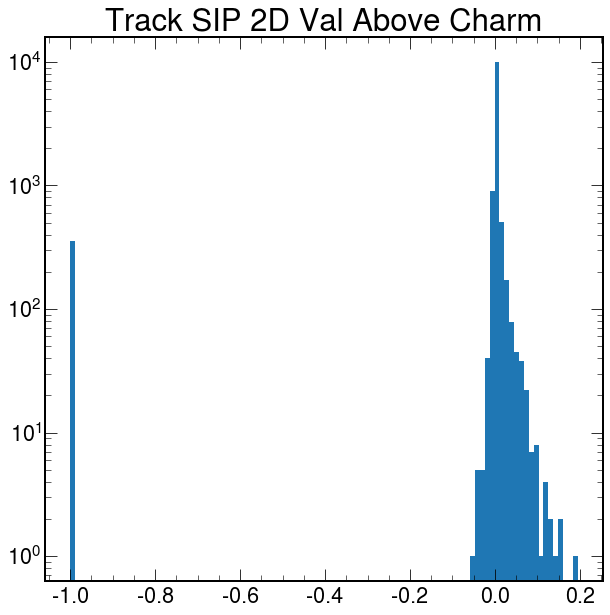

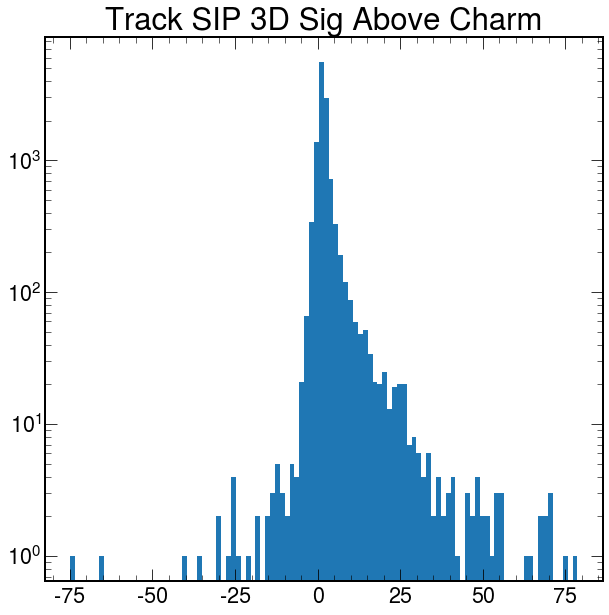

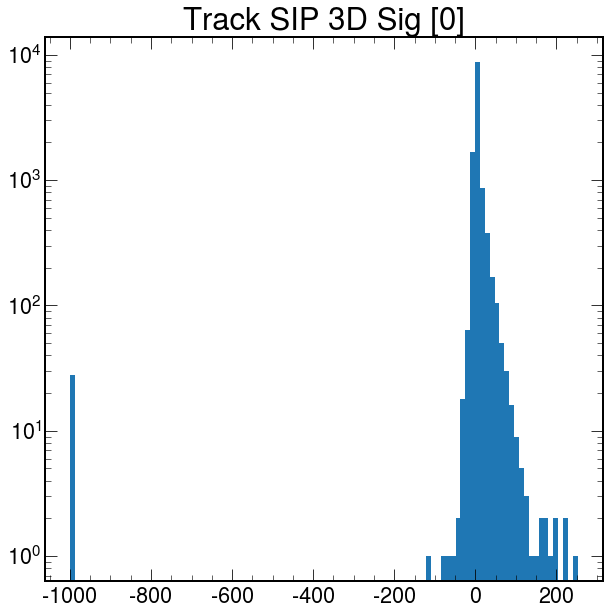

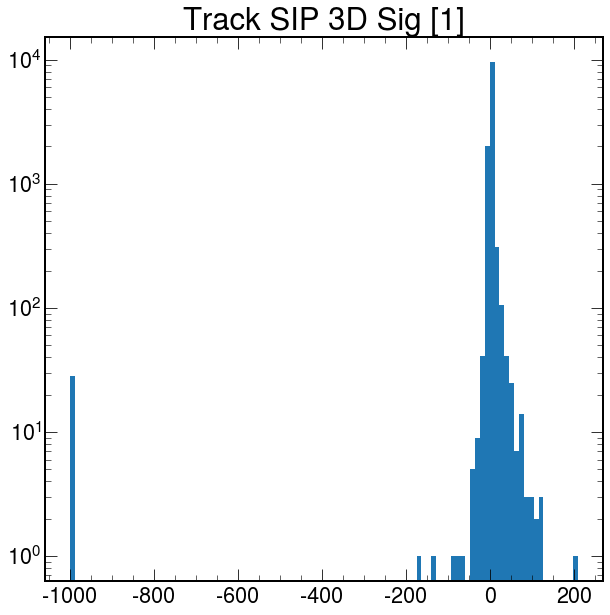

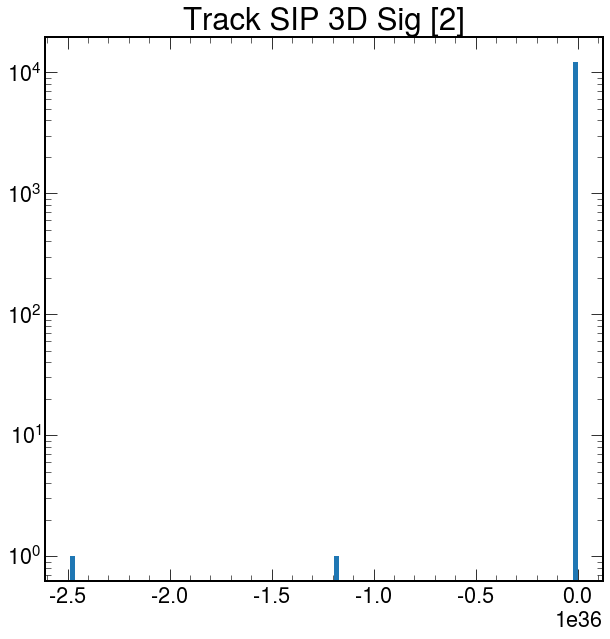

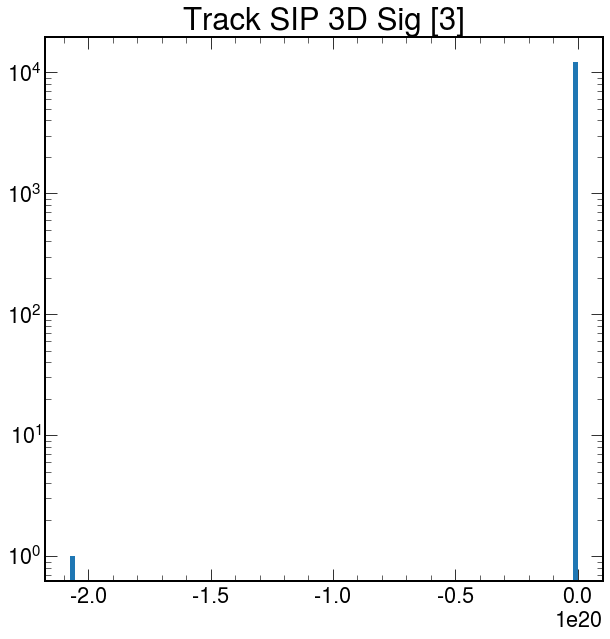

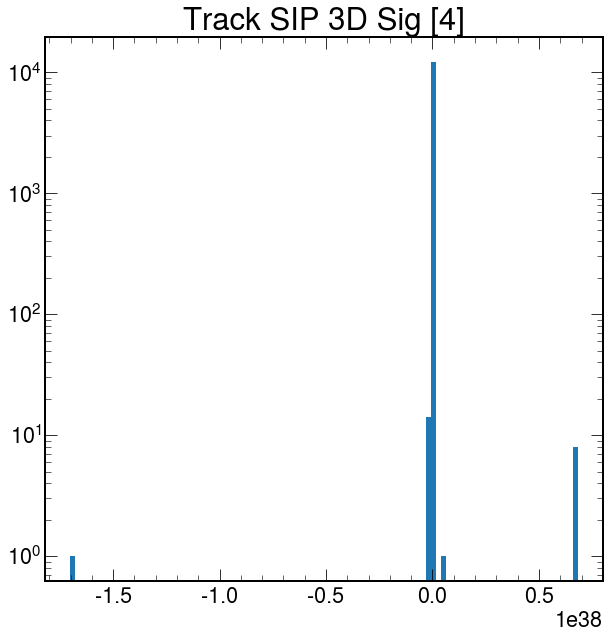

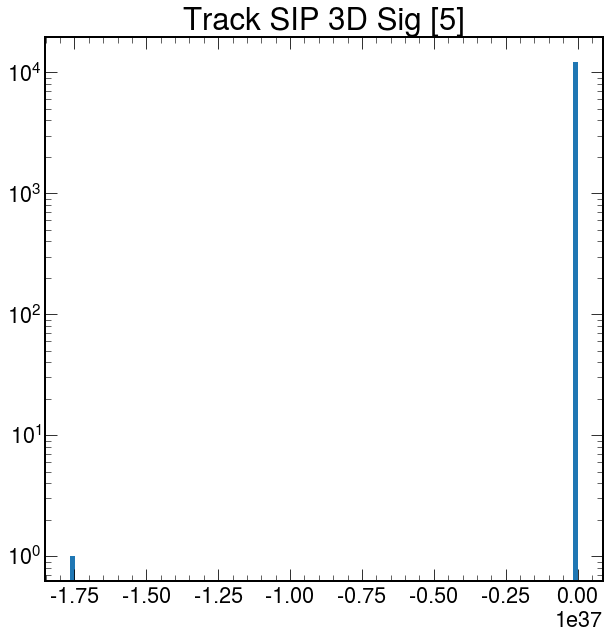

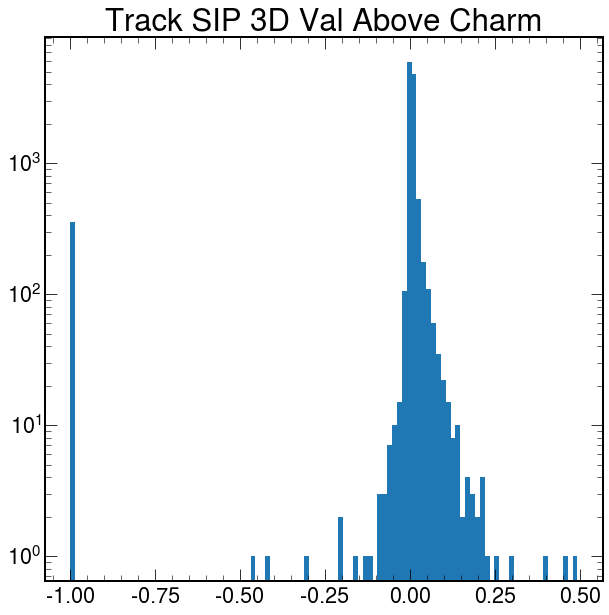

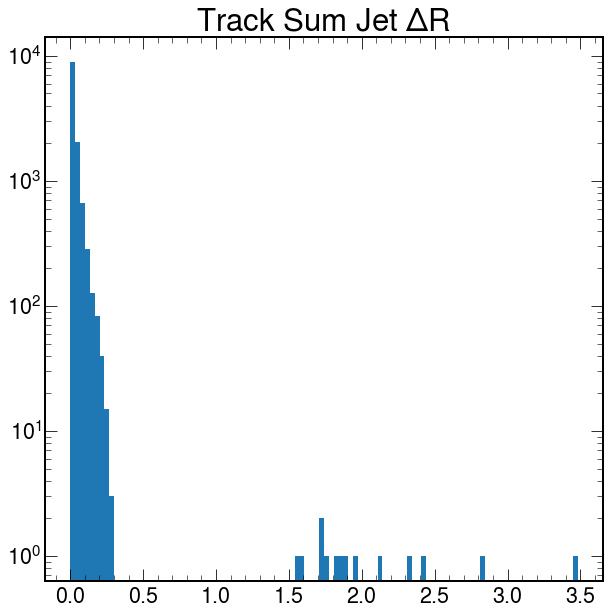

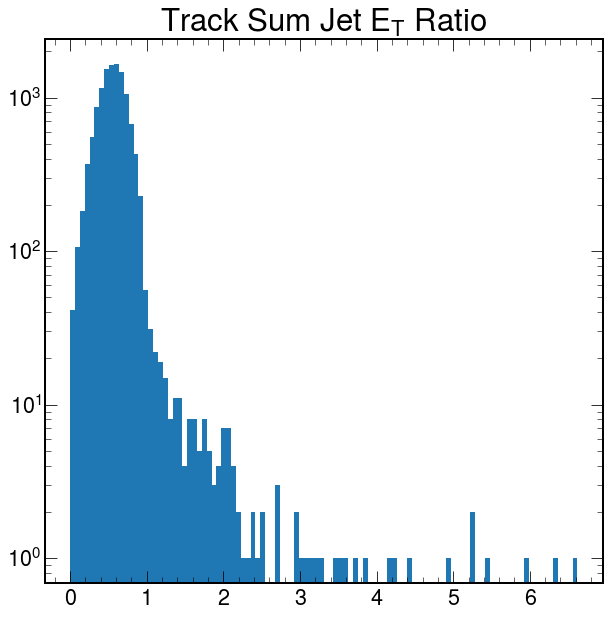

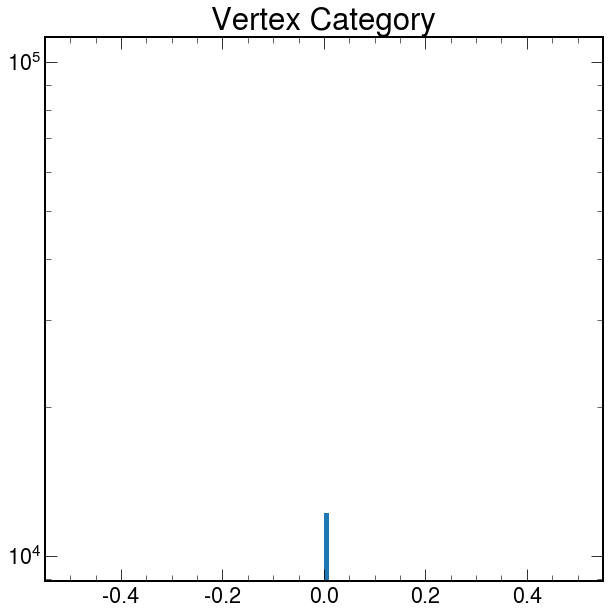

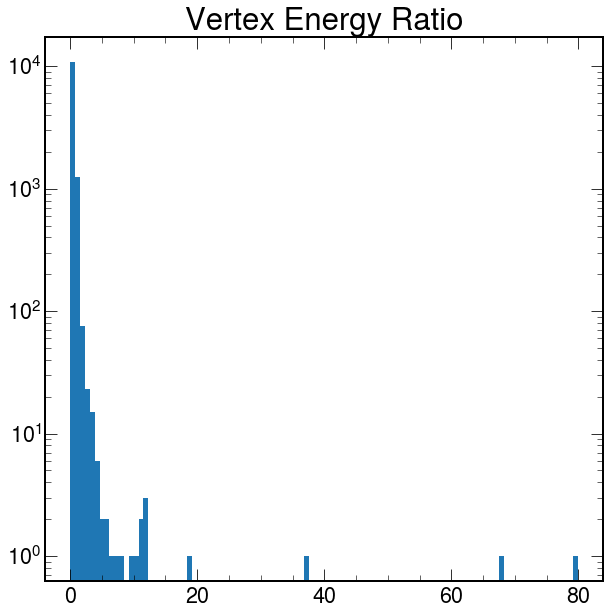

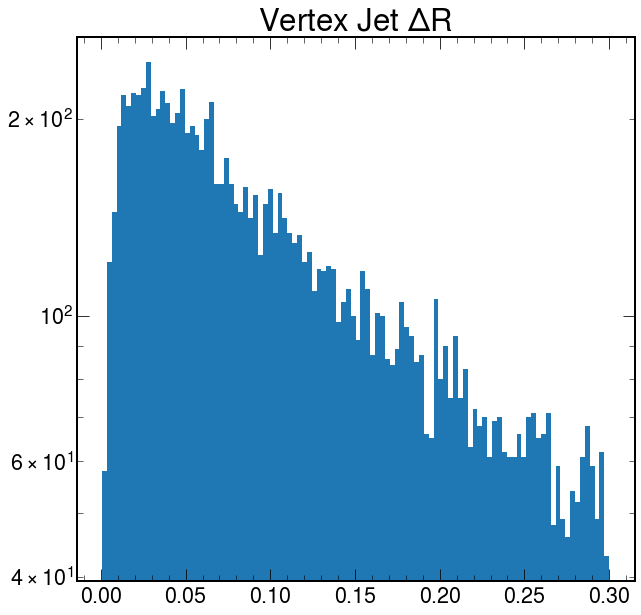

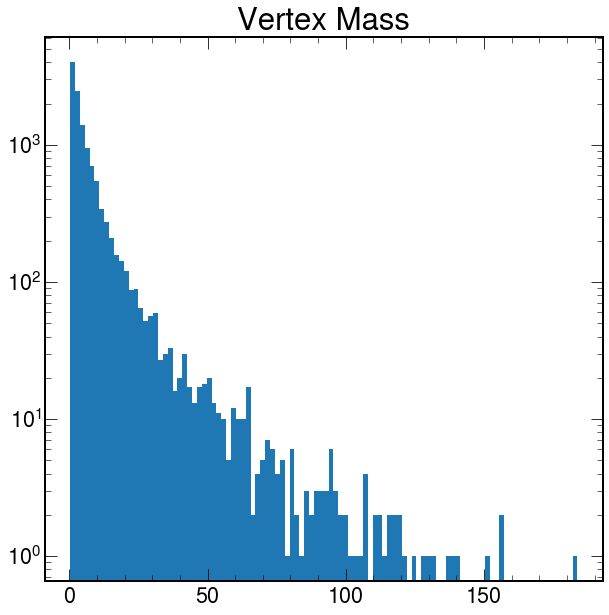

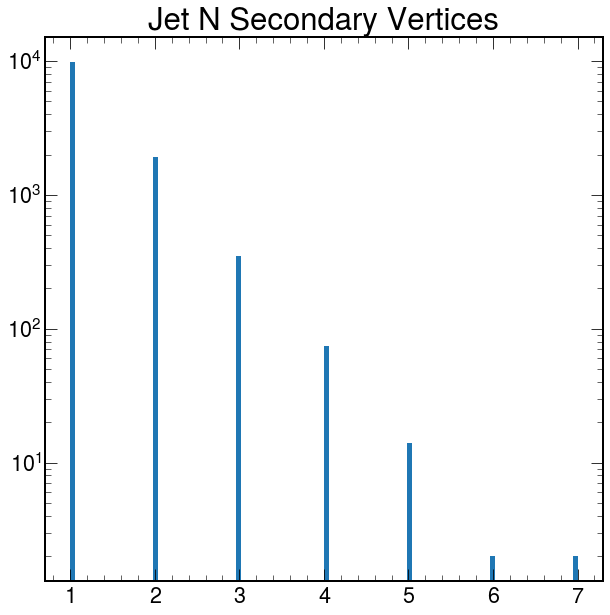

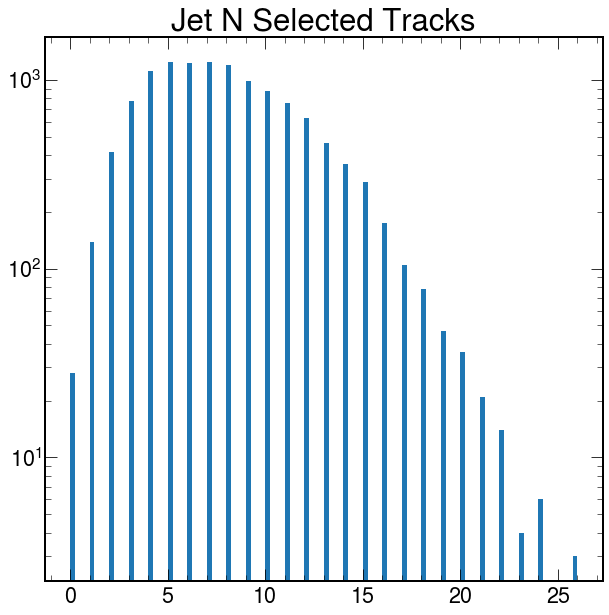

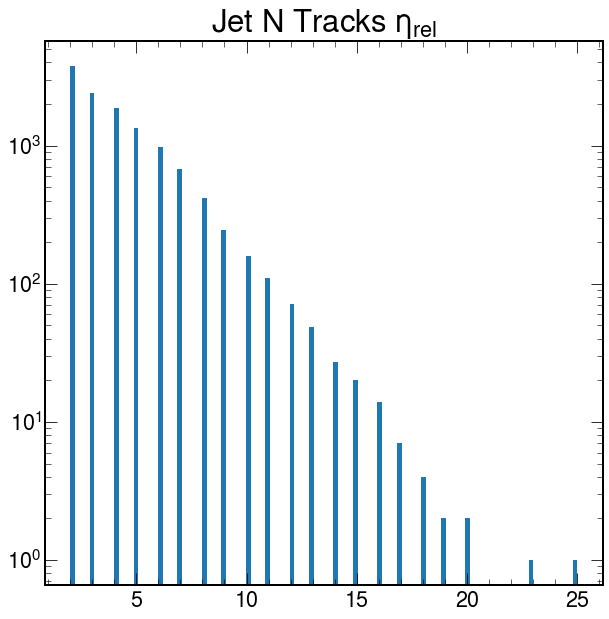

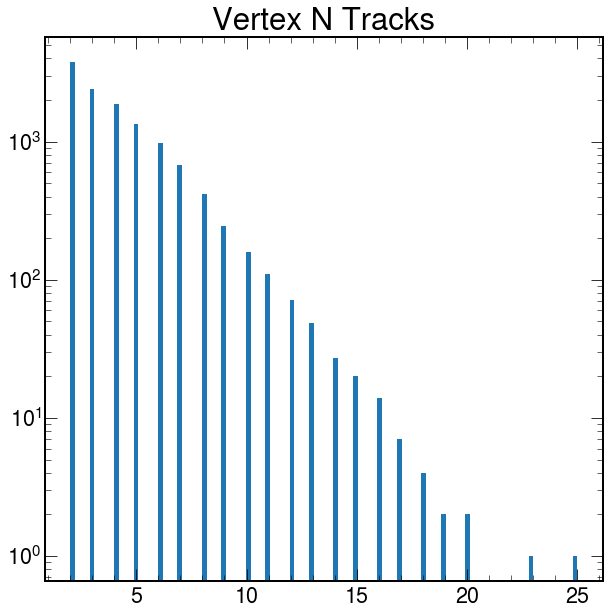

In [20]:
for var in range(67):
    plt.hist(dataset_step1[:,var], bins=104, log=True)
    plt.title(display_names[var])
    plt.show()

Just adjusting the range to see other weird values

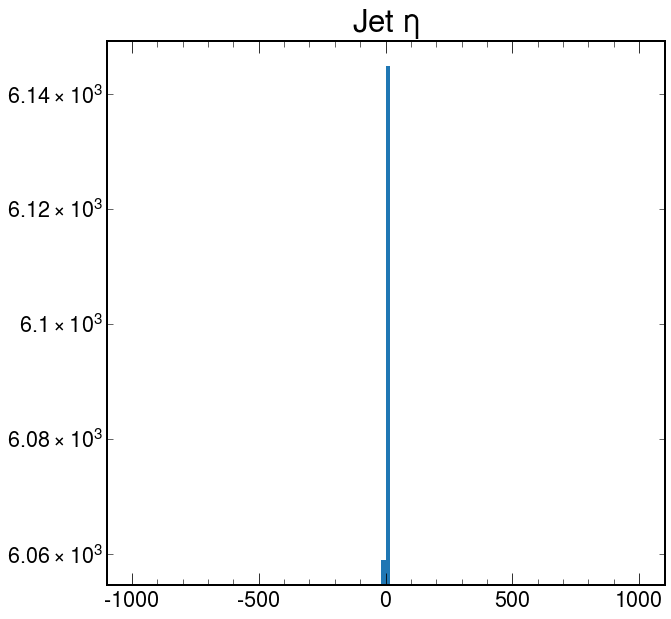

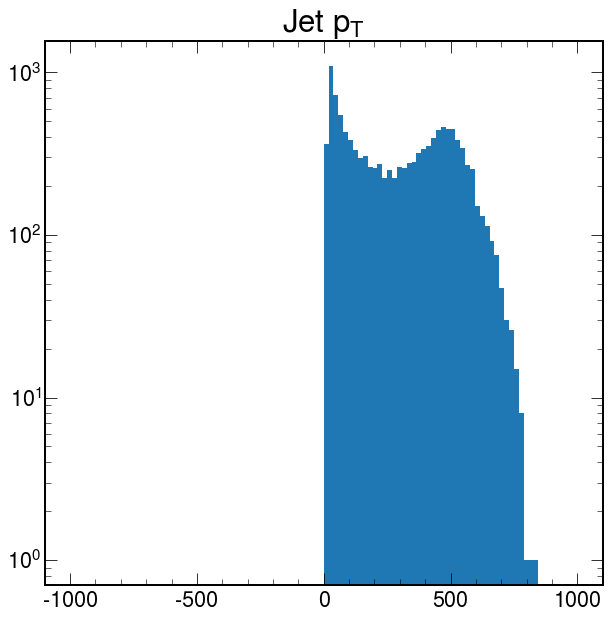

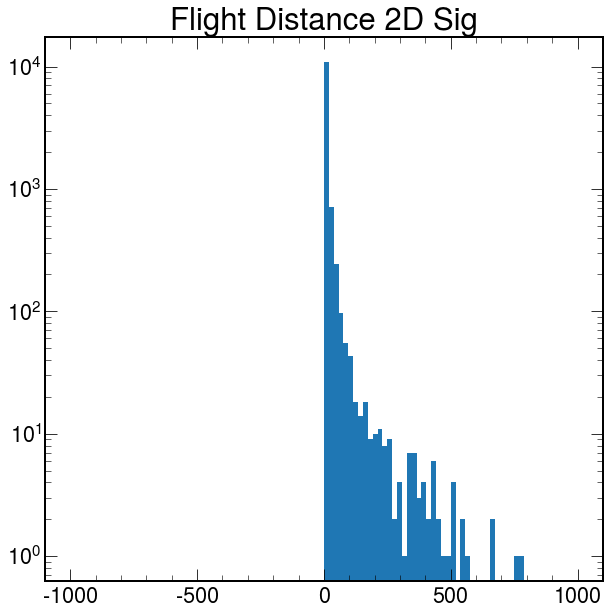

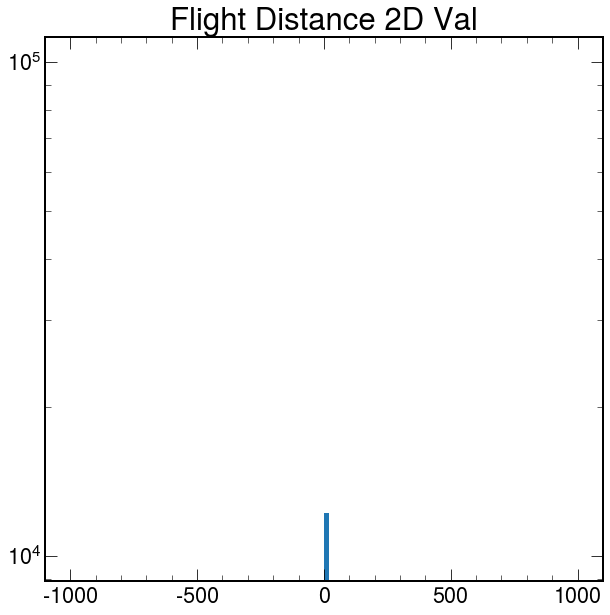

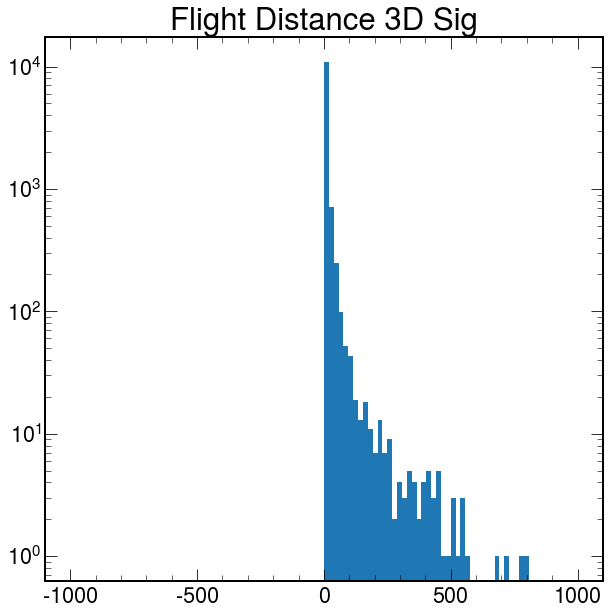

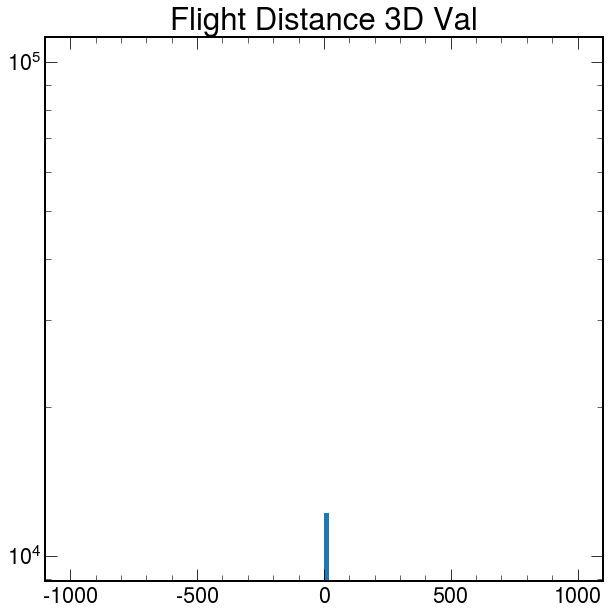

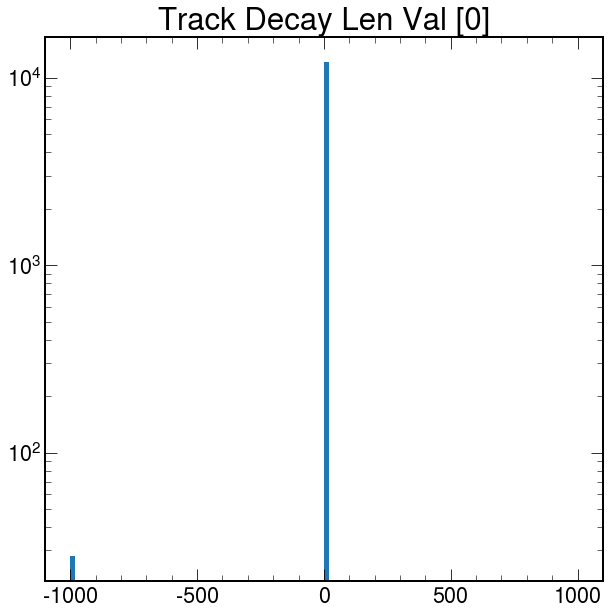

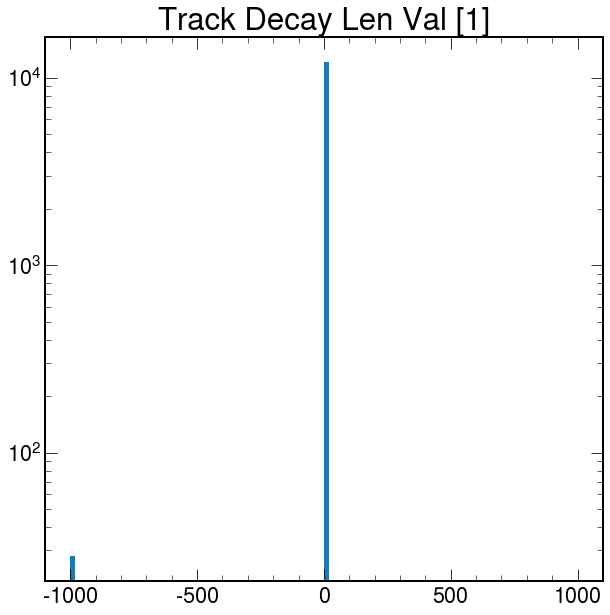

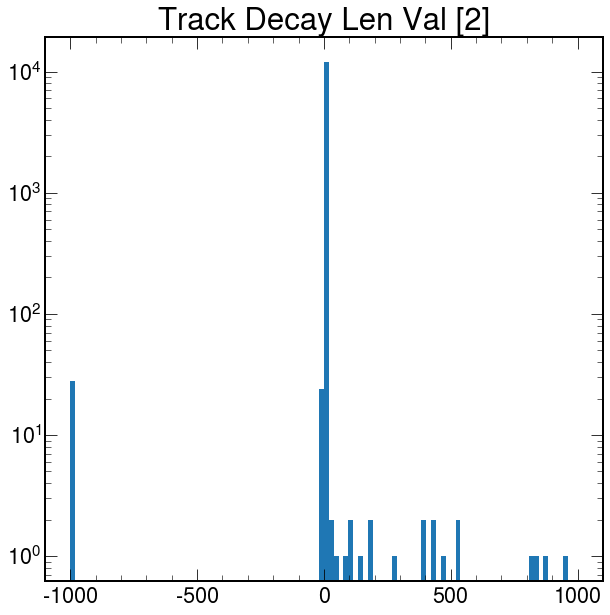

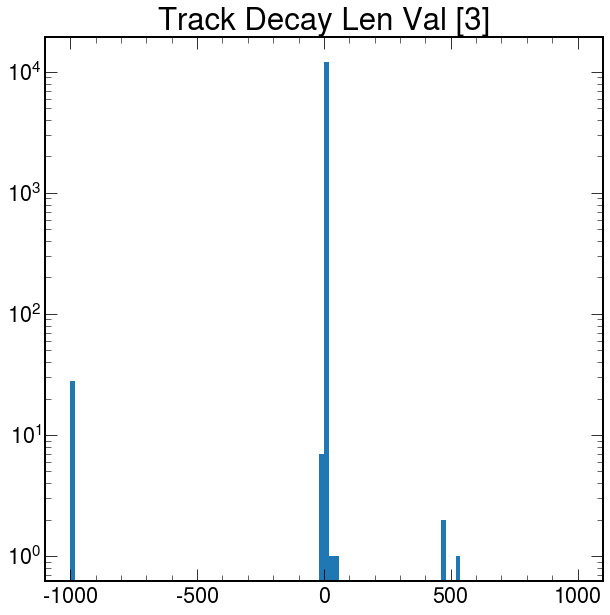

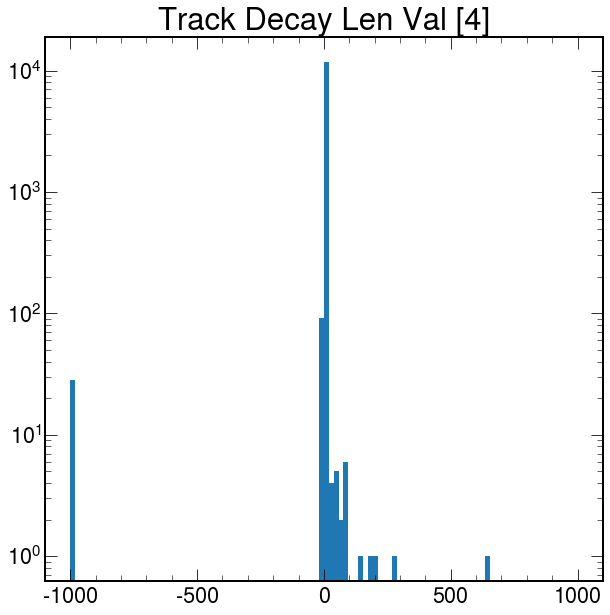

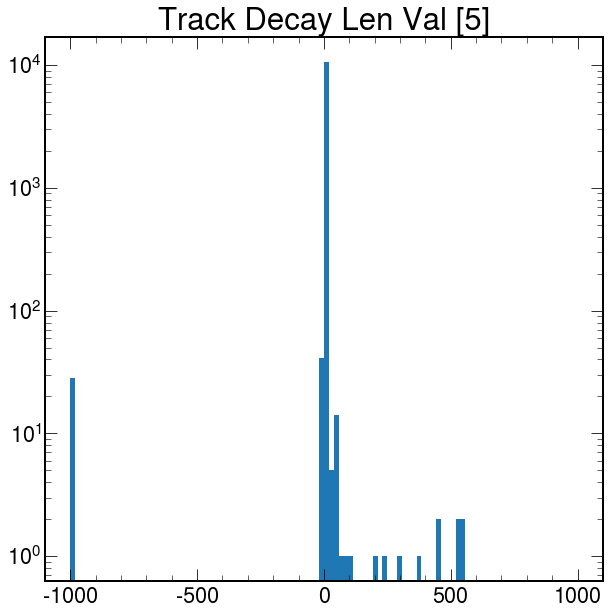

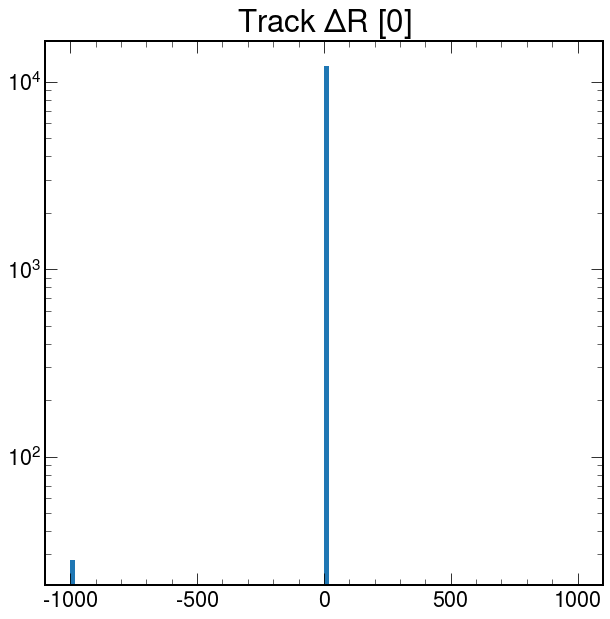

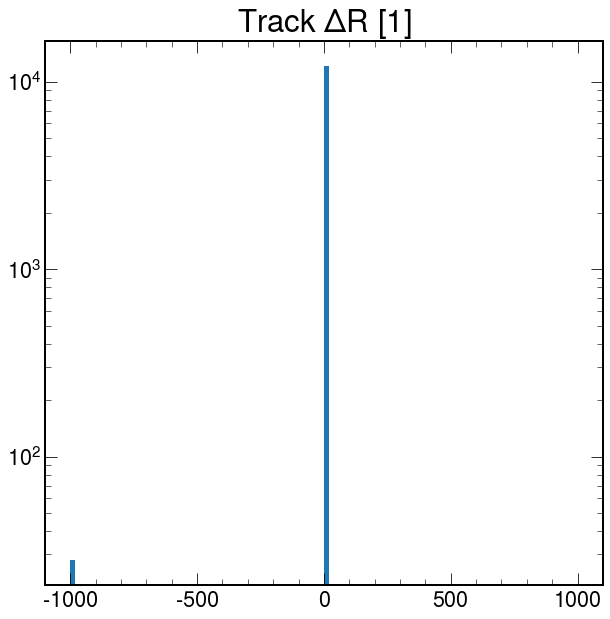

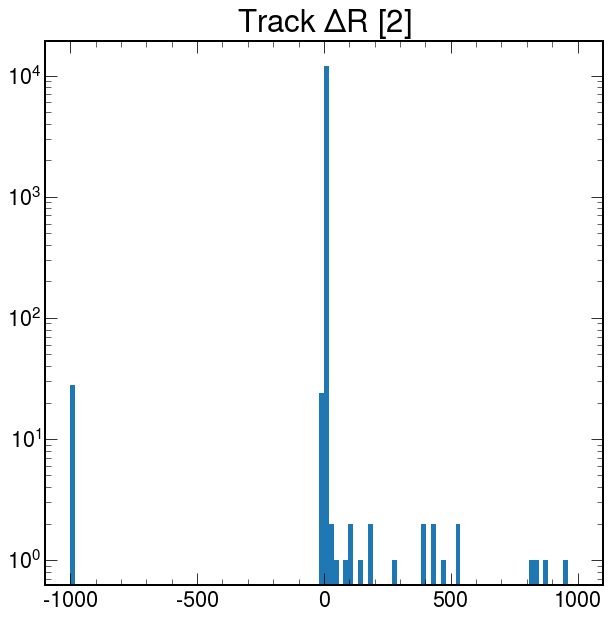

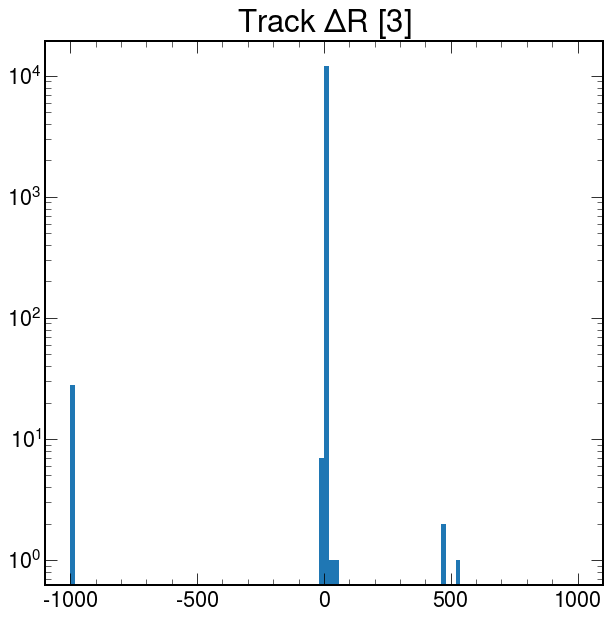

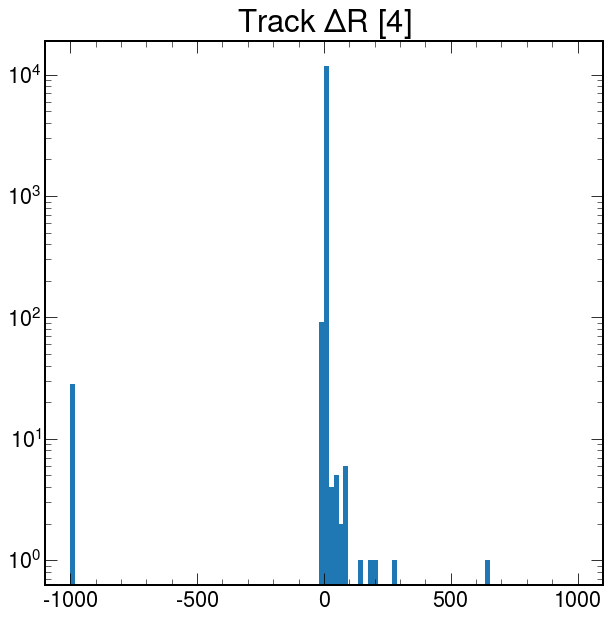

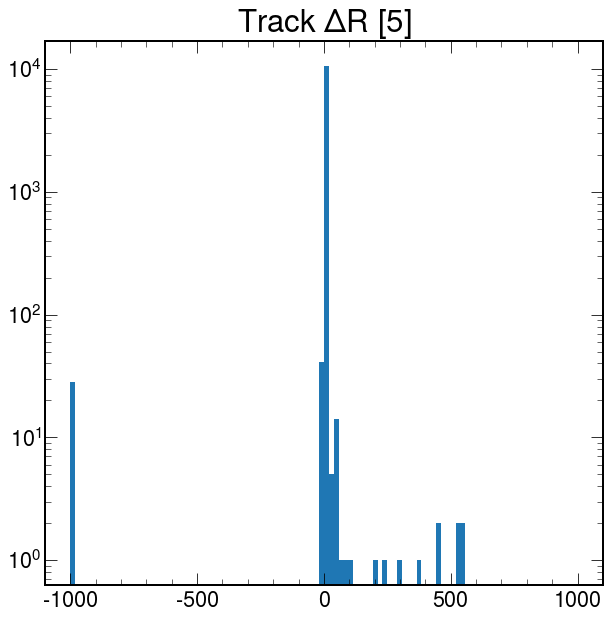

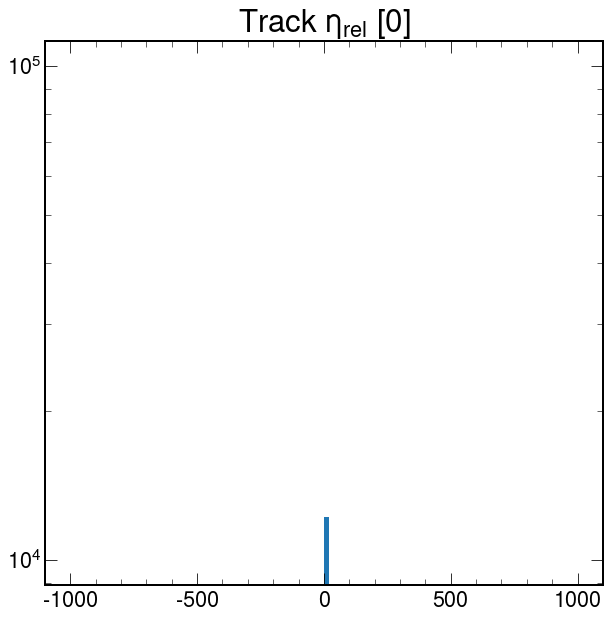

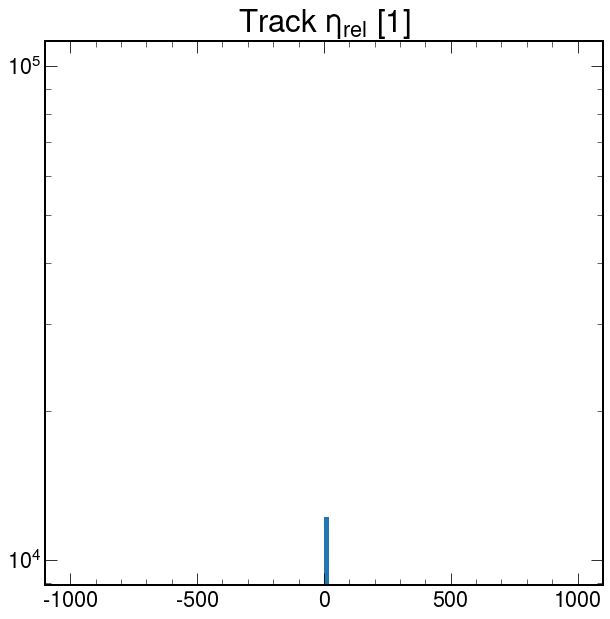

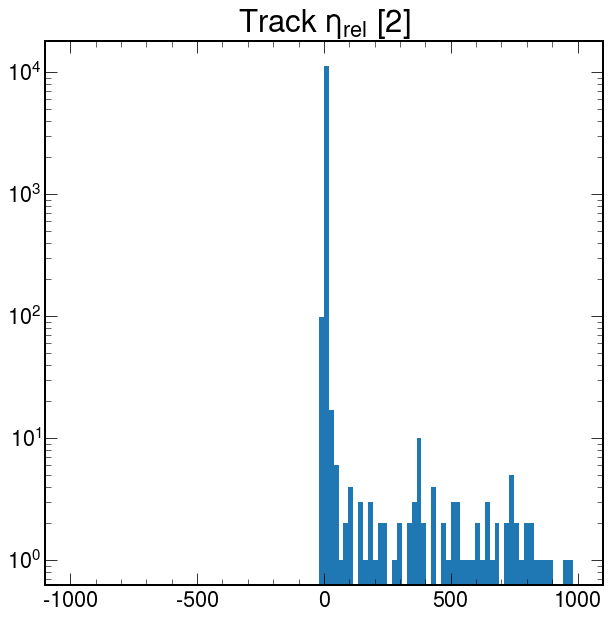

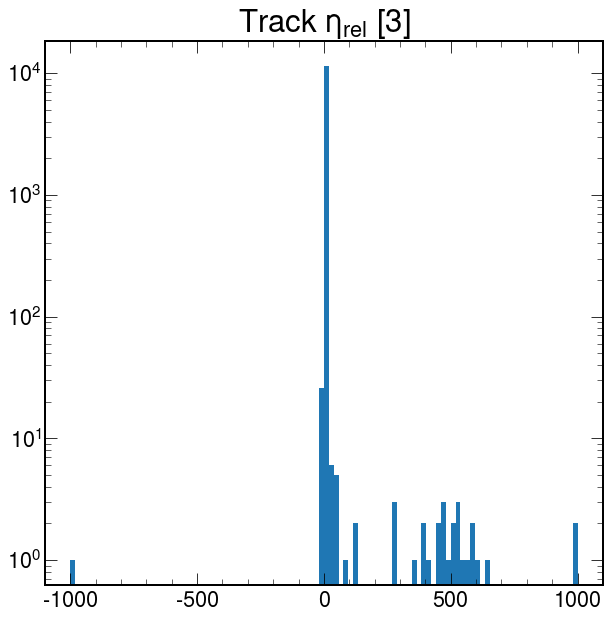

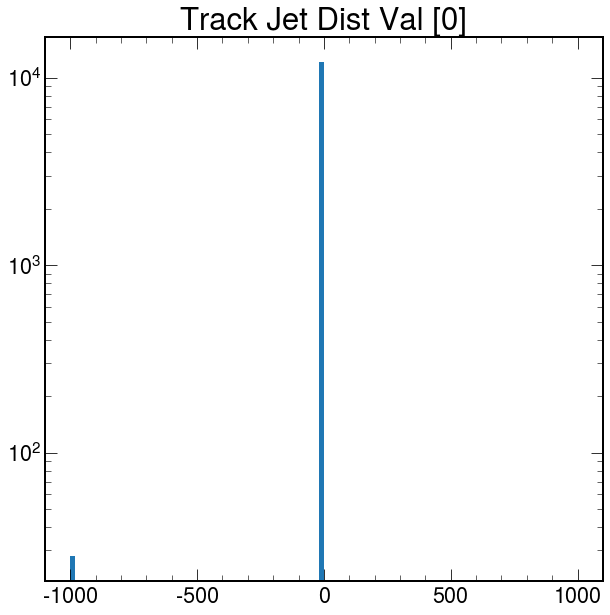

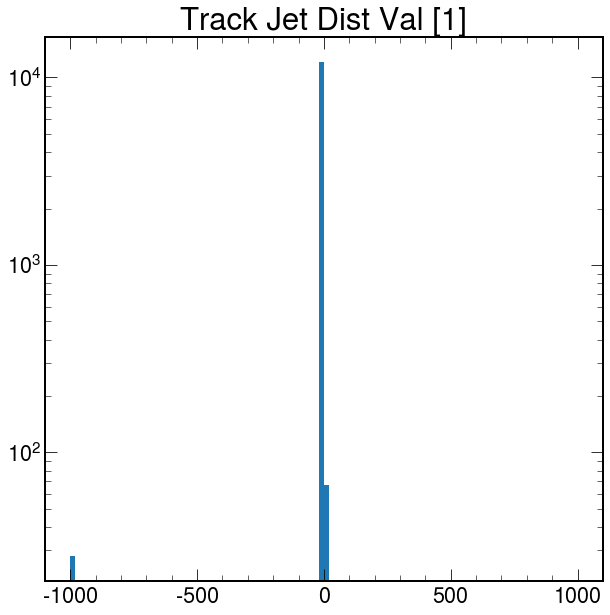

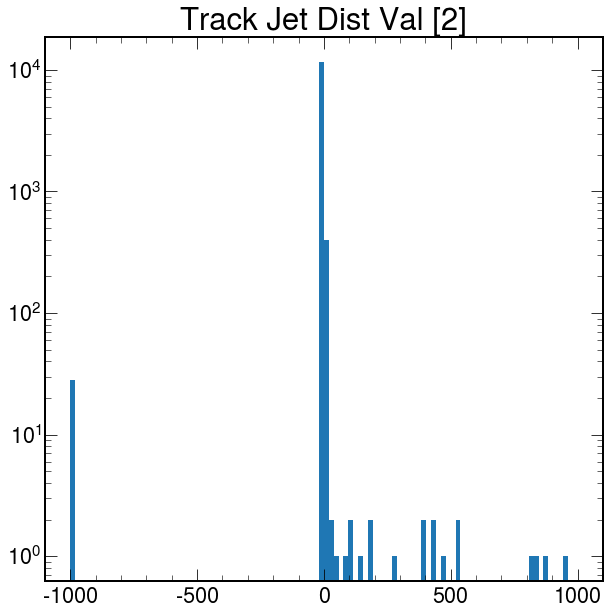

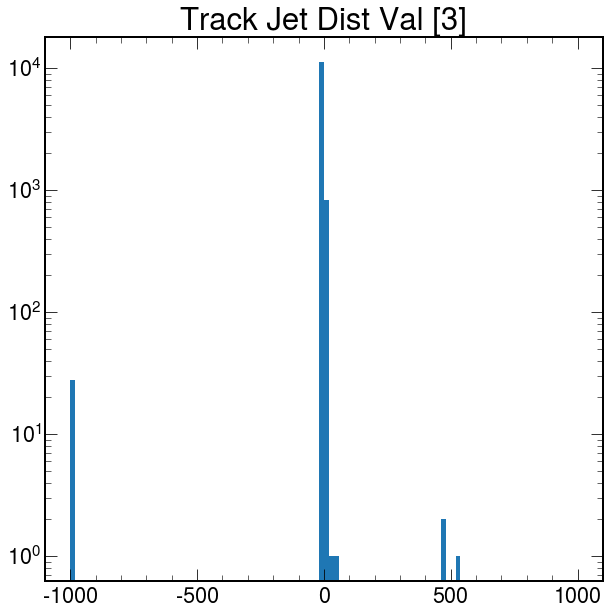

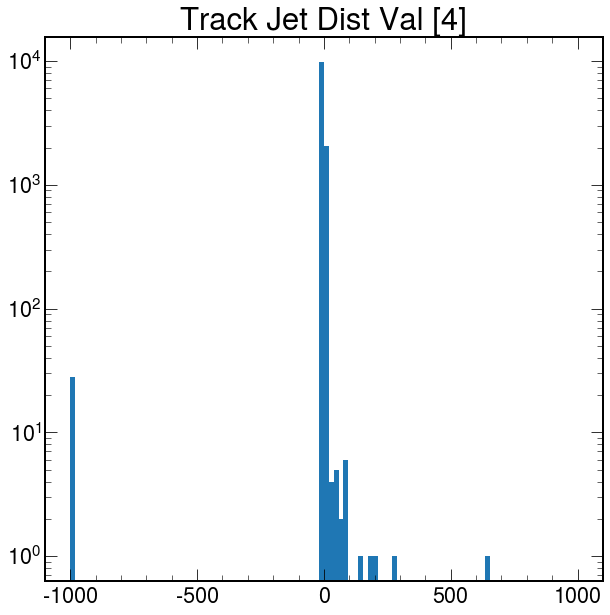

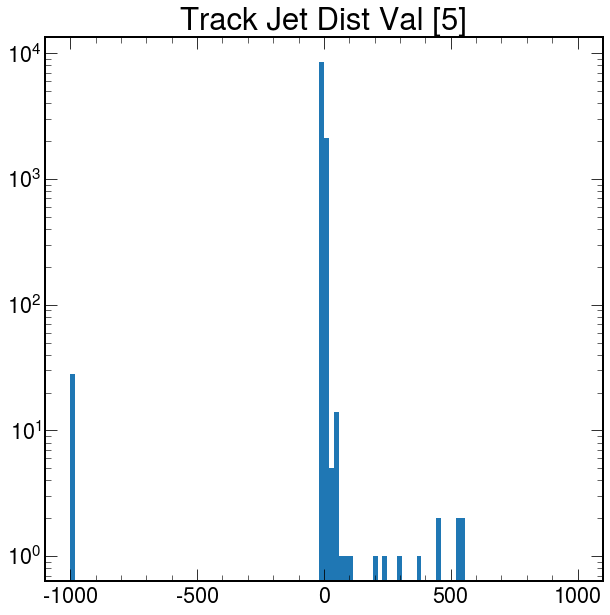

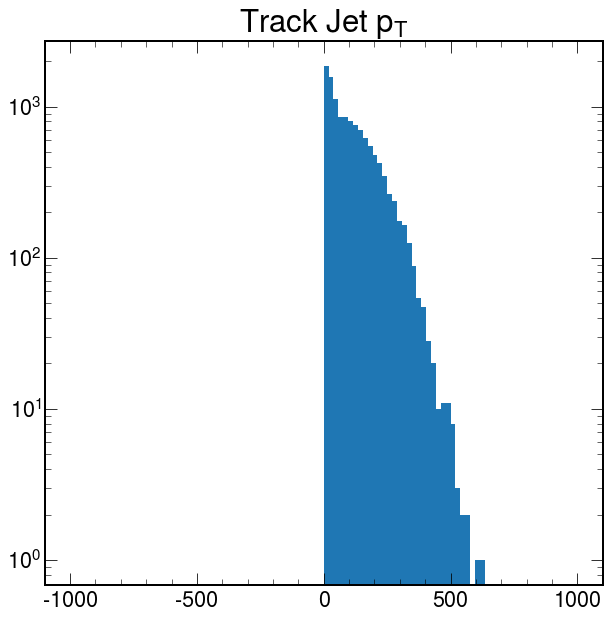

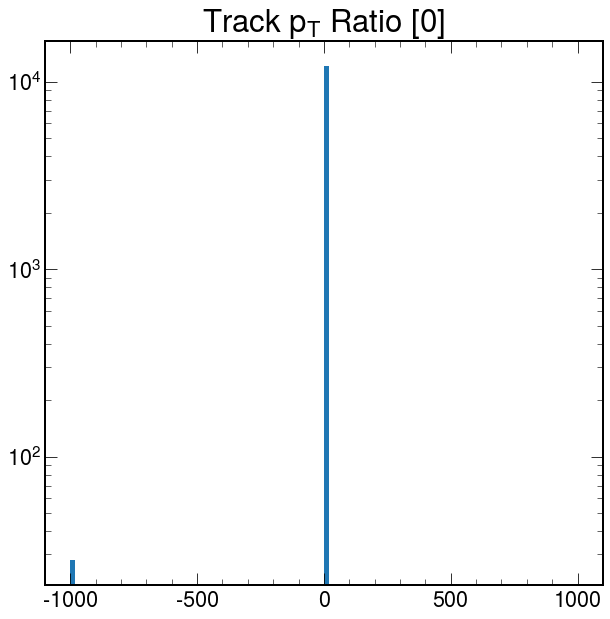

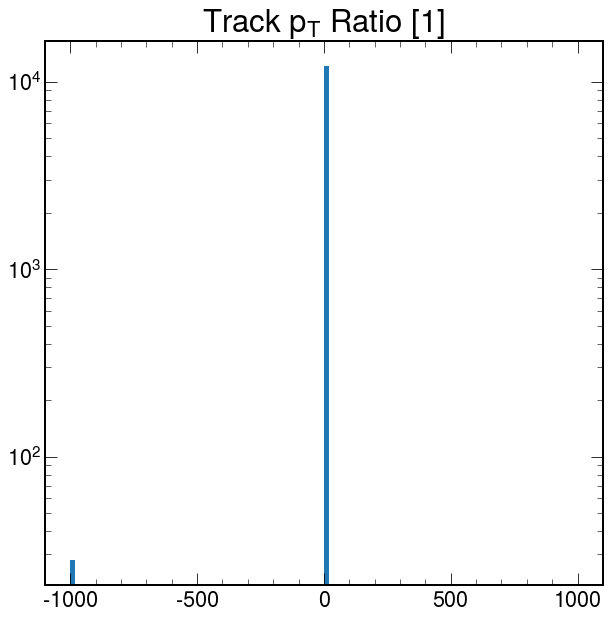

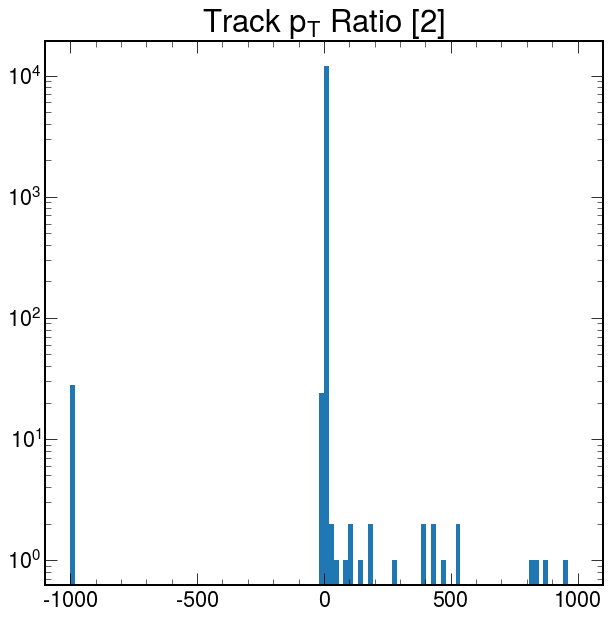

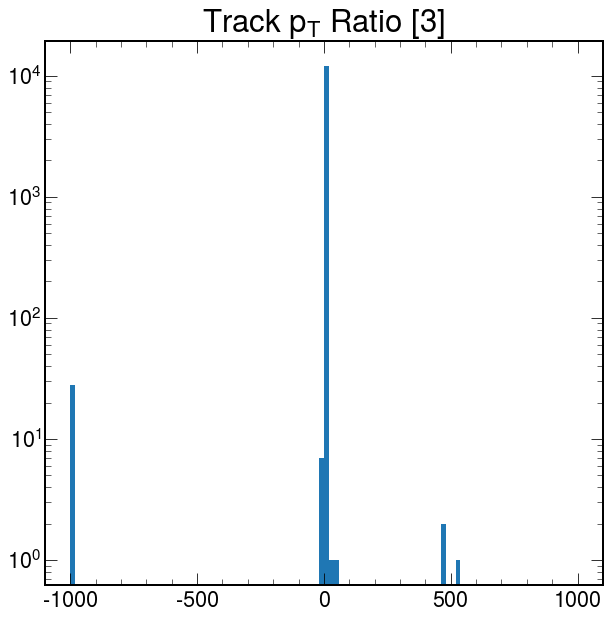

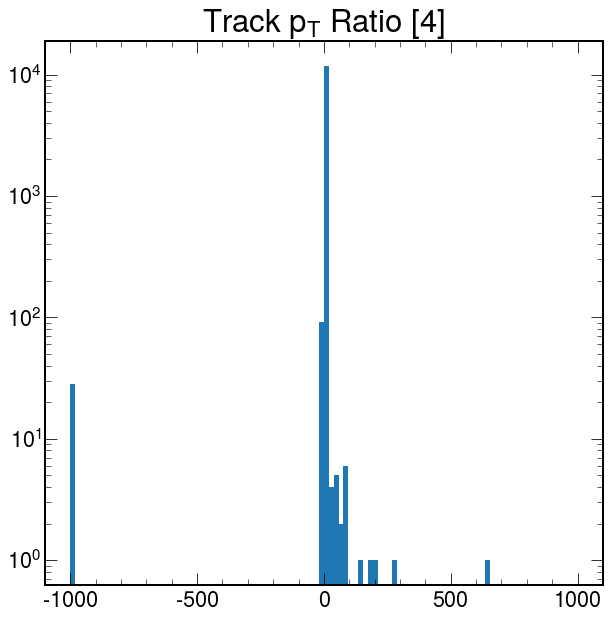

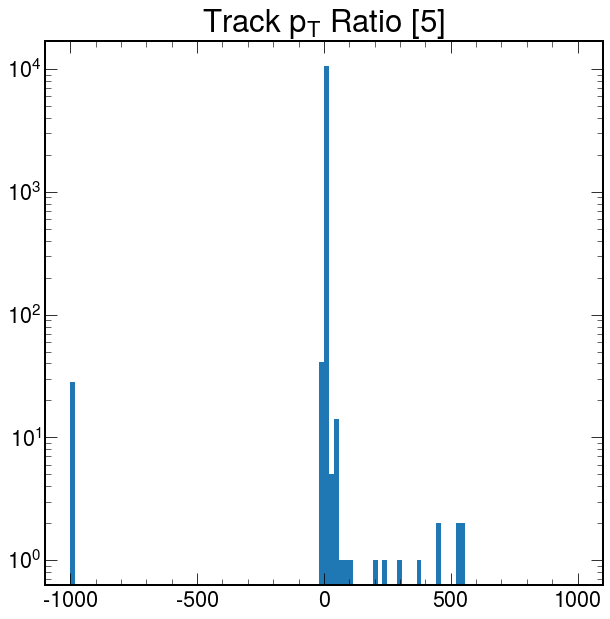

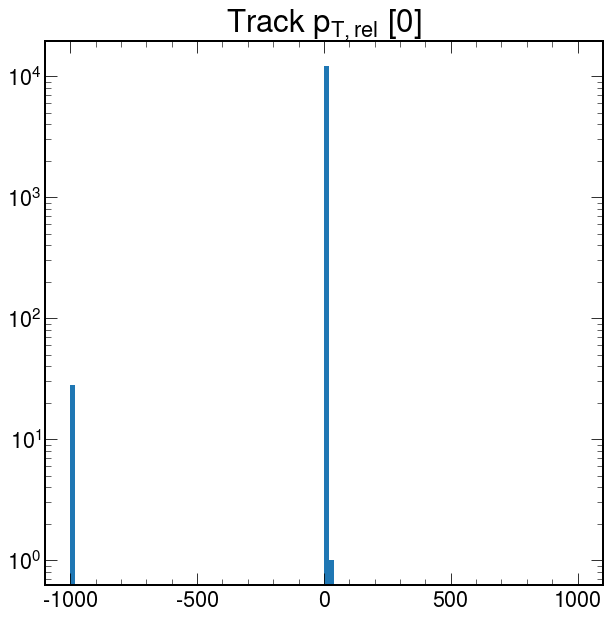

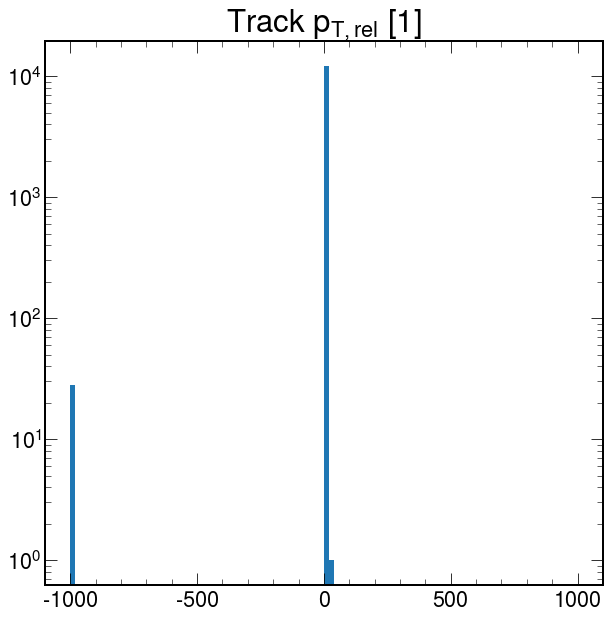

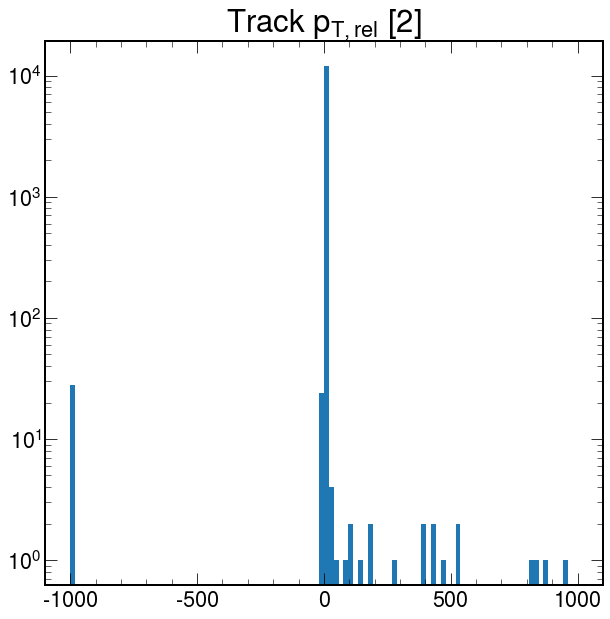

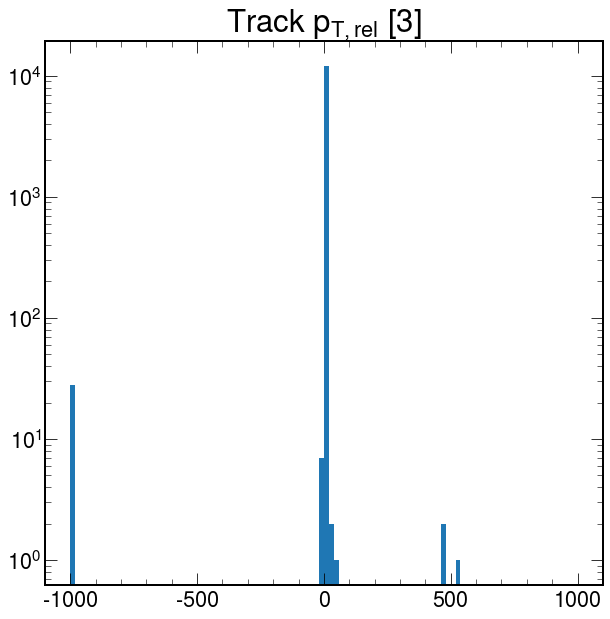

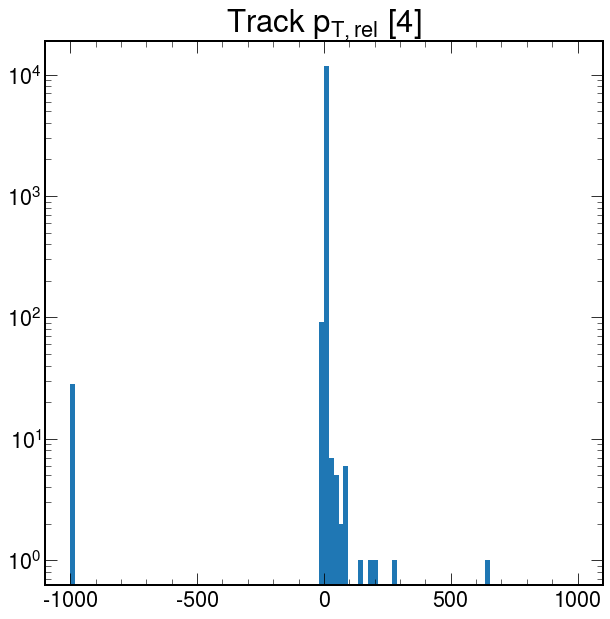

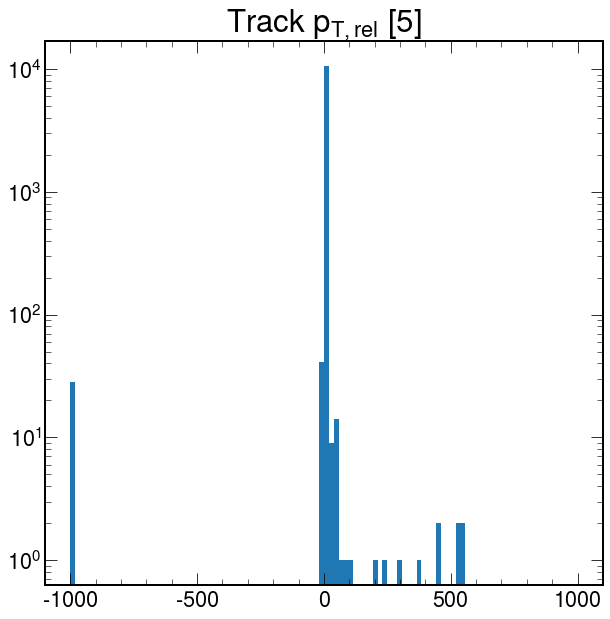

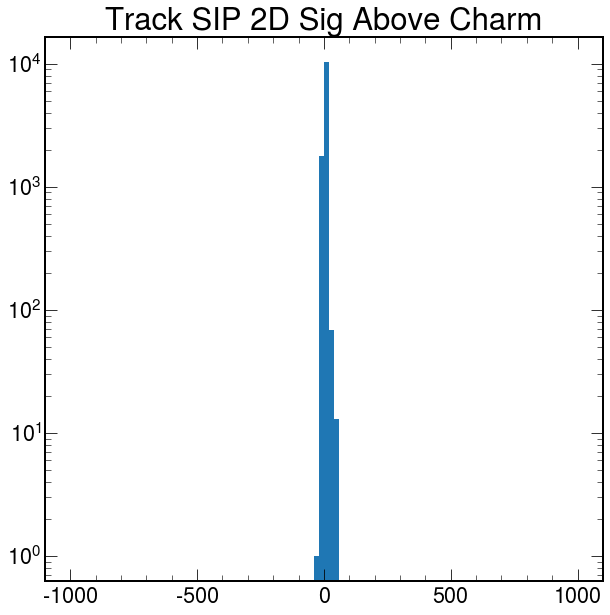

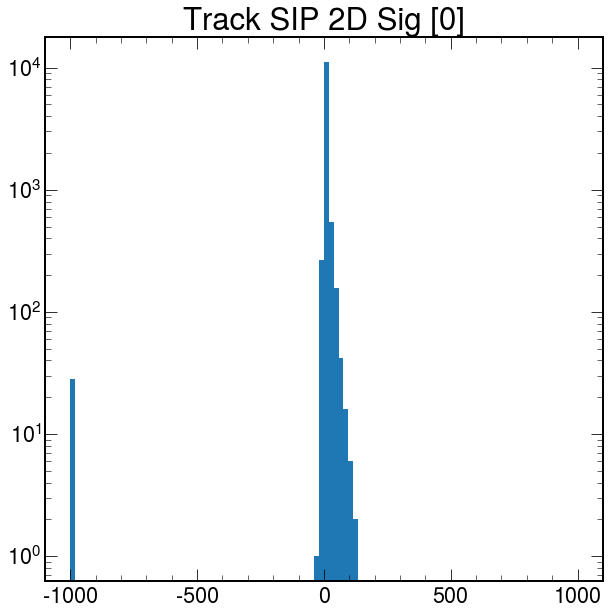

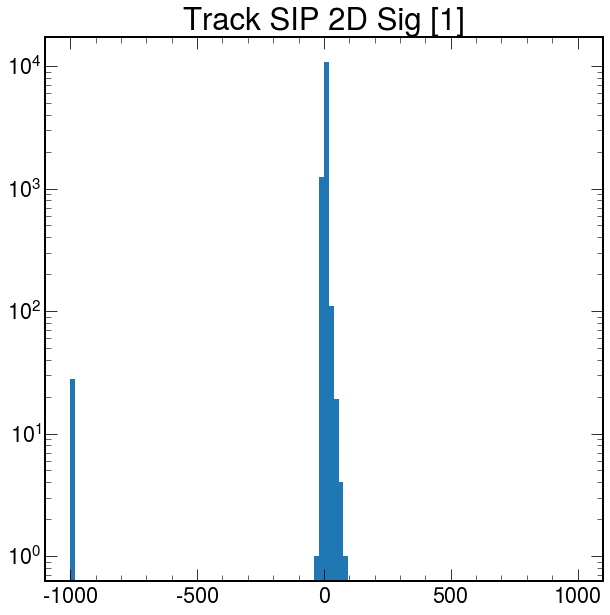

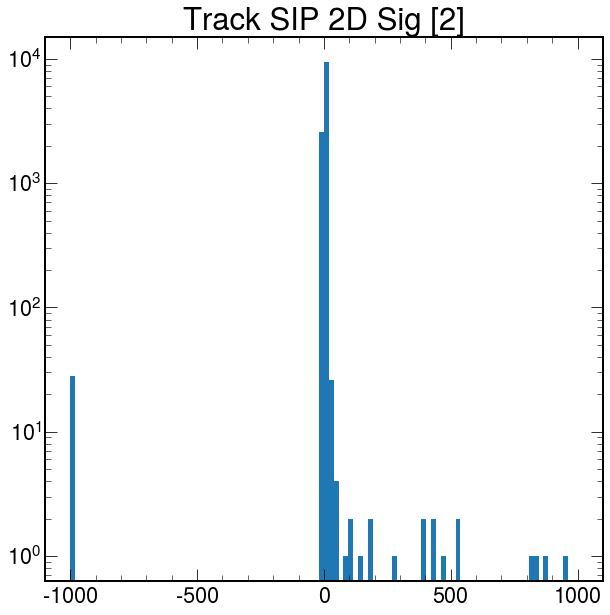

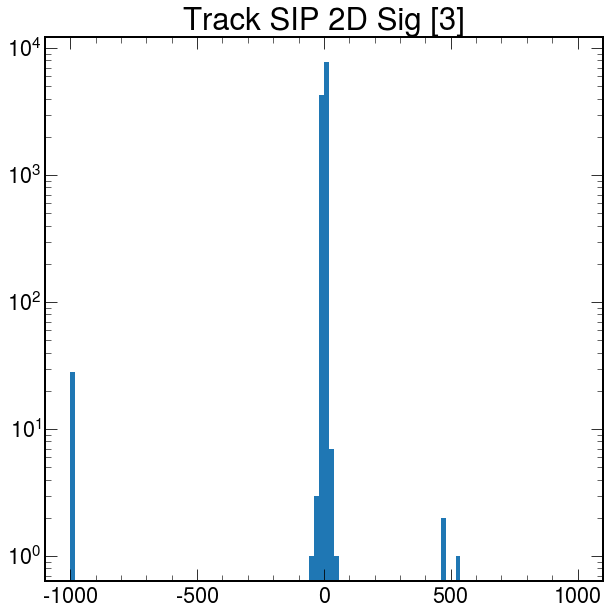

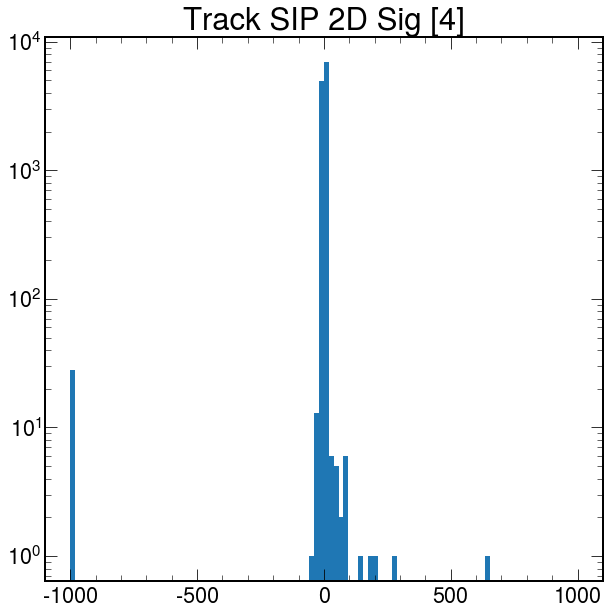

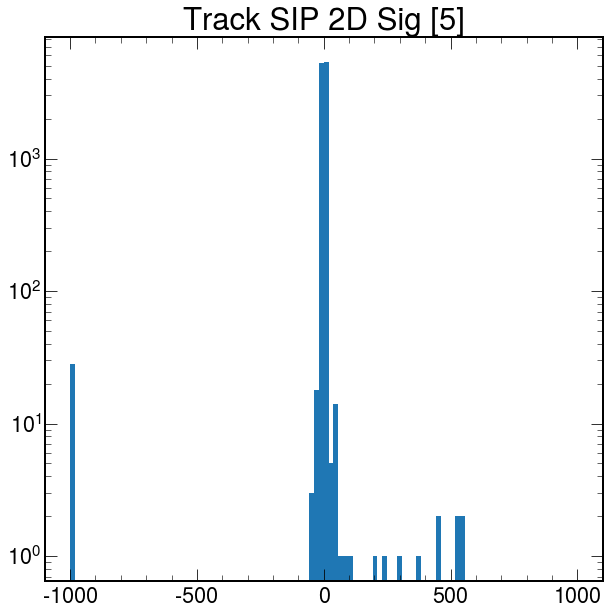

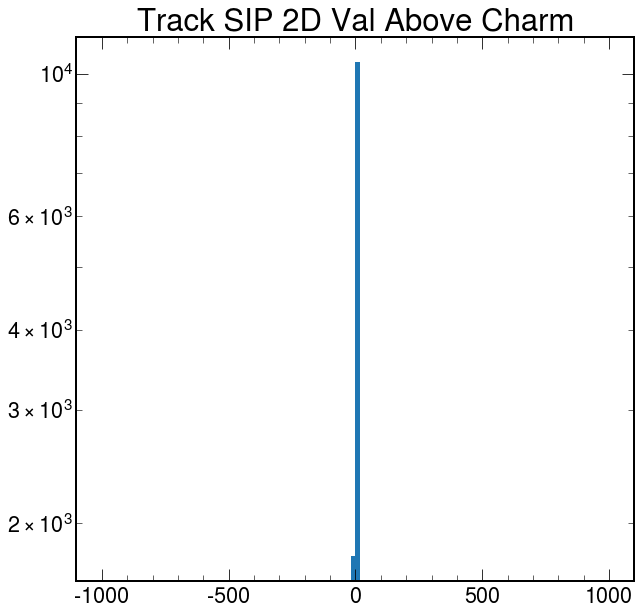

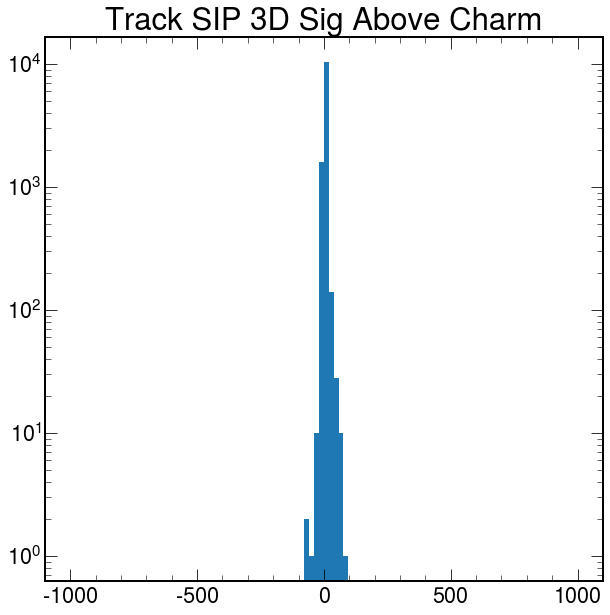

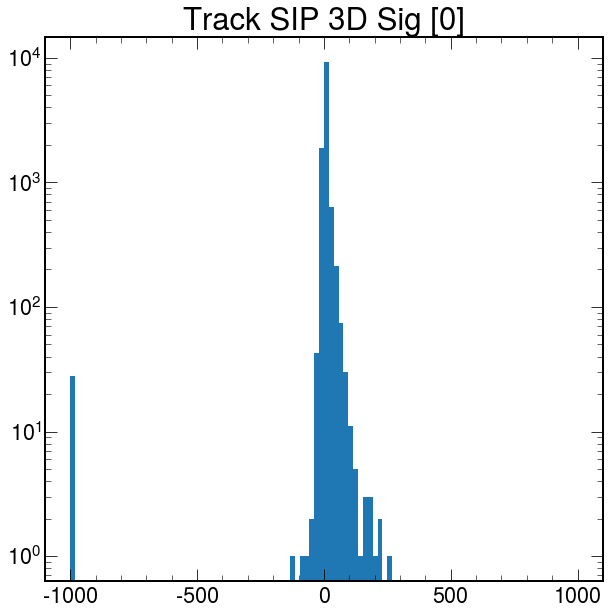

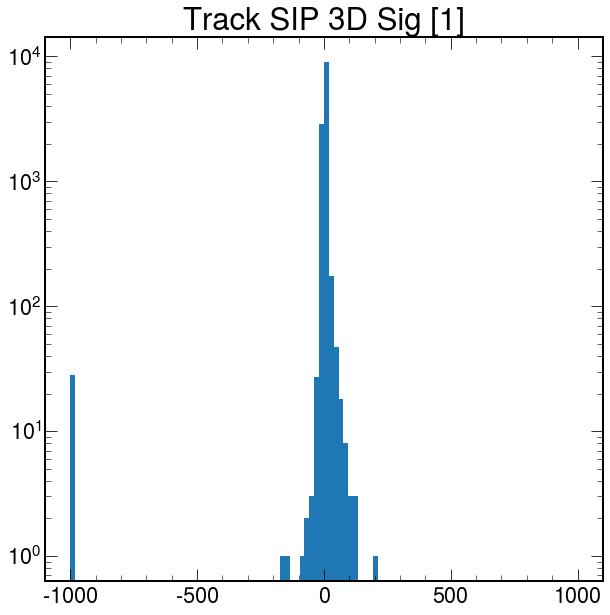

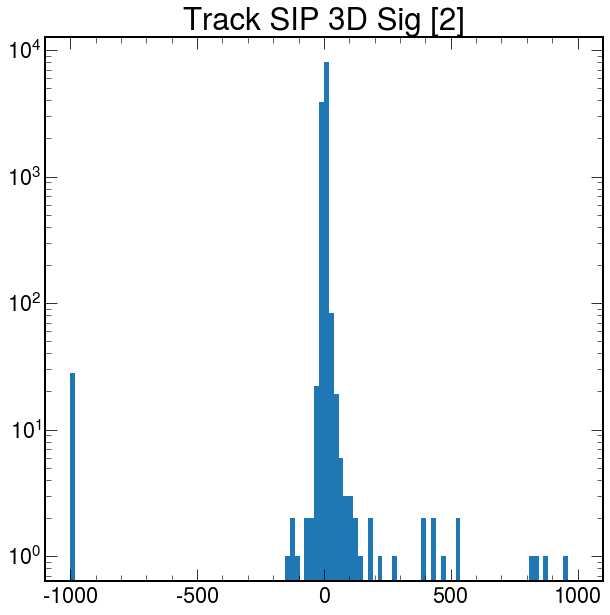

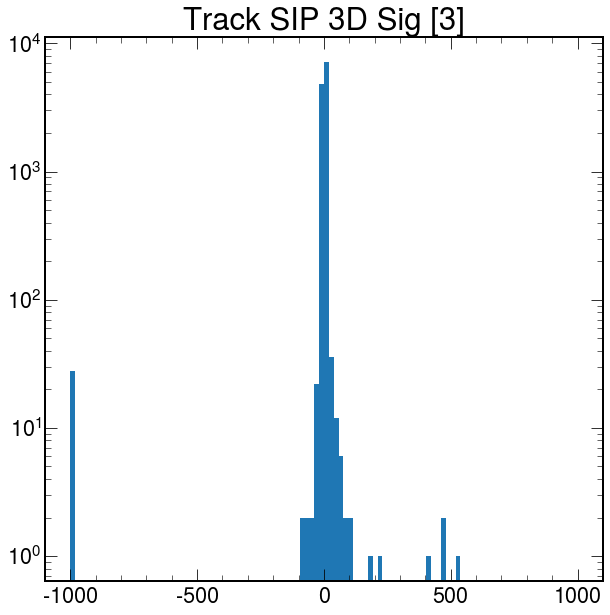

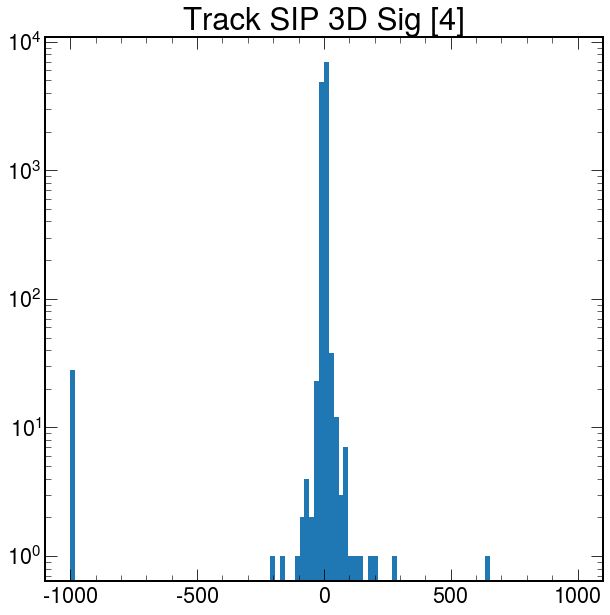

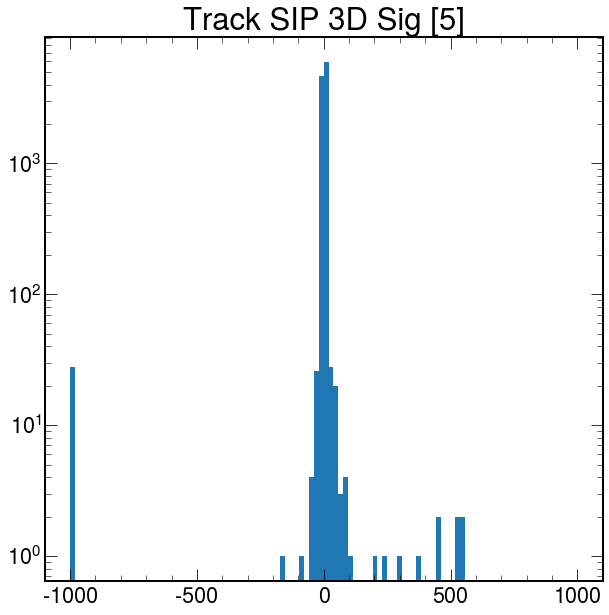

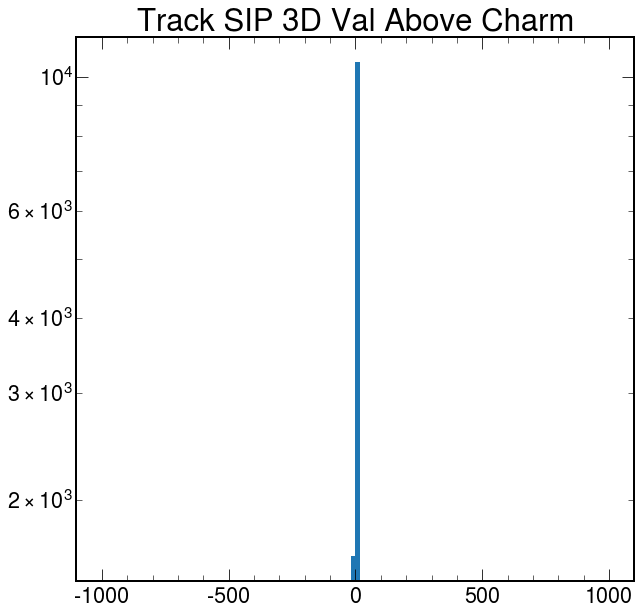

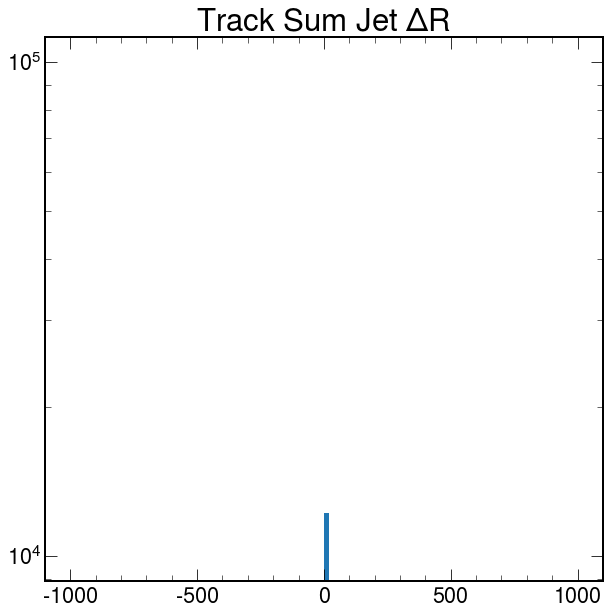

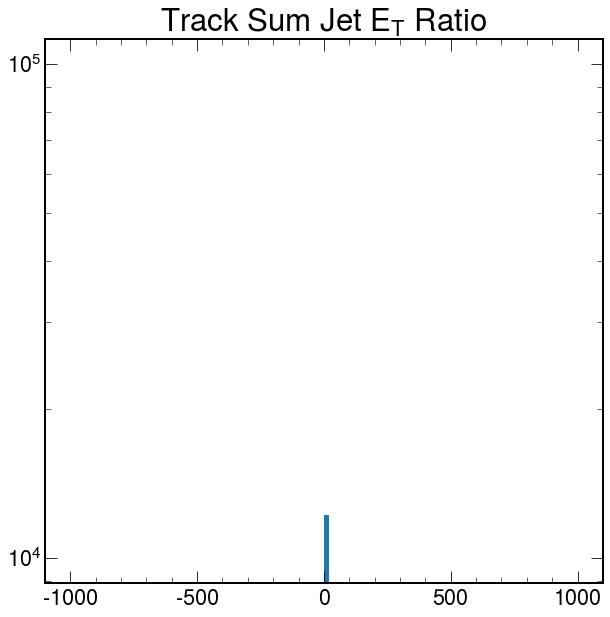

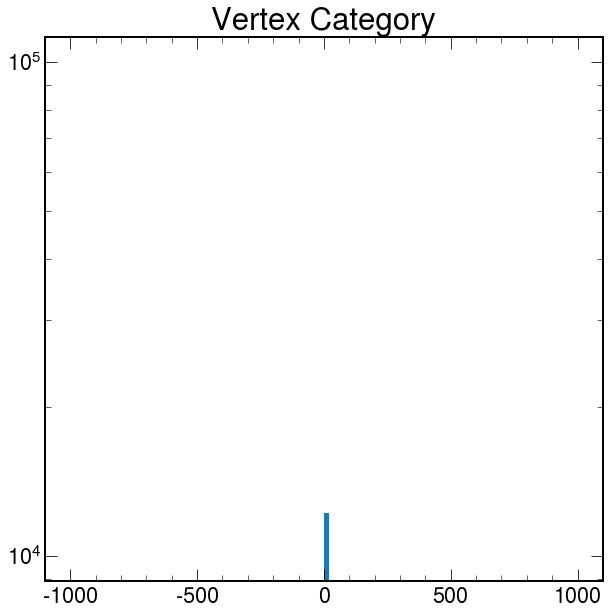

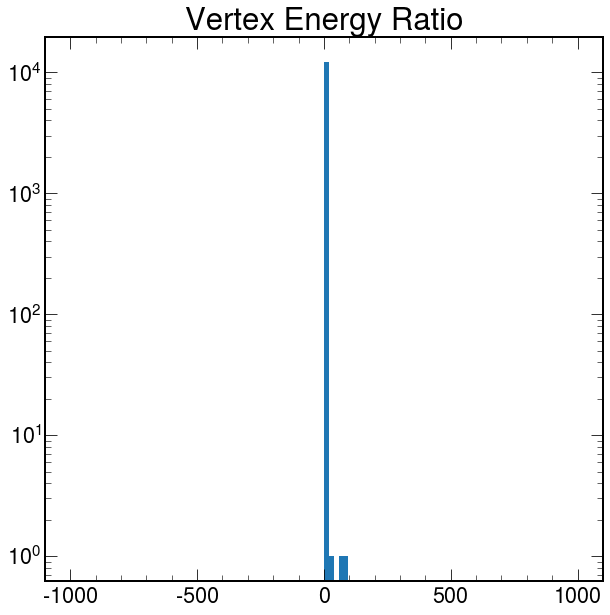

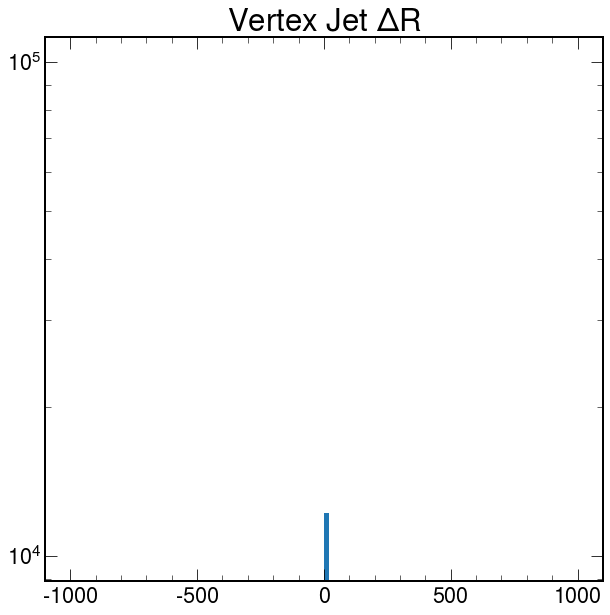

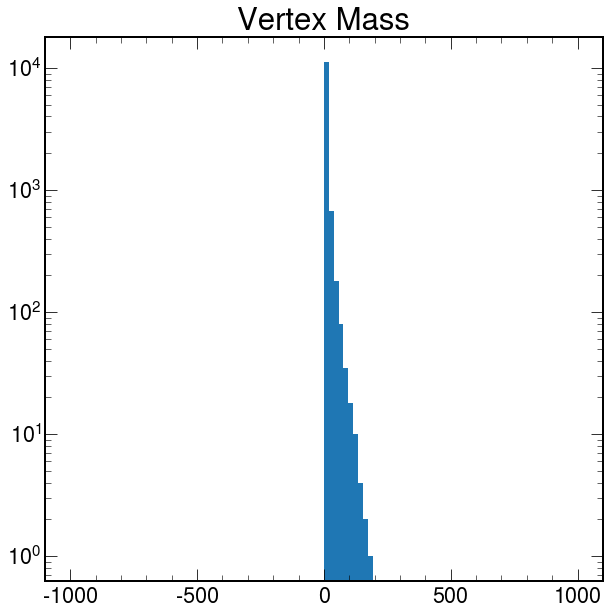

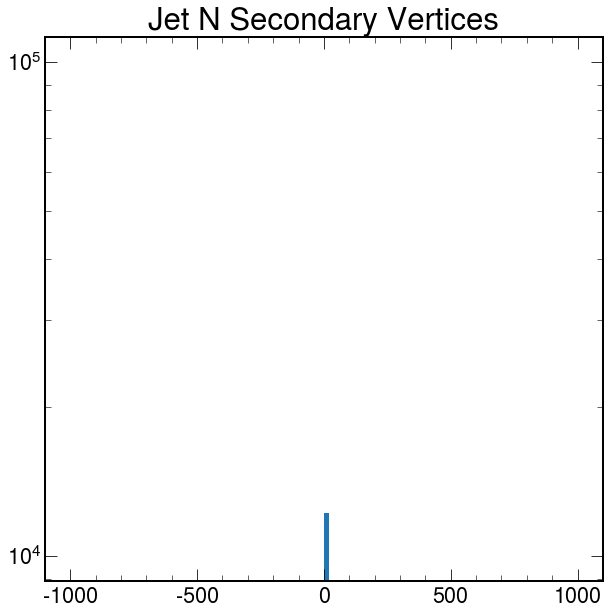

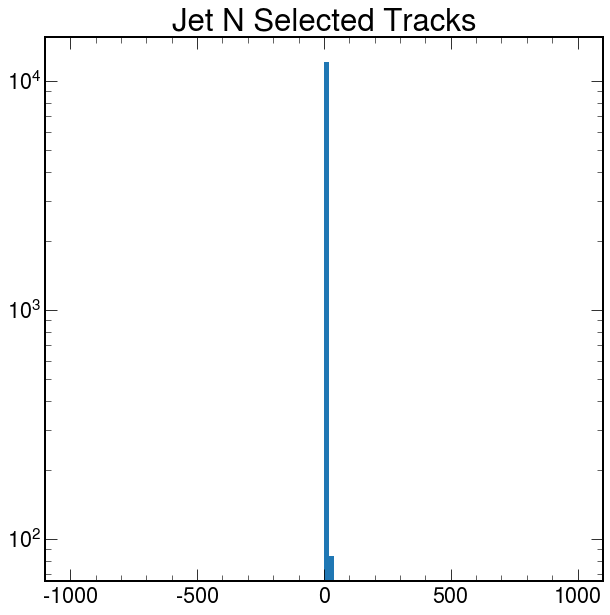

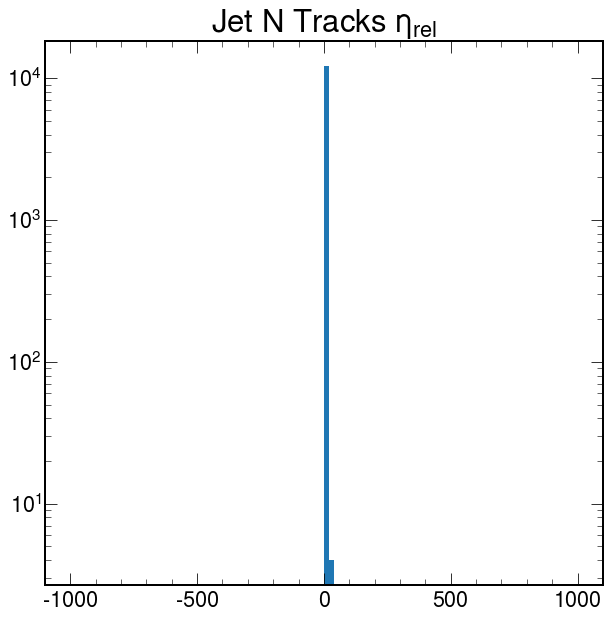

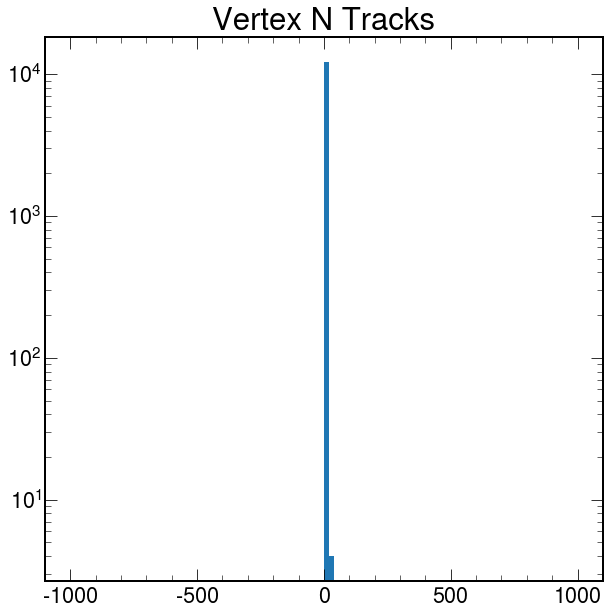

In [21]:
for var in range(67):
    plt.hist(dataset_step1[:,var], bins=104, log=True, range=(-1000,1000))
    plt.title(display_names[var])
    plt.show()

## Hopefully better Part 2 of the file cleaning

Idea: only use the values for track variables that come from jets with at least this number of tracks in the jet (Jet N Selected Tracks --> variable index 64)

Also: for eta rel, there is a similar quantity that gives the number of tracks for which eta rel has been computed (Jet N Tracks eta_rel --> variable index 65)

In [29]:
dataset_step2 = dataset_step1.copy()
for track0_vars in [6,12,22,29,35,42,50]:
    dataset_step2[:,track0_vars][dataset_step1[:,64] <= 0] = -999
for track0_1_vars in [7,13,23,30,36,43,51]:
    dataset_step2[:,track0_1_vars][dataset_step1[:,64] <= 1] = -999
for track01_2_vars in [8,14,24,31,37,44,52]:
    dataset_step2[:,track01_2_vars][dataset_step1[:,64] <= 2] = -999
for track012_3_vars in [9,15,25,32,38,45,53]:
    dataset_step2[:,track012_3_vars][dataset_step1[:,64] <= 3] = -999
for track0123_4_vars in [10,16,26,33,39,46,54]:
    dataset_step2[:,track0123_4_vars][dataset_step1[:,64] <= 4] = -999
for track01234_5_vars in [11,17,27,34,40,47,55]:
    dataset_step2[:,track01234_5_vars][dataset_step1[:,64] <= 5] = -999
dataset_step2[:,18][dataset_step1[:,65] <= 0] = -999
dataset_step2[:,19][dataset_step1[:,65] <= 1] = -999
dataset_step2[:,20][dataset_step1[:,65] <= 2] = -999
dataset_step2[:,21][dataset_step1[:,65] <= 3] = -999

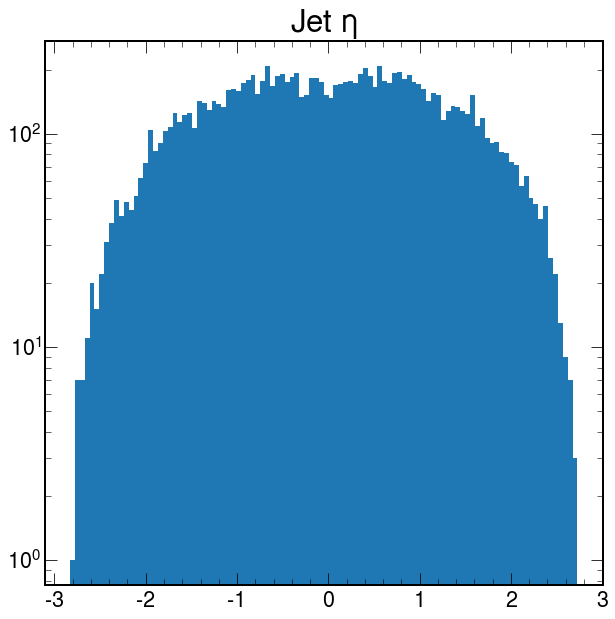

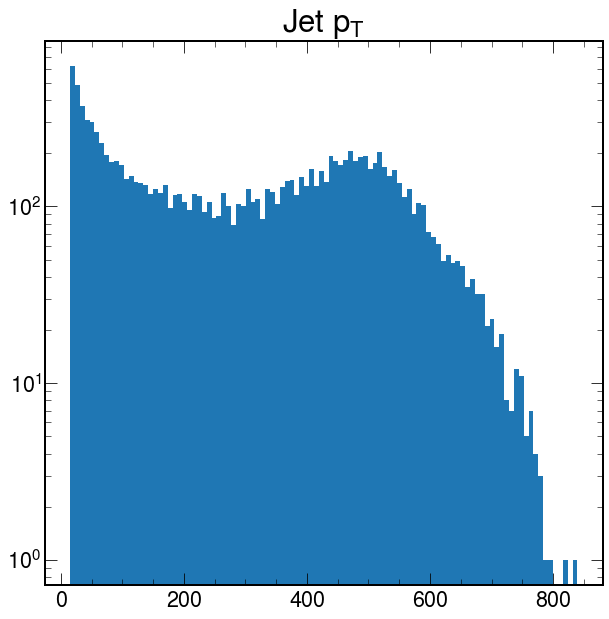

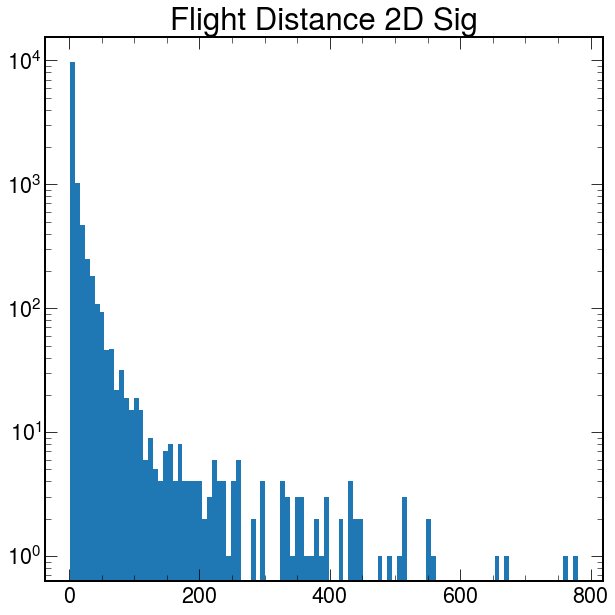

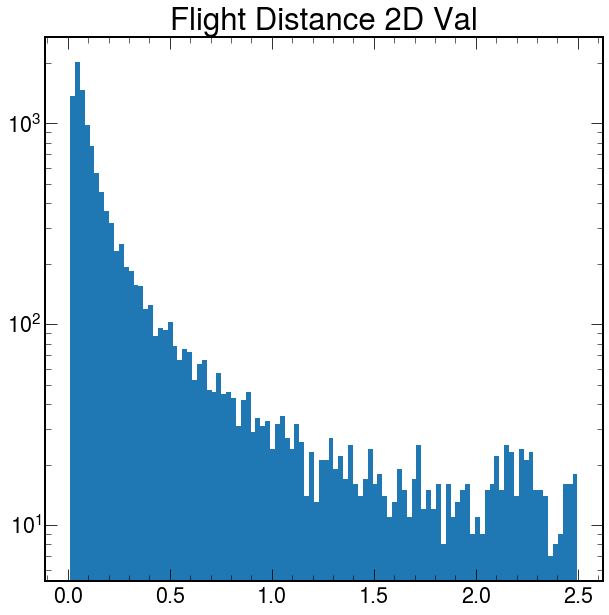

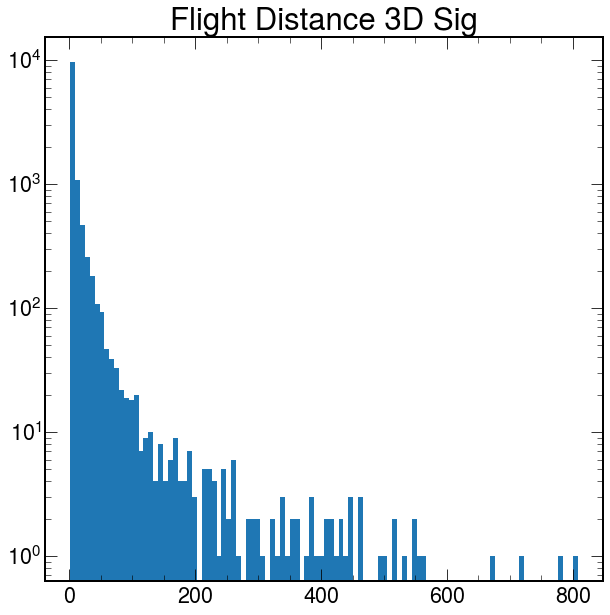

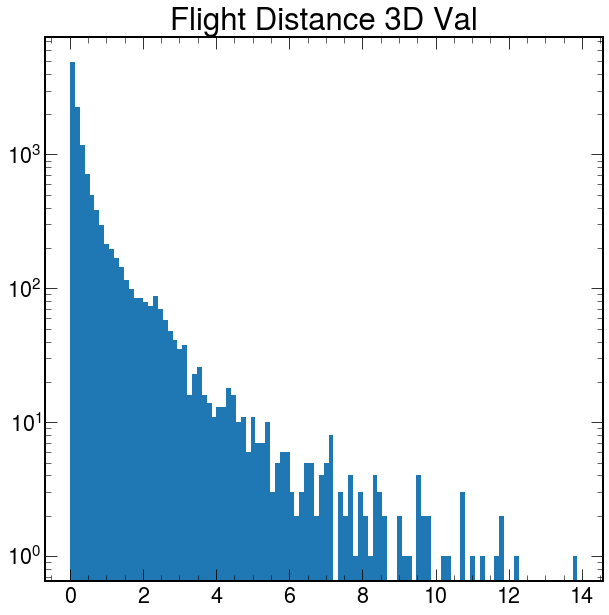

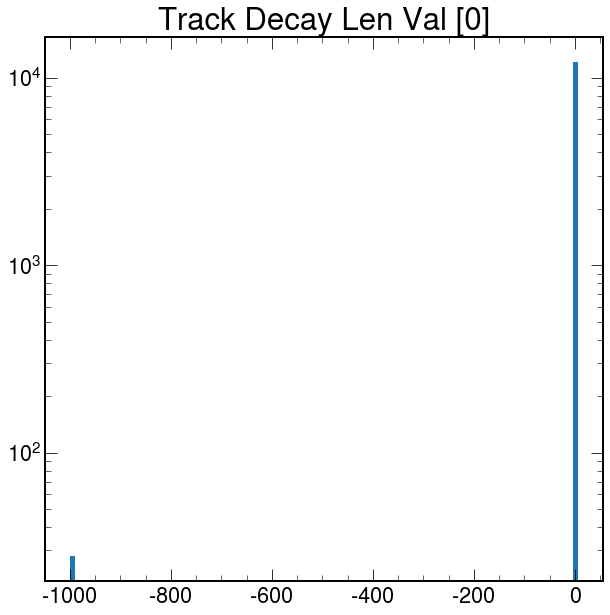

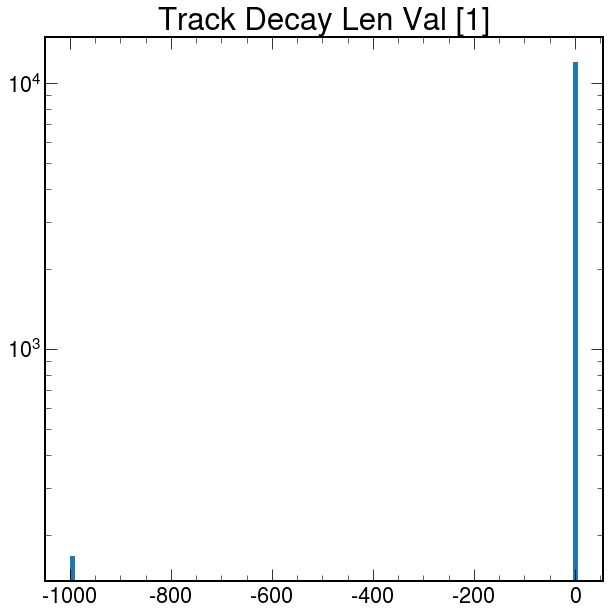

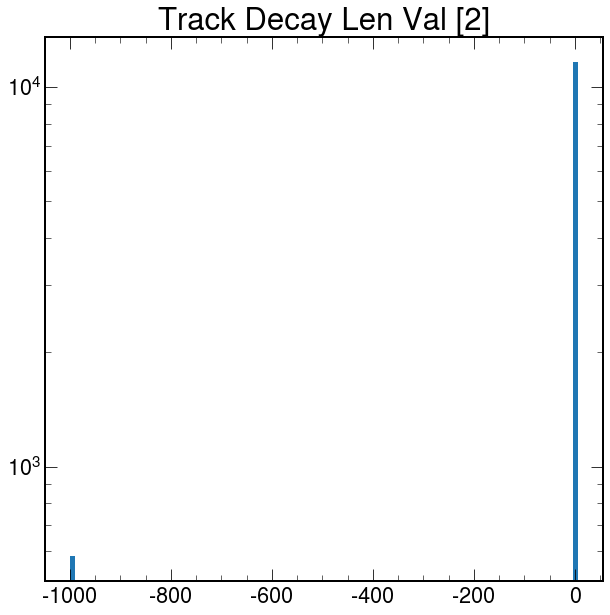

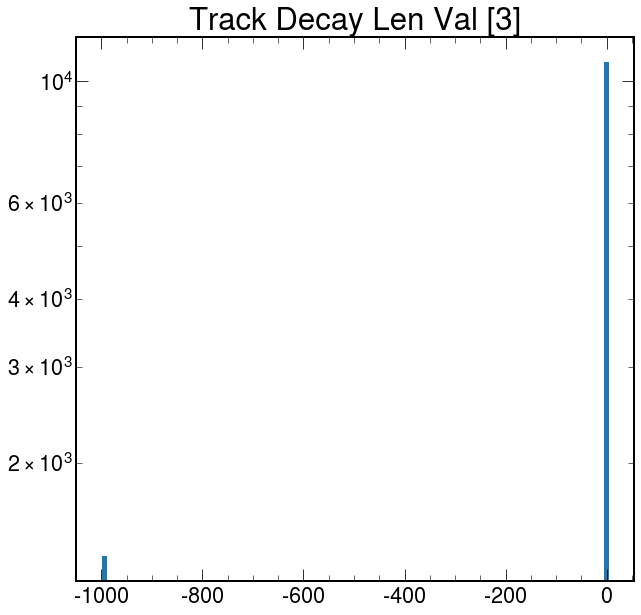

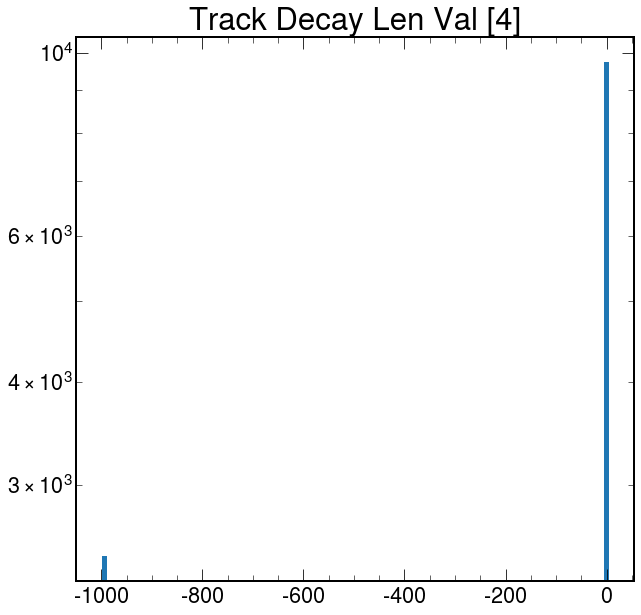

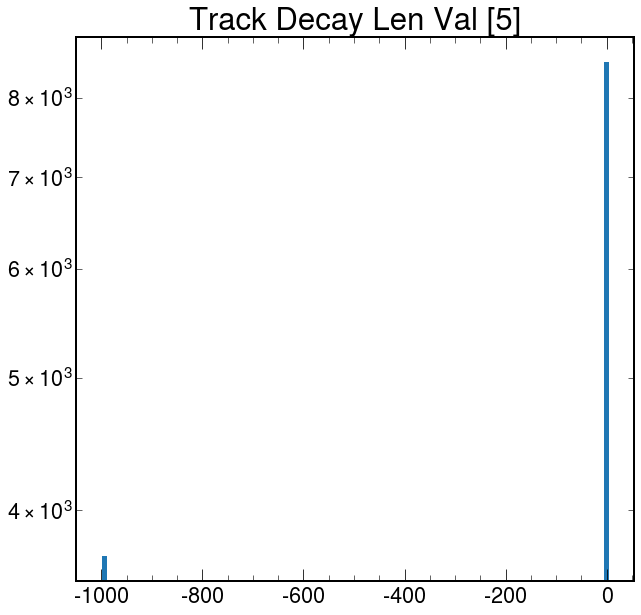

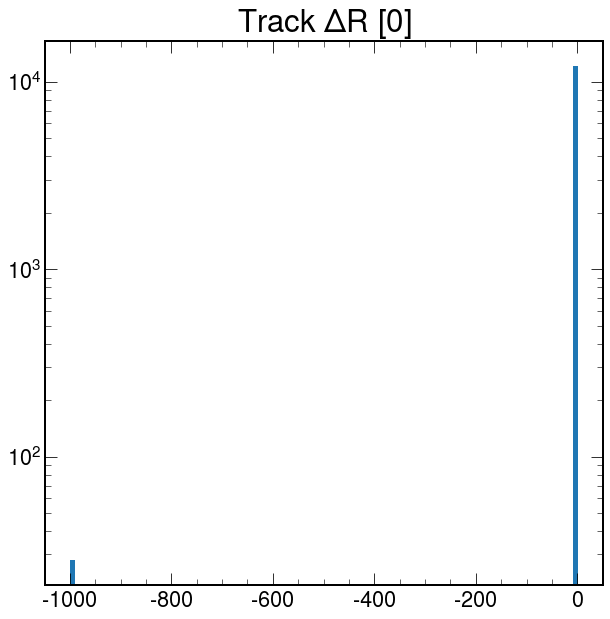

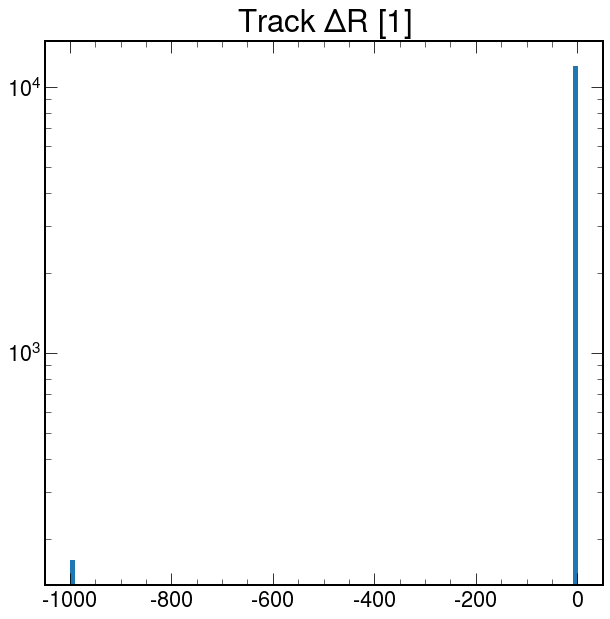

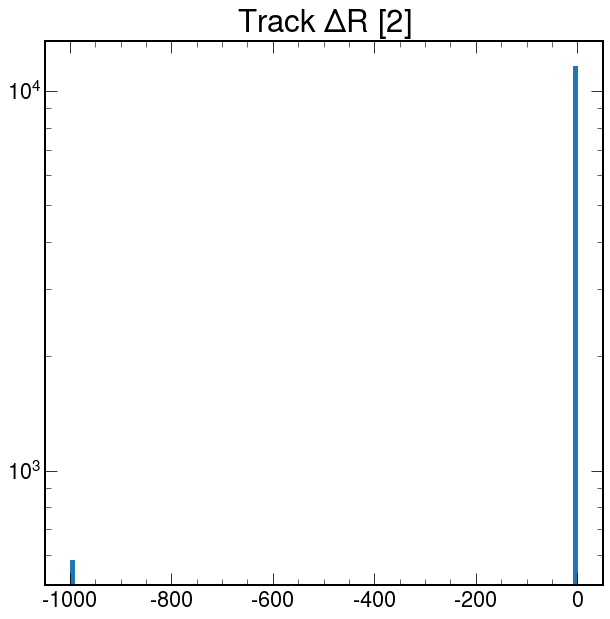

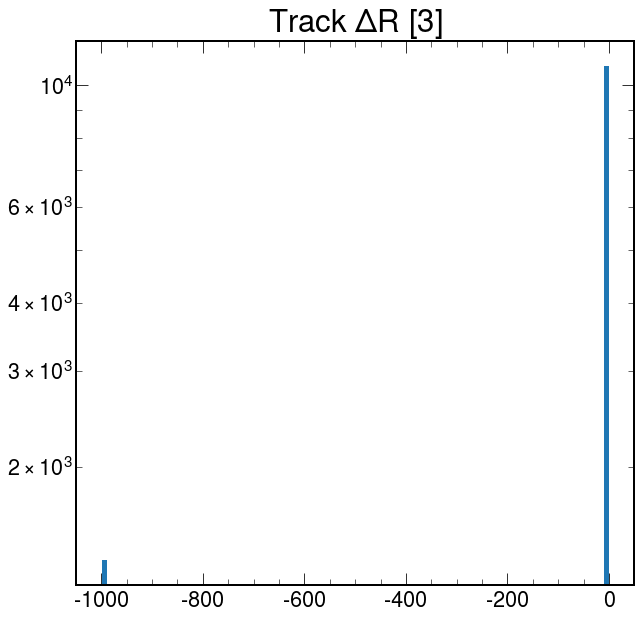

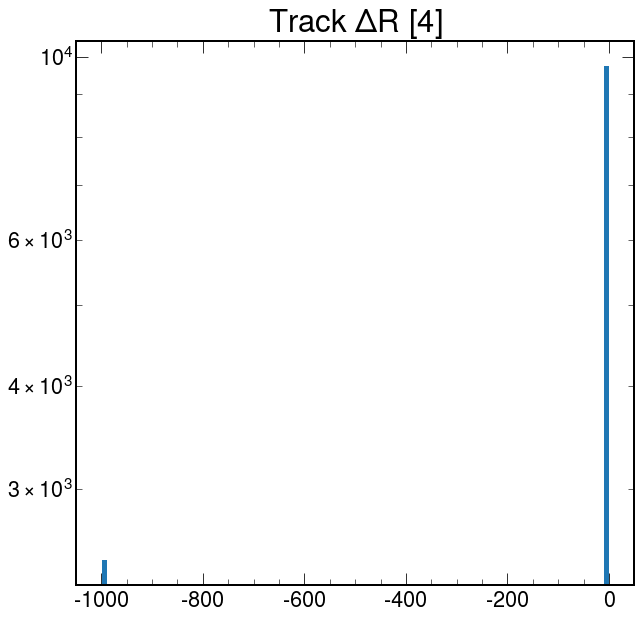

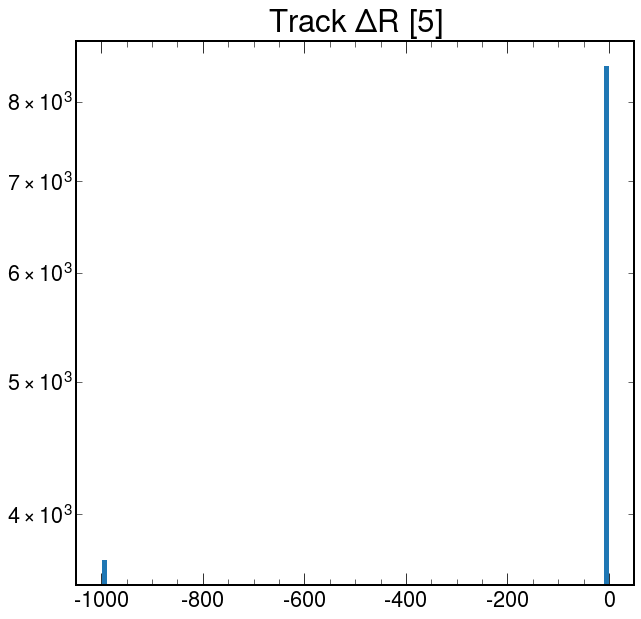

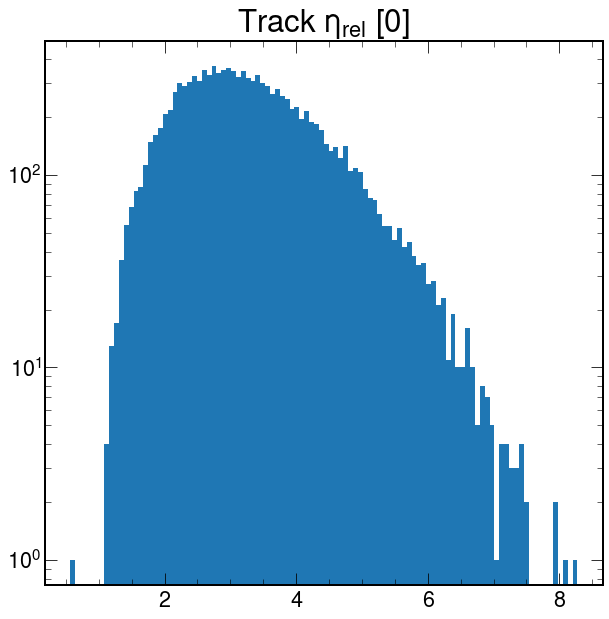

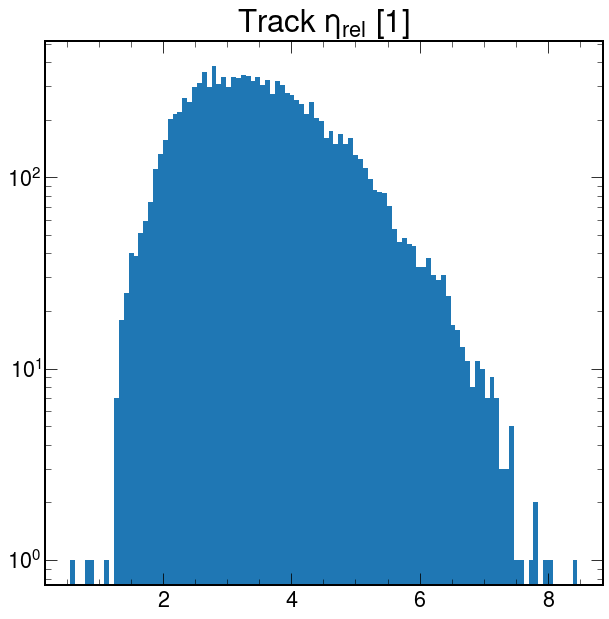

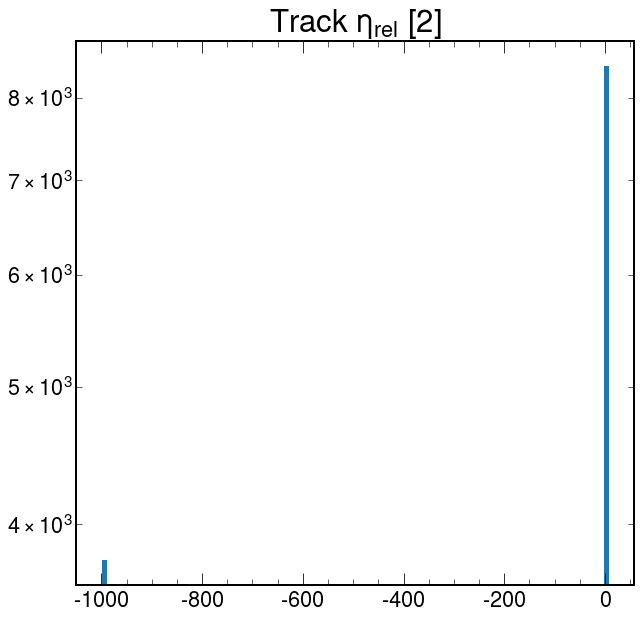

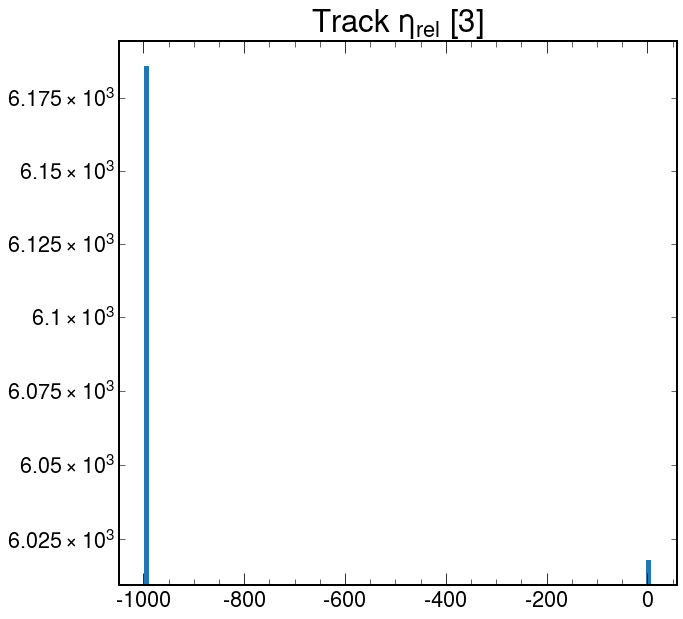

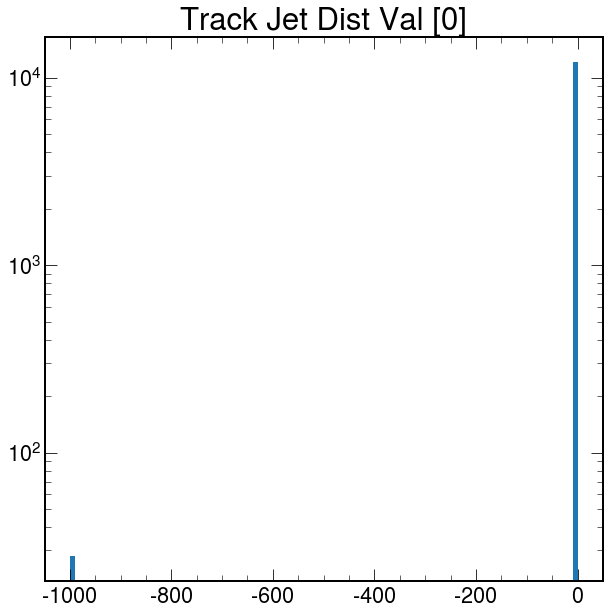

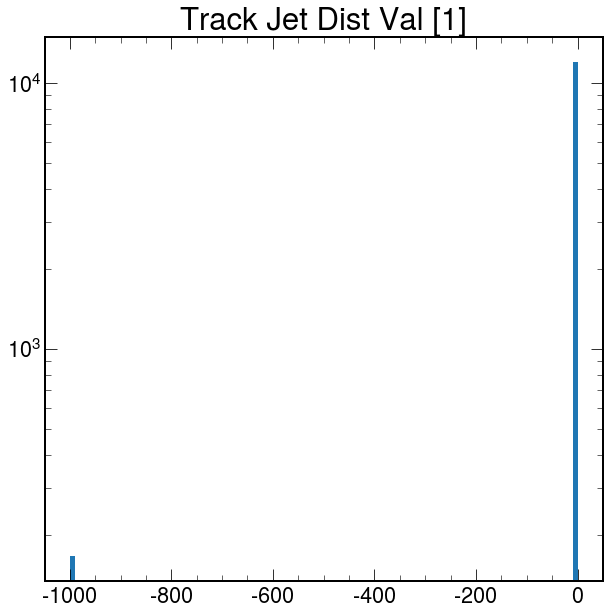

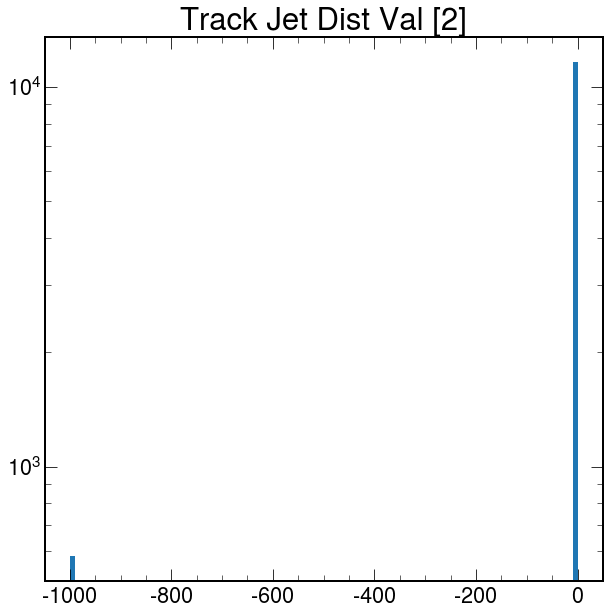

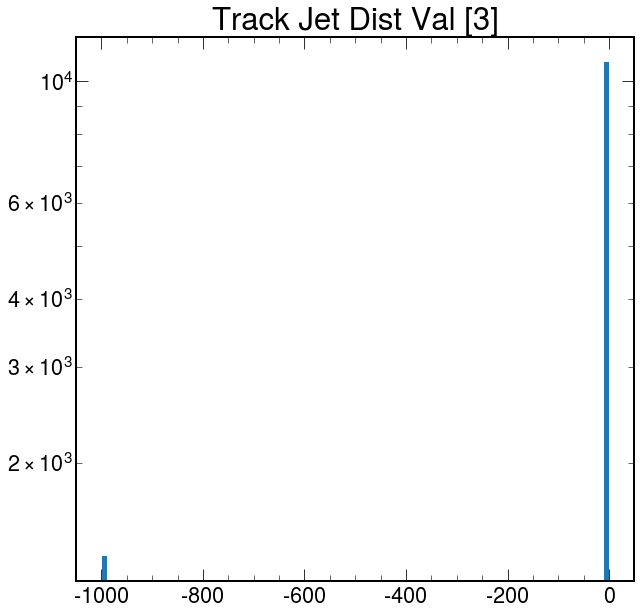

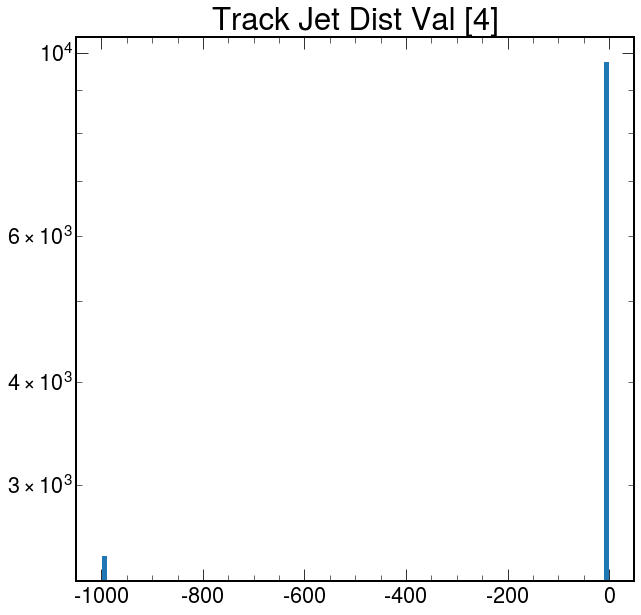

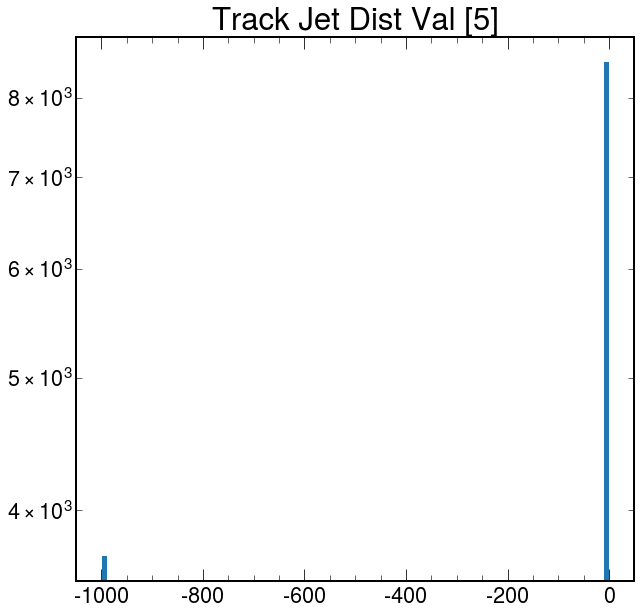

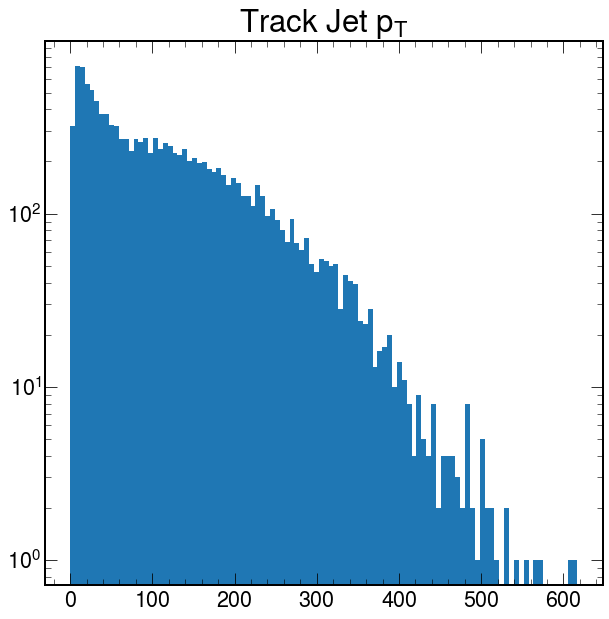

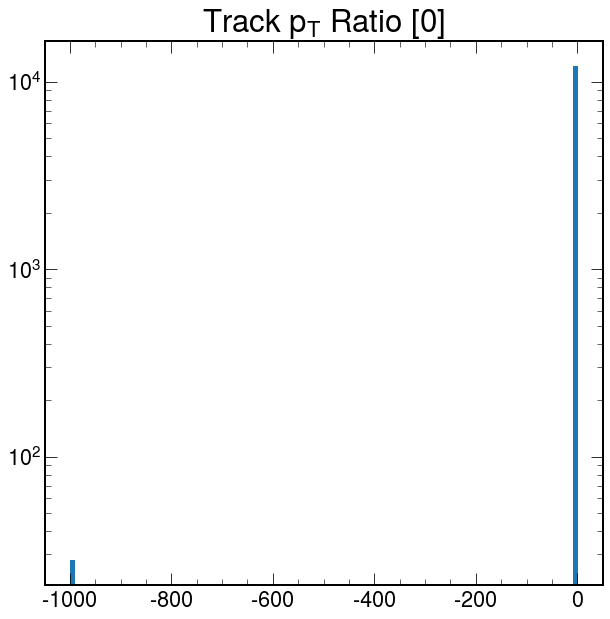

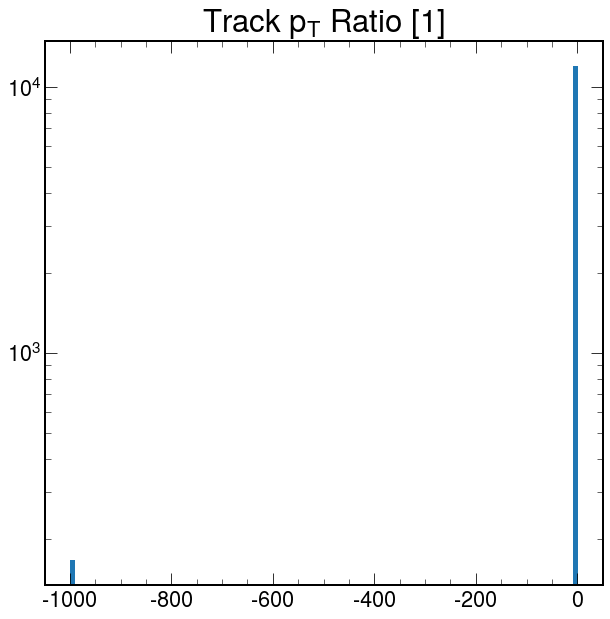

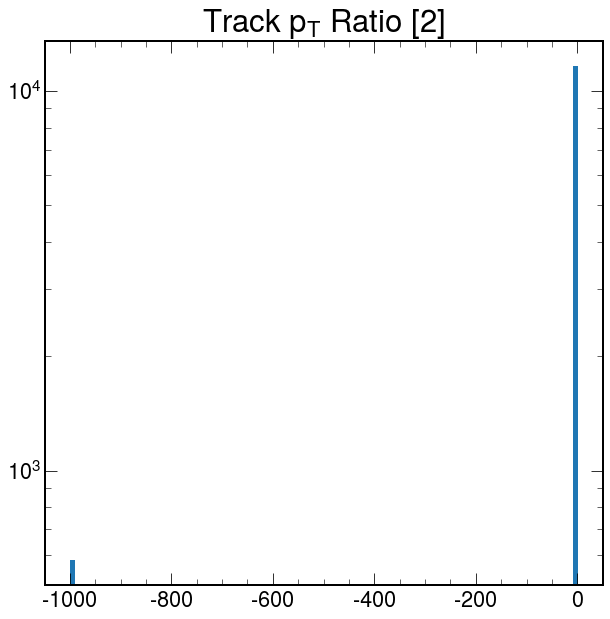

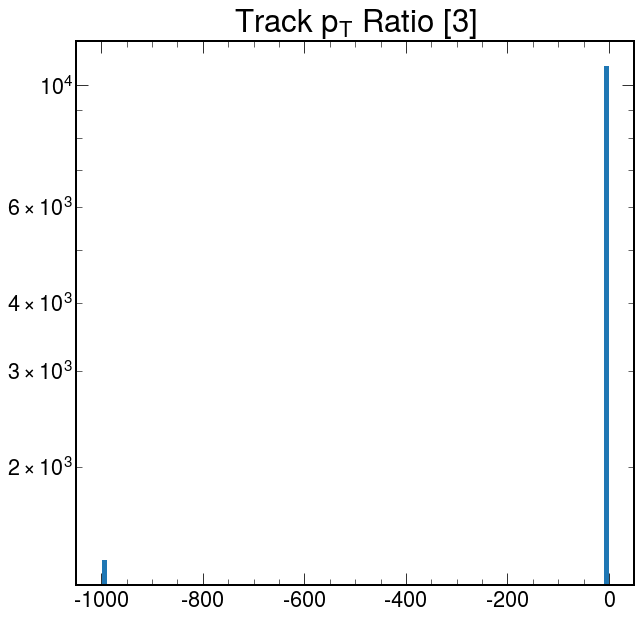

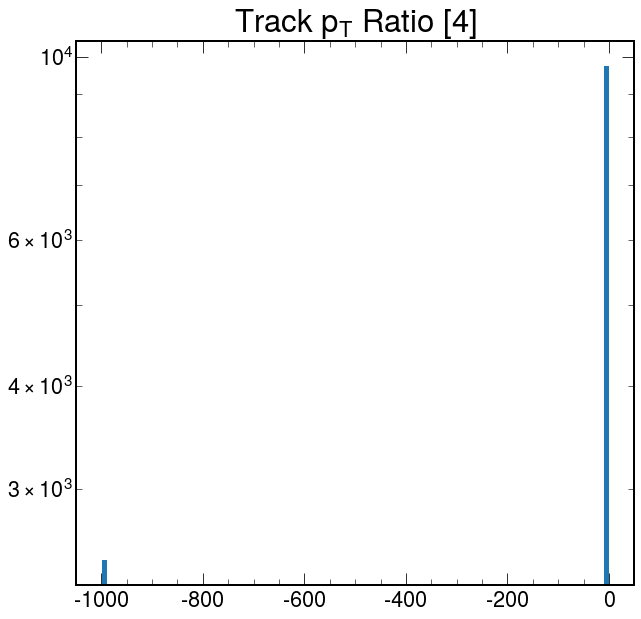

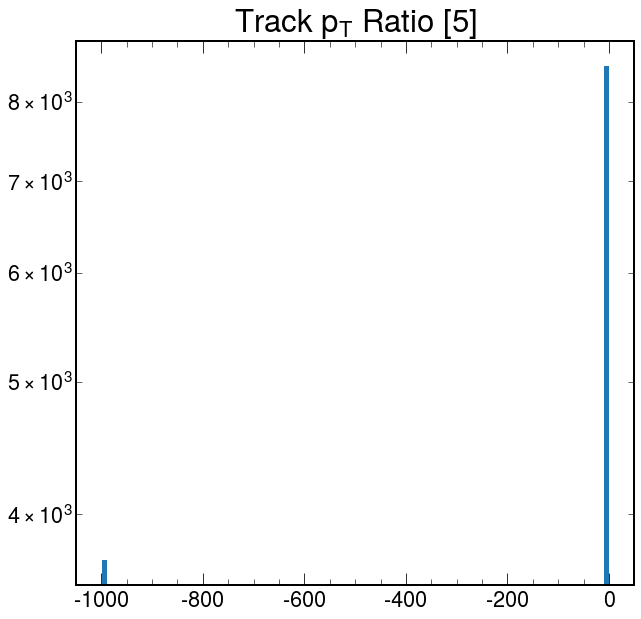

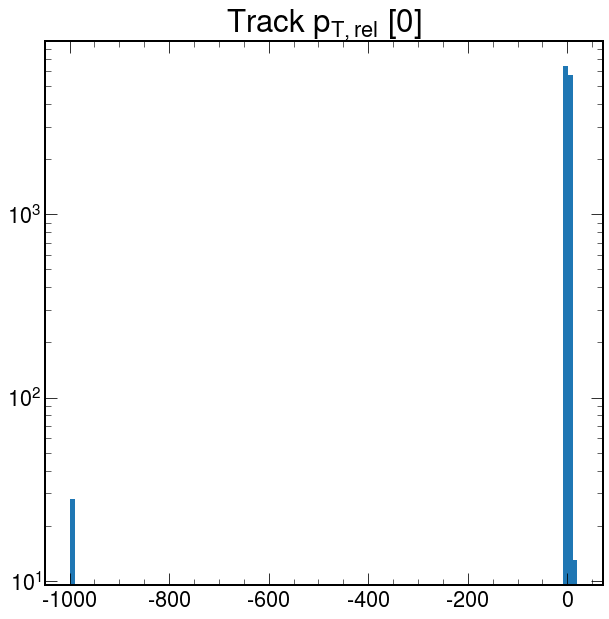

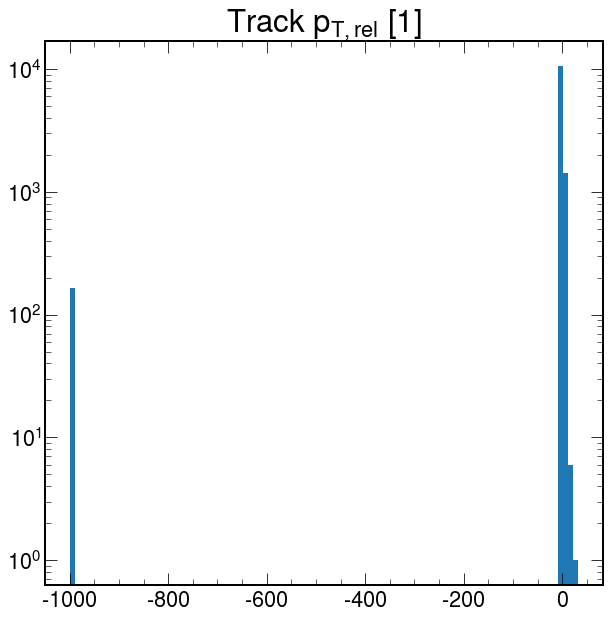

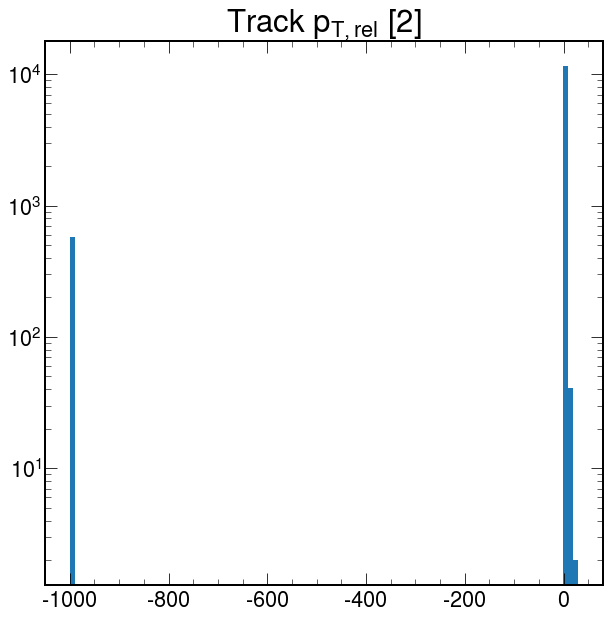

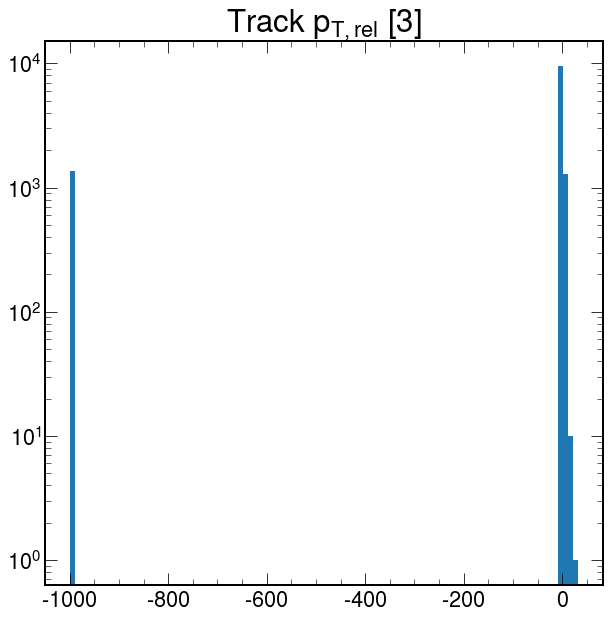

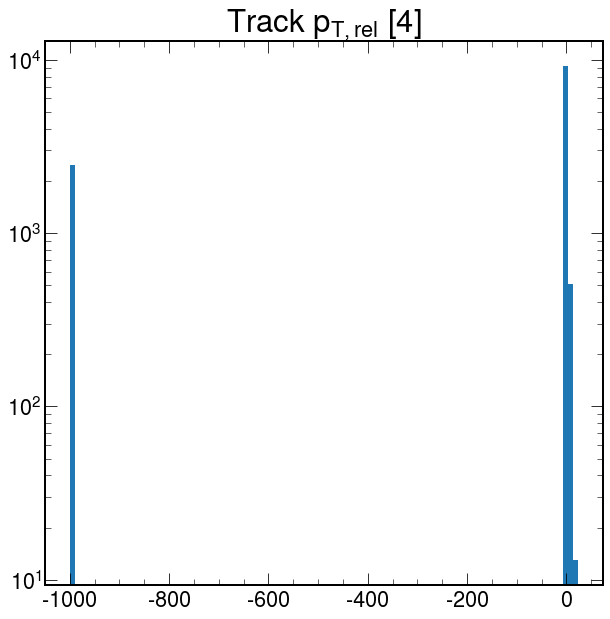

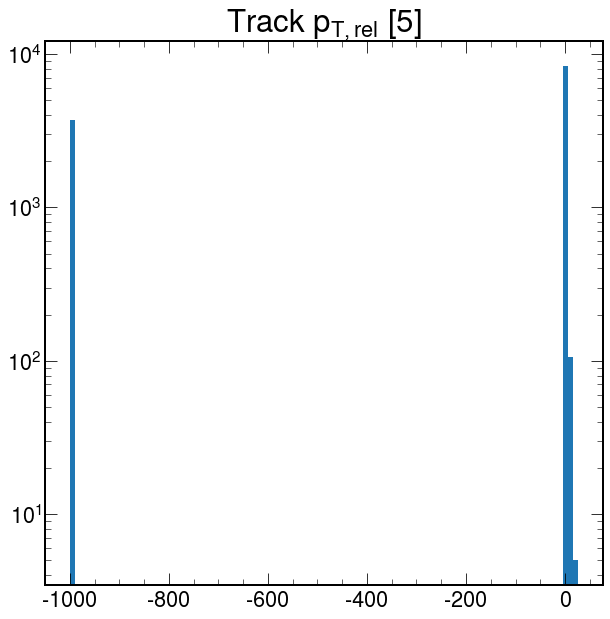

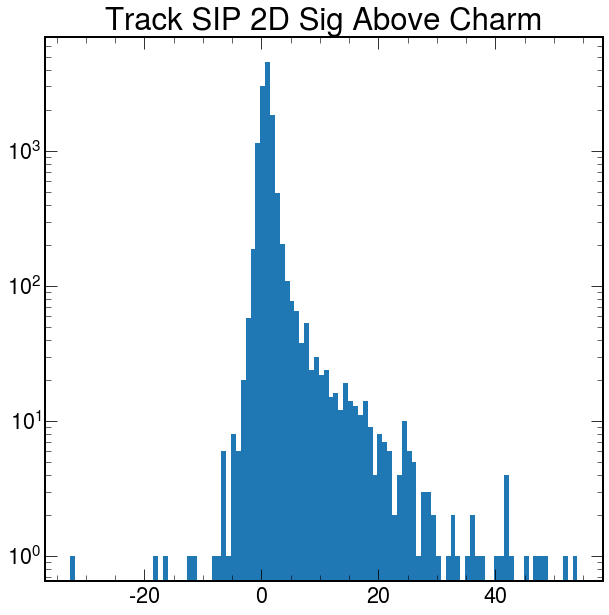

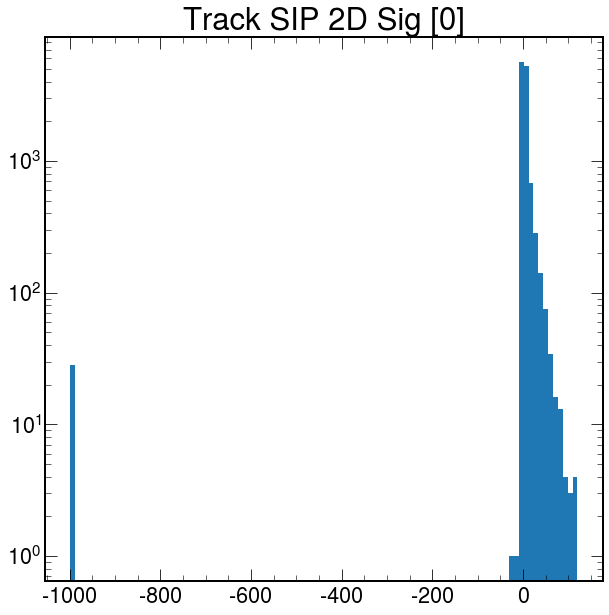

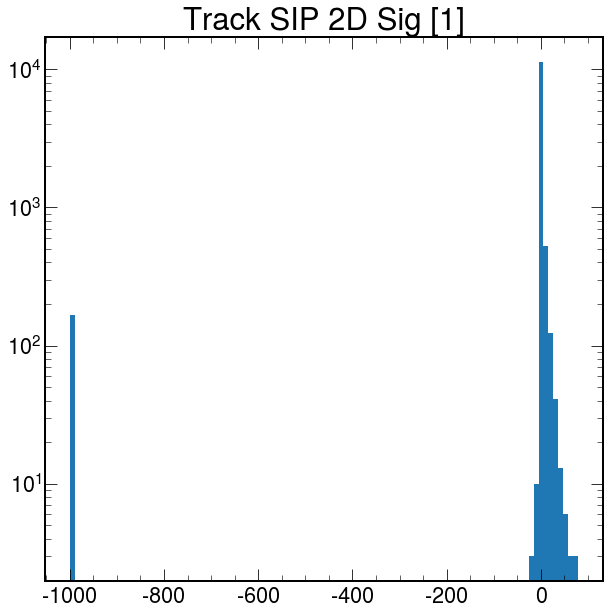

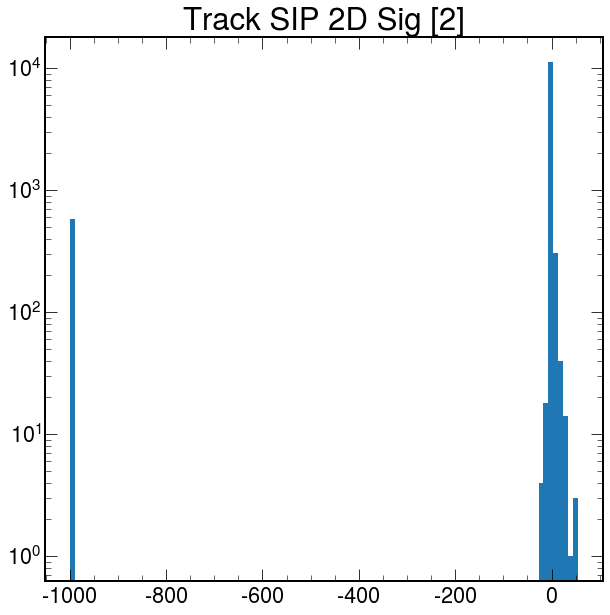

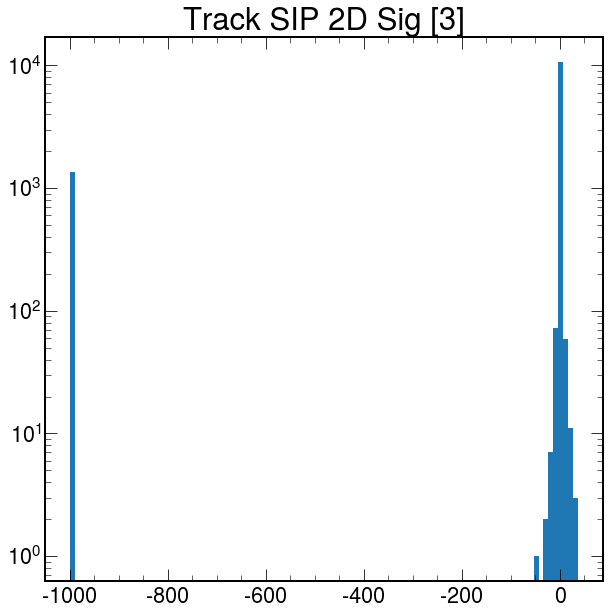

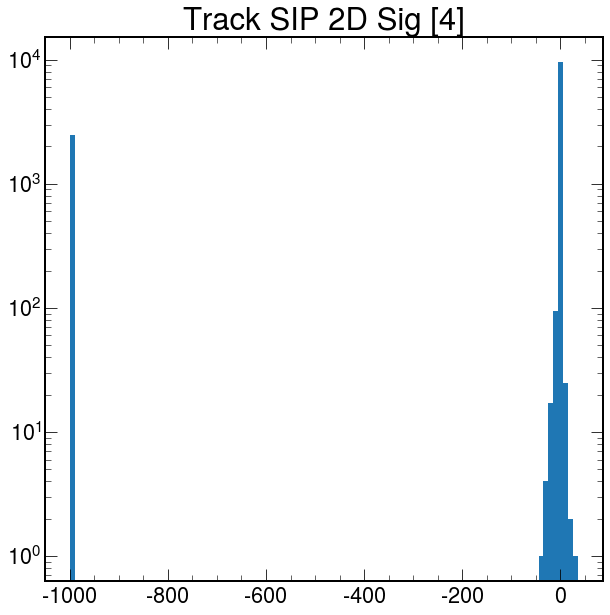

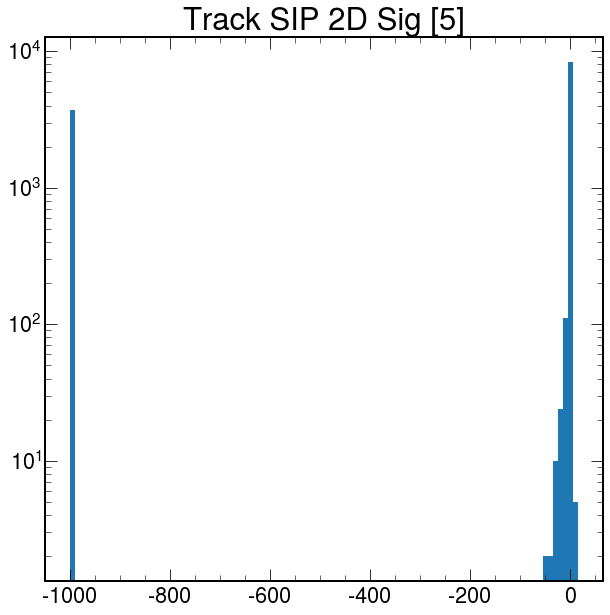

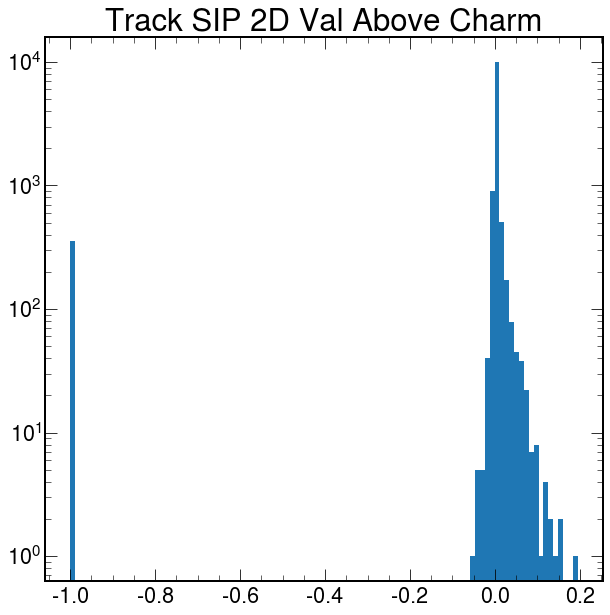

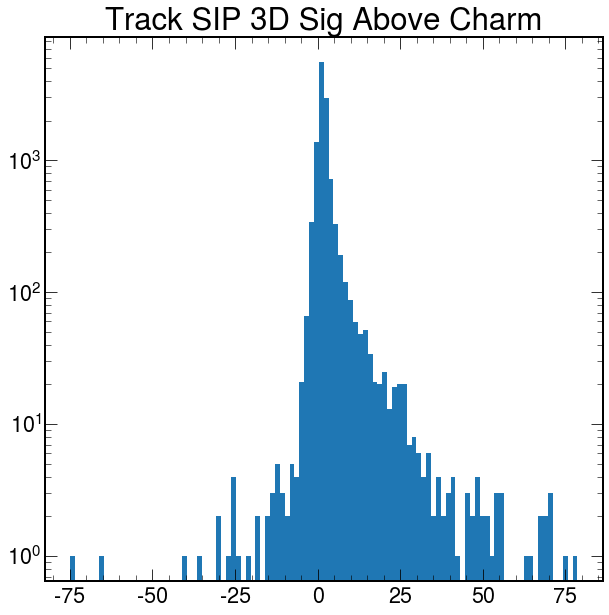

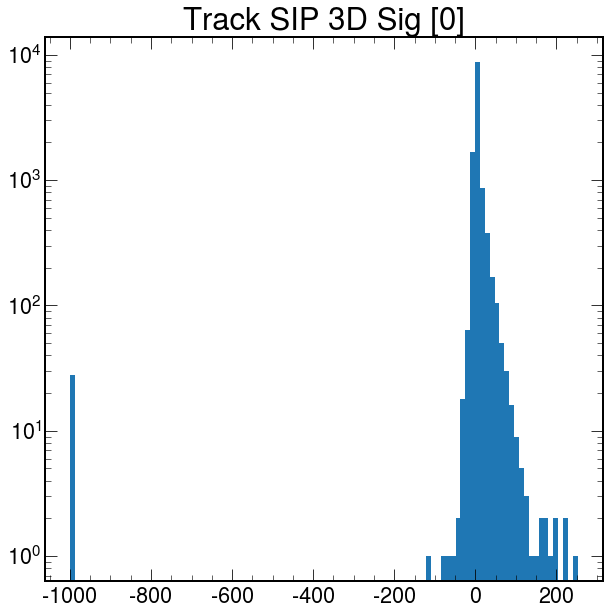

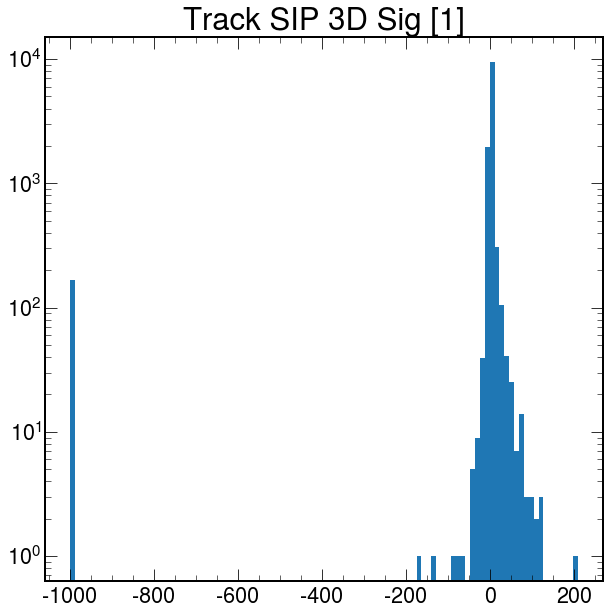

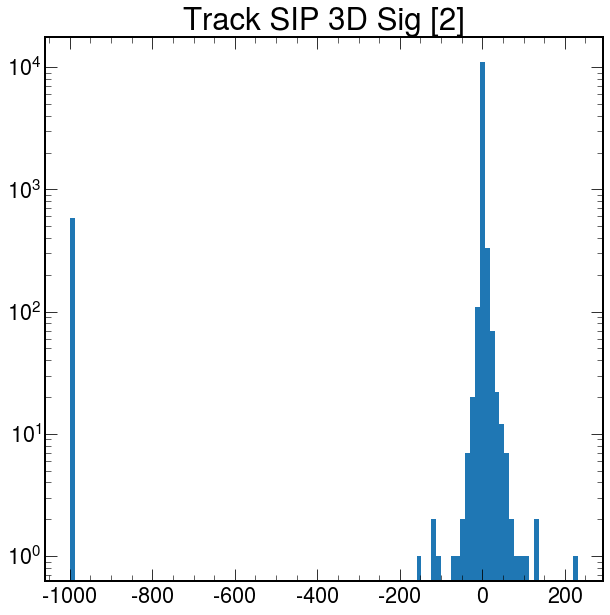

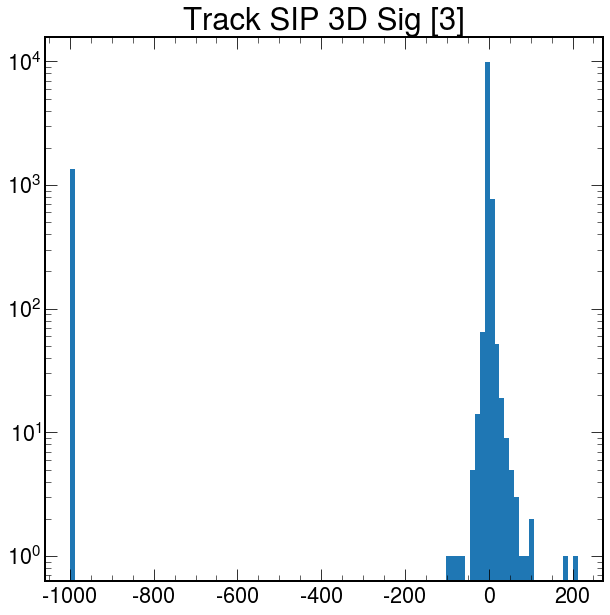

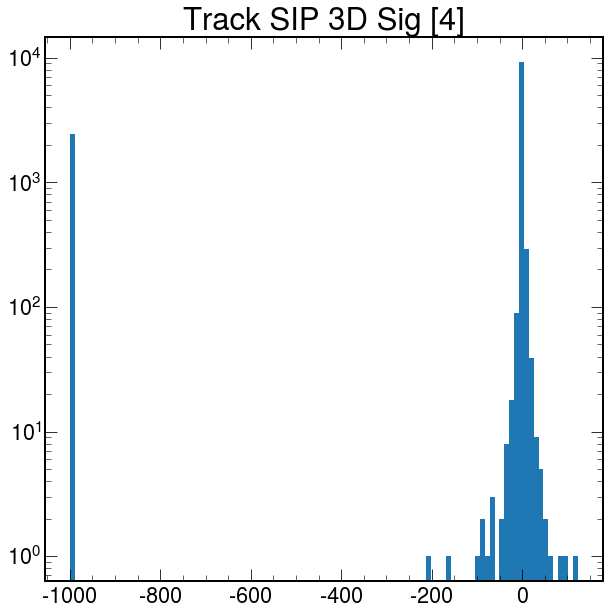

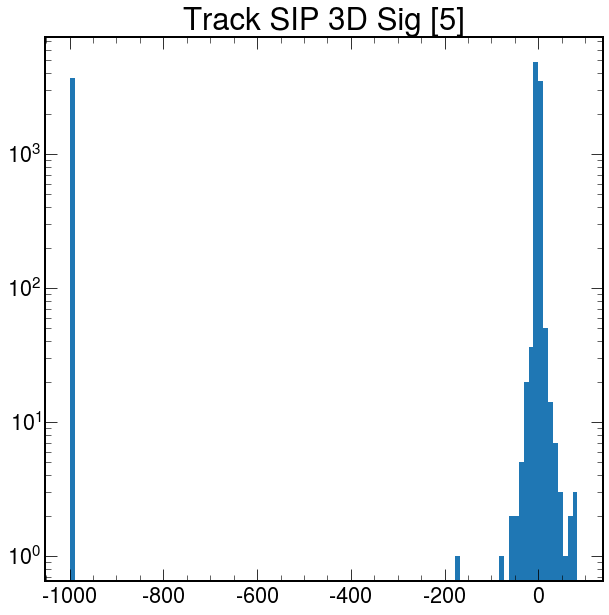

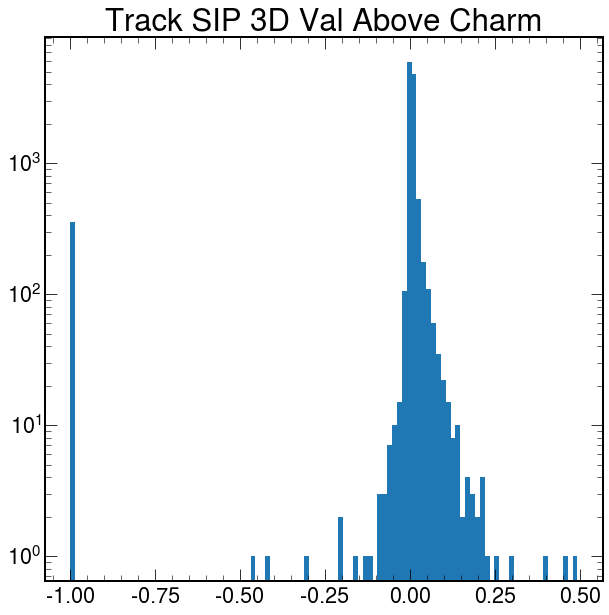

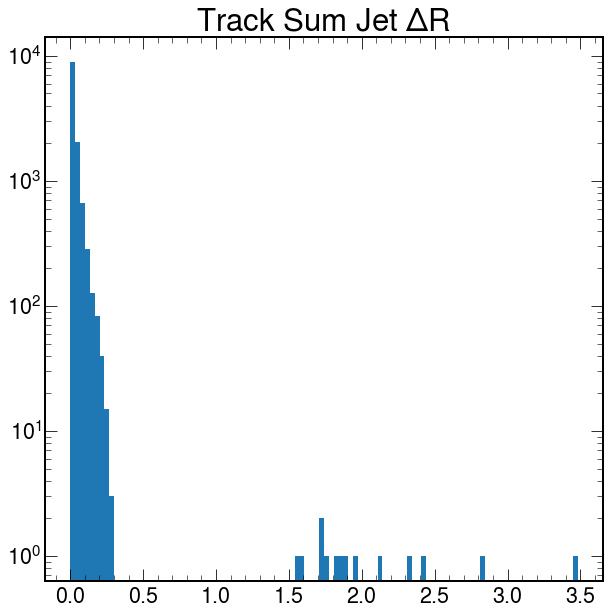

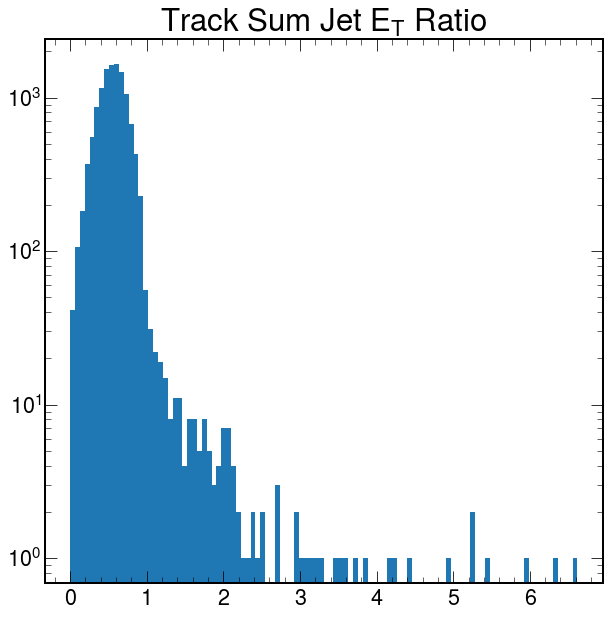

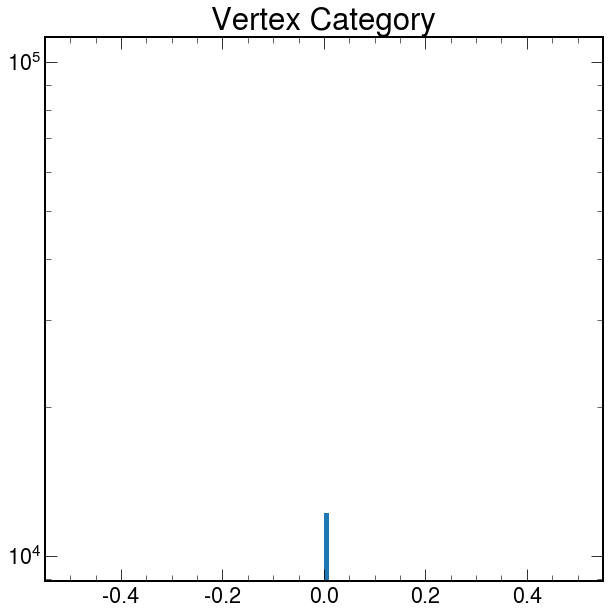

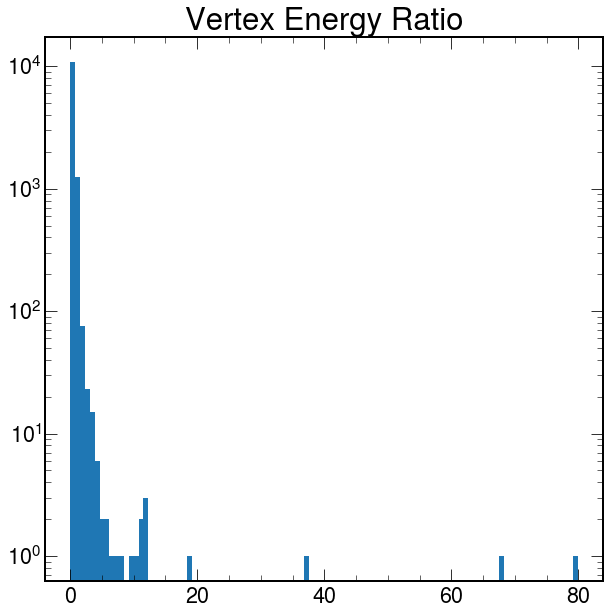

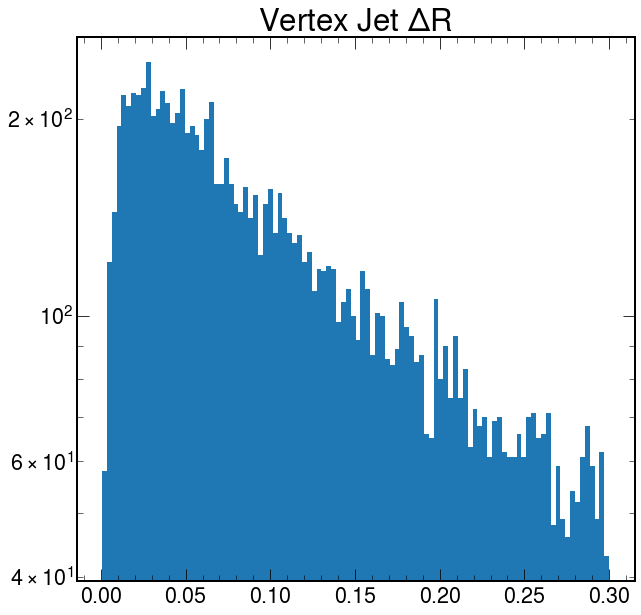

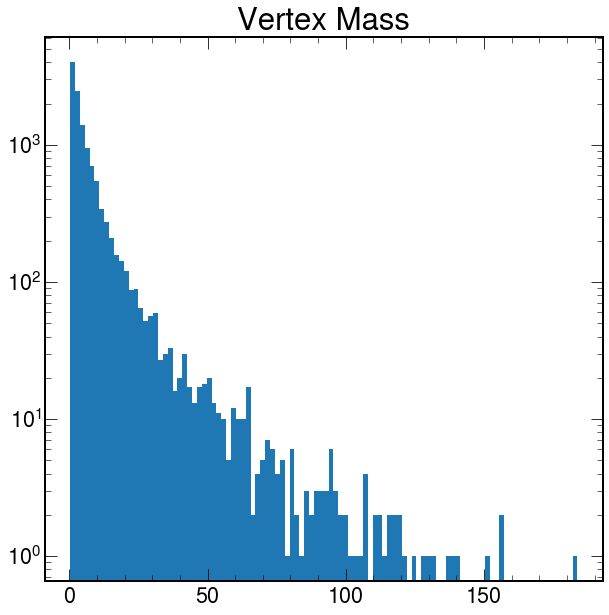

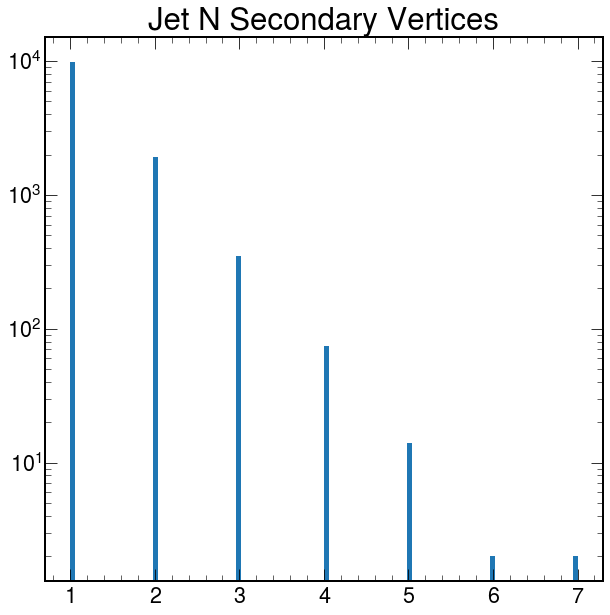

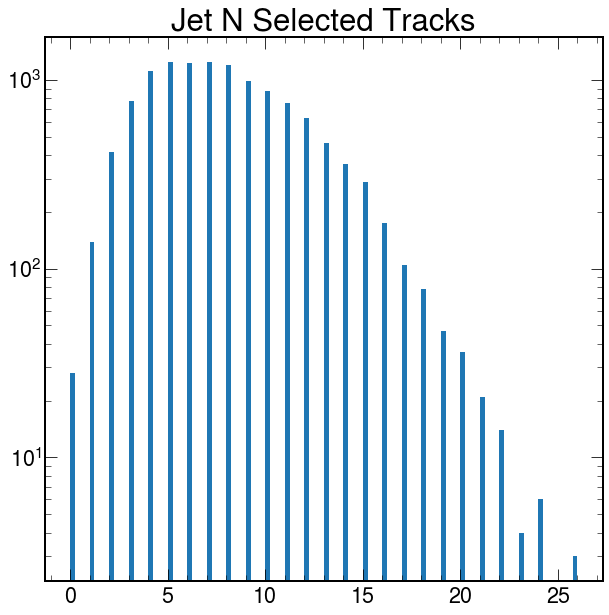

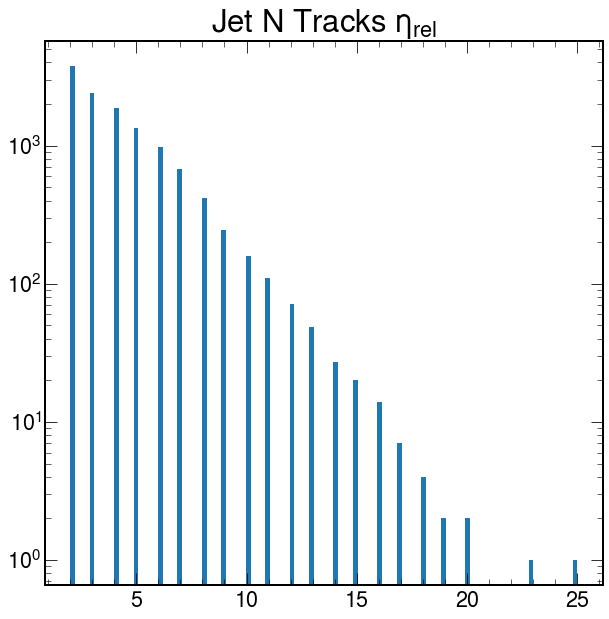

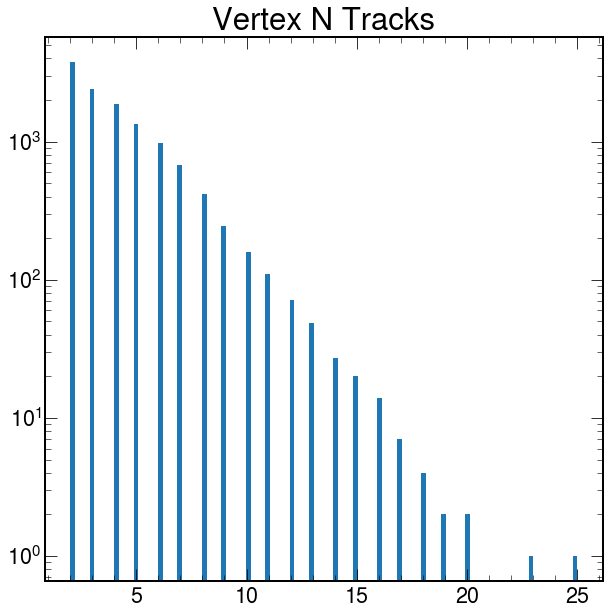

In [30]:
for var in range(67):
    plt.hist(dataset_step2[:,var], bins=104, log=True)
    plt.title(display_names[var])
    plt.show()

Result seems to do what we want and not delete any bins (this was only possible because I introduced default values instead of deleting whole rows from the dataset entirely I guess.)

Something else: Track Sum Jet Delta R does have quite a few values > 0.3, like 1.5 or 3.5 (and I don't know if there is another criterion that would make them defaults other than saying > 0.3 --> default).

### OLD Part 2 of the file cleaning...
...just for completeness, this was the function that cleans out large values, but also deletes the 5 tracks bin for Jet N Selected Tracks

In [45]:
'''
def cleandataset_part_2(data, DeepCSV):
    
    for j in range(len(data[0])):
        DeepCSV = DeepCSV[data[:, j] > -999]
        data = data[data[:, j] > -999]
        DeepCSV = DeepCSV[data[:, j] <= 1000]
        data = data[data[:, j] <= 1000]
    
    return data, DeepCSV
'''

Text(0.5, 1.0, 'Jet N Selected Tracks')

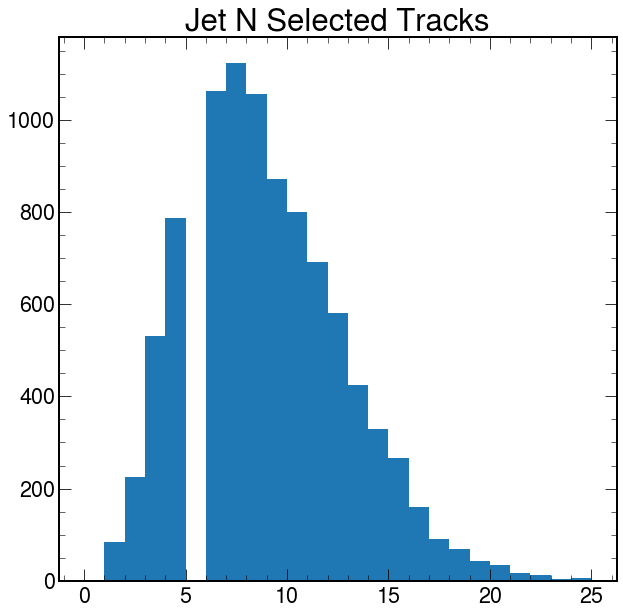

In [56]:
#plt.hist(jetNselectedTracks, bins=np.arange(26))
#plt.title('Jet N Selected Tracks')